## Imports

In [10]:
#import copy
import json
import math
#import pprint
import random
#import scipy
import sklearn
#import statistics
import matplotlib.pyplot as plt
import numpy
import random
from scipy.stats import beta, fit
from scipy.optimize import least_squares
from scipy.integrate import quad
from scipy.special import spence
from sklearn.metrics import r2_score

## Data loading and preprocessing

In [3]:
ranked_data_path = f"export.json"
ranked_data_file = open(ranked_data_path,encoding="utf-8")
ranked_data = json.load(ranked_data_file)

In [4]:
players = ranked_data["Players"]
maps = ranked_data["Maps"]
scores = ranked_data["Scores"]

In [5]:
min_score = 0.7
filtered_scores = [score for score in scores if score["Accuracy"] > min_score and score["Accuracy"] < 1.0 and score["Modifiers"] == ""]
#filtered_scores = [score for score in scores if score["Accuracy"] > min_score and score["Modifiers"] == ""]
print(len(scores))
print(len(filtered_scores))
print(len(filtered_scores)/len(scores))

3058785
2656447
0.8684647662388825


In [6]:
players_by_id = {player["Id"] : player for player in players}
maps_by_id = {bmap["Id"] : bmap for bmap in maps}
print(len(players_by_id.keys()))
print(len(maps_by_id.keys()))

107887
3635


### Calculating the gold standard for each map and adjusting scores with respect to that standard

In [7]:
# I don't like this, but for some reason the estimator does not allow values of exactly 1...
#gold_standard_multiplier = 0.9999

for map_id in maps_by_id:
    maps_by_id[map_id]["gold_standard"] = 0

for score in filtered_scores:
    map_id = score["LeaderboardId"]
    accuracy = score["Accuracy"]

    if accuracy > maps_by_id[map_id]["gold_standard"]:
        maps_by_id[map_id]["gold_standard"] = accuracy

#for score in filtered_scores:
#    map_id = score["LeaderboardId"]
#    accuracy = score["Accuracy"]

#    accuracy_wrt_gold = accuracy/maps_by_id[map_id]["gold_standard"]

#    score["accuracy_wrt_gold"] = accuracy_wrt_gold*gold_standard_multiplier    

In [8]:
scores_by_player_id = {}
scores_by_map_id = {}
score_data_by_map_id = {}

def add_score(score):
    player_id = score["PlayerId"]
    map_id = score["LeaderboardId"]
    
    player_map = scores_by_player_id.get(player_id,{})
    player_map[map_id] = score
    
    scores_by_player_id[player_id] = player_map    


    
    map_map = scores_by_map_id.get(map_id,{})
    map_map[player_id] = score
    
    scores_by_map_id[map_id] = map_map   


    
    score_data = score_data_by_map_id.get(map_id,[])

    score_data.append(score["Accuracy"])
    
    # Note that from now on we use the accuracy with respect to gold standard as data.
    # Therefore, when we want to go back to the actual score, we need to multiply by the gold standard or go to the original data.
    #score_data.append(score["accuracy_wrt_gold"])    

    score_data_by_map_id[map_id] = score_data

for score in filtered_scores:
    add_score(score)

for map_id in score_data_by_map_id:
    score_data = score_data_by_map_id[map_id]
    score_data.sort()
    score_data_by_map_id[map_id] = numpy.array(score_data)

## Fitting a map's scores to a beta distribution

In [44]:
hidden_max_score = 1.0001
hidden_max_score_mult = 1/hidden_max_score

def rscore(score):
    return score*hidden_max_score_mult

In [80]:
min_alpha = 1.01
min_beta = 1.01
max_alpha = 50
max_beta = 5

def fit_scores_beta(scores):    
    # (a, b, loc, scale) = beta.fit(scores, bounds=[[min_alpha,max_alpha],[min_beta,max_beta]],floc=0, fscale=1)
    result = fit(beta, rscore(scores), bounds=[[min_alpha,max_alpha],[min_beta,max_beta]])
    
    (a, b, loc, scale) = result.params
    return (a,b)

beta_parameters_per_map = {}

n_maps = 0
for map_id,scores in score_data_by_map_id.items():
    n_maps = n_maps+1
    if n_maps % 100 == 0:
        print(f"{n_maps} maps fit")
        
    beta_parameters_per_map[map_id] = fit_scores_beta(scores)

100 maps fit
200 maps fit
300 maps fit
400 maps fit
500 maps fit
600 maps fit
700 maps fit
800 maps fit
900 maps fit
1000 maps fit
1100 maps fit
1200 maps fit
1300 maps fit
1400 maps fit
1500 maps fit
1600 maps fit
1700 maps fit
1800 maps fit
1900 maps fit
2000 maps fit
2100 maps fit
2200 maps fit
2300 maps fit
2400 maps fit
2500 maps fit
2600 maps fit
2700 maps fit
2800 maps fit
2900 maps fit
3000 maps fit
3100 maps fit
3200 maps fit
3300 maps fit
3400 maps fit
3500 maps fit
3600 maps fit


In [81]:
# Using least squares

# Some help from ChatGPT used here (adapted)
def residuals(params, scores):   
    empirical_cdf = numpy.arange(1, len(scores) + 1) / len(scores)
    
    a, b = params
    model_cdf = beta.cdf(rscore(scores), a, b)
    return model_cdf - empirical_cdf

def fit_scores_beta_least_squares(scores, initial_params):
    residuals_lambda = lambda params:residuals(params,scores)
    
    result = least_squares(residuals_lambda, initial_params, bounds=([min_alpha,min_beta],[max_alpha,max_beta]))
    
    return result.x

least_squares_beta_parameters_per_map = {}

n_maps = 0
for map_id,scores in score_data_by_map_id.items():
    initial_params = beta_parameters_per_map[map_id]

    n_maps = n_maps+1
    if n_maps % 100 == 0:
        print(f"{n_maps} maps fit")

    least_squares_beta_parameters_per_map[map_id] = fit_scores_beta_least_squares(scores, initial_params)

100 maps fit
200 maps fit
300 maps fit
400 maps fit
500 maps fit
600 maps fit
700 maps fit
800 maps fit
900 maps fit
1000 maps fit
1100 maps fit
1200 maps fit
1300 maps fit
1400 maps fit
1500 maps fit
1600 maps fit
1700 maps fit
1800 maps fit
1900 maps fit
2000 maps fit
2100 maps fit
2200 maps fit
2300 maps fit
2400 maps fit
2500 maps fit
2600 maps fit
2700 maps fit
2800 maps fit
2900 maps fit
3000 maps fit
3100 maps fit
3200 maps fit
3300 maps fit
3400 maps fit
3500 maps fit
3600 maps fit


## Generating a PP curve

In [46]:
# The way this is calculated is a bit inefficient right now, lots of redundant calculations
# Normalized so that it reaches 1 at the gold standard score (which is 1 here as we are using relative scores)
def pp_curve_integral(x, params):
    a, b, gold_standard = params
    fun = lambda y: beta.cdf(rscore(y), a, b)
    
    total = quad(fun, 0, gold_standard)[0]
    
    return quad(fun, 0, x)[0]/total
    
# More efficient, for plotting it
def plot_pp_curve_integral(xx, params):
    a, b, gold_standard = params
    fun = lambda y: beta.cdf(rscore(y), a, b)

    total = quad(fun, 0, gold_standard)[0]
    mmax = quad(fun, 0, 1)[0]
    
    segments = numpy.array([quad(fun,s,e)[0] for s,e in zip(xx[:-1],xx[1:])])
        
    cumulative = numpy.cumsum(segments)
    # Renormalize to total, to correct for numerical errors in extreme cases.
    last = cumulative[-1]
    cumulative = cumulative*mmax/last    
    cumulative = numpy.append(cumulative,mmax)    
    
    return cumulative/total    

In [66]:
#log_over_one = 1.0001

def pp_curve_log(x, params):
    #a, b, gold_standard = params
    a, b = params

    #r_gold_standard = numpy.log(log_over_one - beta.cdf(gold_standard, a, b))
    f = beta.cdf(rscore(x), a, b)

    #return numpy.log(log_over_one - f)/r_gold_standard
    #return -numpy.log(log_over_one - f)
    return -numpy.log(1 - f)

In [67]:
def pp_curve_dilog(x, params):
    # a, b, gold_standard = params
    a, b = params

    #r_gold_standard = spence(1 - beta.cdf(gold_standard, a, b))
    f = beta.cdf(rscore(x), a, b)

    #return spence(1 - f)/r_gold_standard
    #return spence(log_over_one - f)/r_gold_standard
    return spence(1 - f)

## Birating algorithm to estimate parameters by mutual iteration

In [82]:
class BiRating:
    """No description yet"""
    
    def __init__(self,
                 anodes_params,bnodes_params,
                 afun,bfun,
                 anorm, bnorm,
                 metrics_fun,
                 metrics_halt_condition,
                 max_iter=10,
                 iter_fun=None,
                 metrics_each_iteration=True,
                 debug=False):
        """
        anodes_params and bnodes_params must be dictionaries with the node identifiers as keys
        and initial parameters as values.
                
        afun and bfun must be functions taking an identifier of the corresponding node type, the prior parameters
        for the corresponding node, and the dictionary of all parameters for the other node type,
        and returns the corresponding parameters for the node that is calculated from them.

        anorm and bnorm are functions called after the a and b cycle respectively to normalize the values after having calculated all of them.
        These receives the sets of weights of their type, and receives the resulting set of weights (that can be the same).
        
        metrics_fun receives the two anodes_params and bnodes_params dictionaries with the most recent values
        and generates metrics for the current result, in whatever format

        metrics_halt_condition receives the result of metrics_fun of this iteration and the last, and returns True or False indicating
        whether the algorithm should continue (True means continue).

        iter_fun is an optional callback function that is called after calculating metrics after each iteration. It receives the
        iteration number, the node parameters, and the last calculated metrics.
        """
        self.anodes_params = anodes_params.copy()
        self.bnodes_params = bnodes_params.copy()
                
        self.afun = afun
        self.bfun = bfun

        self.anorm = anorm
        self.bnorm = bnorm

        self.metrics_fun = metrics_fun
        self.metrics_halt_condition = metrics_halt_condition    
        self.metrics_each_iteration = metrics_each_iteration
        
        self.iter = 0
        self.max_iter = max_iter              

        self.iter_fun = iter_fun      

        self.metrics = []

        self.debug_on = debug

    def debug(self,text):
        if self.debug_on:
            print(text)
        
    def calculate_metrics(self):
        return self.metrics_fun(self.anodes_params,self.bnodes_params)

    def metrics_iteration(self):
        if self.metrics_each_iteration:
            metrics = self.calculate_metrics()
            if not self.iter_fun is None:
                self.iter_fun(self.iter,self.anodes_params,self.bnodes_params,metrics)
    
            if len(self.metrics) > 0:
                continue_flag = self.metrics_halt_condition(metrics, self.metrics[-1])    
    
                self.metrics.append(metrics)
        
                return continue_flag
            else:
                self.metrics.append(metrics)
    
                return True
        else:
            return True
   
    def acycle(self):
        anodes = 0
        for anode_id in self.anodes_params:
            anodes = anodes + 1
            if anodes % 500 == 0:
                self.debug(f"{anodes} A nodes processed")
            self.anode_process(anode_id)

        self.anodes_params = self.anorm(self.anodes_params)
    
    def anode_process(self,anode_id):        
        self.anodes_params[anode_id] = self.afun(anode_id,self.anodes_params[anode_id],self.bnodes_params)
    
    def bcycle(self):
        bnodes = 0
        for bnode_id in self.bnodes_params:
            bnodes = bnodes + 1
            if bnodes % 5000 == 0:
                self.debug(f"{bnodes} B nodes processed")
            self.bnode_process(bnode_id)

        self.bnodes_params = self.bnorm(self.bnodes_params)
    
    def bnode_process(self,bnode_id):                
        self.bnodes_params[bnode_id] = self.bfun(bnode_id,self.bnodes_params[bnode_id],self.anodes_params)
    
    def iterate(self):
        self.debug("B cycle starting")
        self.bcycle()
        self.debug("A cycle starting")
        self.acycle()
        
        self.iter += 1

        self.debug("Metrics iteration")
        return self.metrics_iteration()
        
    def run(self):    
        if not self.metrics_iteration():
            return (self.anodes_params,self.bnodes_params)   
        
        while (self.iter <= self.max_iter and self.iterate()):
            self.debug(f"{self.iter} iterations complete")
            pass
                
        return (self.anodes_params,self.bnodes_params)   
    

In [207]:
class BetaSaberBiRating(BiRating):
    def __init__(self,
                 map_data_by_id,
                 score_data_by_map_id_player_id,
                 score_data_by_player_id_map_id,
                 beta_params_per_map_id,
                 skill_per_player_id,
                 aggregation_player_skill_fun = aggregation_topscores,
                 iter_fun = None,
                 metrics_each_iteration=True,
                 debug = False,
                 r2_each_iteration = True,
                 **kwargs):
        """
        map_data_by_id is the master dictionary of map data. Only some things are used.

        No player data is required.

        score_data_by_map_id_player_id and score_data_by_player_id_map_id are two doubly indexed dictionaries with the same data in opposite indexing orders.
        
        beta_params_per_map_id is a dictionary with map ids as keys and pairs of (a,b) parameters as values

        skill_per_player_id is a dictionary with player ids as keys and estimations of skill (value between 0 and 1, a quantile) as values.
        """

        self.map_data_by_id = map_data_by_id
        self.score_data_by_map_id_player_id = score_data_by_map_id_player_id
        self.score_data_by_player_id_map_id = score_data_by_player_id_map_id
        self.aggregation_player_skill_fun = aggregation_player_skill_fun
        
        anodes_params = beta_params_per_map_id
        bnodes_params = skill_per_player_id

        afun = self.map_fun
        bfun = self.player_fun

        anorm = self.map_norm
        bnorm = self.player_norm

        metrics_fun = self.betasaber_metrics
        metrics_halt_condition = self.halt_condition

        self.r2_each_iteration = r2_each_iteration

        super().__init__(anodes_params, bnodes_params, afun, bfun, anorm, bnorm, metrics_fun, metrics_halt_condition, iter_fun = iter_fun, debug = debug, metrics_each_iteration = metrics_each_iteration, **kwargs)
        
    def player_fun(self, player_id, player_skill, map_params_by_id):
        # We could have some momentum on player skill here if we wanted to.        
        
        estimations = [self.get_player_estimation(score_data["Accuracy"], map_params_by_id[map_id])
                       for map_id,score_data in self.score_data_by_player_id_map_id[player_id].items()]
        
        return self.aggregation_player_skill_fun(estimations)

    def get_player_estimation(self, accuracy, map_params):
        (a, b) = map_params
        return beta.cdf(rscore(accuracy), a, b)

    def player_norm(self, player_params):
        player_values = numpy.array(list(player_params.values()))

        median = numpy.median(player_values)

        result = {}
        for player_id, player_value in player_params.items():
            if player_value >= median:
                result[player_id] = 0.5 + 0.5*(player_value - median)/(1 - median)
            else:
                result[player_id] = 0.5 - 0.5*(median - player_value)/median

        return result

    def get_pp_weight(self, accuracy, map_params, gold_standard):
        (a, b) = map_params
        full_params = (a, b, gold_standard)
        return pp_curve_log(accuracy, full_params)

    def map_fun(self, map_id, map_params, player_params_by_id):
        scores = []
        skills = []

        #self.debug(f"Map {map_id} before: {map_params}")
        for player_id,score_data in self.score_data_by_map_id_player_id[map_id].items():
            accuracy = score_data["Accuracy"]
            skill = player_params_by_id[player_id]
            scores.append(accuracy)
            skills.append(skill)

        scores = numpy.array(scores)
        skills = numpy.array(skills)
        #self.debug(f"{len(scores)} scores sent to least squares")
        result = fit_scores_beta_least_squares_with_skill(scores, skills, map_params)
        #self.debug(f"Map {map_id} after: {result}")
        return result

    def map_norm(self, map_params):
        return map_params
        
    def betasaber_metrics(self, map_params_by_id, player_params_by_id):
        self.debug("Beginning to calculate metrics")
        
        # Modifiable parameters
        quantiles = numpy.array([0, 0.25, 0.5, 0.75, 0.9, 1])
        score_thresholds = numpy.array([0.7, 0.8, 0.85, 0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 1])

        # Calculations
        map_metrics_by_id = {}
        map_r2_array = []

        highest_min_threshold_map_id = None
        highest_min_threshold = 0
        highest_100_threshold_map_id = None
        highest_100_threshold = 0
        lowest_100_threshold_map_id = None
        lowest_100_threshold = 99999

        debug_each_map = False        
        n_maps = 0
        
        for map_id,score_dataset in self.score_data_by_map_id_player_id.items():
            n_maps = n_maps + 1
            if n_maps % 50 == 0:
                self.debug(f"{n_maps} measured")
            
            if debug_each_map:
                self.debug(f"Map id: {map_id}")
            
            map_metrics = {}
            
            map_params = map_params_by_id[map_id]
            gold_standard = self.map_data_by_id[map_id]["gold_standard"]
            map_metrics["gold_standard"] = gold_standard

            # R2
            if self.r2_each_iteration:
                scores = []
                skills = []
                
                for player_id,score_data in score_dataset.items():
                    accuracy = score_data["Accuracy"]
                    skill = player_params_by_id[player_id]
                    scores.append(accuracy)
                    skills.append(skill)

                scores = numpy.array(scores)
                skills = numpy.array(skills)
                
                r2 = r_squared_with_skill(map_params, scores, skills)
                if debug_each_map:
                    self.debug(f"R2 squared: {r2}")
                map_r2_array.append(r2)
                map_metrics["r2"] = r2

            # Player skill thresholds
            skill_thresholds = [self.get_player_estimation(threshold, map_params) for threshold in score_thresholds]
            map_metrics["skill_thresholds"] = skill_thresholds

            # PP weight thresholds
            pp_thresholds = [self.get_pp_weight(threshold, map_params, gold_standard) for threshold in score_thresholds]
            map_metrics["pp_thresholds"] = pp_thresholds

            min_threshold = pp_thresholds[0]
            f100_threshold = pp_thresholds[-1]

            if debug_each_map:
                self.debug(f"Min threshold: {min_threshold}")
                self.debug(f"f100_threshold: {f100_threshold}")

            if min_threshold > highest_min_threshold:
                highest_min_threshold = min_threshold
                highest_min_threshold_map_id = map_id

            if f100_threshold > highest_100_threshold:
                highest_100_threshold = f100_threshold
                highest_100_threshold_map_id = map_id

            if f100_threshold < lowest_100_threshold:
                lowest_100_threshold = f100_threshold
                lowest_100_threshold_map_id = map_id

            map_metrics_by_id[map_id] = map_metrics
        

        if self.r2_each_iteration:
            map_r2_array = numpy.array(map_r2_array)
            map_r2_quantiles = numpy.quantile(map_r2_array,quantiles)
        else:
            map_r2_quantiles = []
                
        player_skill_array = numpy.array(list(player_params_by_id.values()))
        player_skill_quantiles = numpy.quantile(player_skill_array,quantiles)

        metrics = {
            "map_metrics_by_id": map_metrics_by_id,
            "map_r2_quantiles": map_r2_quantiles,
            "player_skill_quantiles": player_skill_quantiles,
            "highest_min_threshold_map_id": highest_min_threshold_map_id,
            "highest_min_threshold": highest_min_threshold,
            "highest_100_threshold_map_id": highest_100_threshold_map_id,
            "highest_100_threshold": highest_100_threshold,
            "lowest_100_threshold_map_id": lowest_100_threshold_map_id,
            "lowest_100_threshold": lowest_100_threshold
        }

        self.debug("Finalising metrics calculation")

        return metrics

    def halt_condition(self, metrics, previous_metrics):
        # For now we just do max iterations
        return True
            

In [50]:
# Helper functions that can be swapped more easily

# Exponential decaying average of skill estimations.
def aggregation_player_skill_decaying(player_skill_estimations, factor = 0.95, max_n = 50):    
    player_skill_estimations.sort(reverse=True)
    
    result = 0
    current_factor = 1
    divisor = 0
    n = 1
    for estimation in player_skill_estimations:
        n = n + 1
        if n > max_n:
            break
        divisor = divisor + current_factor
        result = result + current_factor * estimation
        current_factor = current_factor * factor

    return result/divisor    

def aggregation_player_skill_average(player_skill_estimations):
    return numpy.average(player_skill_estimations)

def aggregation_topscores(player_skill_estimations,perc=0.5,default_value=0.5):
    player_skill_estimations.sort()
    l = len(player_skill_estimations)
    n = math.ceil(l*perc)
    
    if n == 0:
        return default_value
    else:
        return numpy.average(player_skill_estimations[l-n:])    

# scores and skills should be in the same order
def residuals_with_skill(params, scores, skills):   
    empirical_cdf = skills
    
    a, b = params
    model_cdf = beta.cdf(rscore(scores), a, b)
    return model_cdf - empirical_cdf

def fit_scores_beta_least_squares_with_skill(scores, skills, initial_params):
    residuals_lambda = lambda params:residuals_with_skill(params,scores,skills)
    
    result = least_squares(residuals_lambda, initial_params, bounds=([min_alpha,min_beta],[max_alpha,max_beta]))

    #print(f"THE RESULT HERE IS {result}")
    #print(f"result.x = {result.x}")
    return result.x

# R squared - For one map.
def r_squared_with_skill(params, scores, skills):    
    empirical_cdf = skills
    
    a, b = params
    model_cdf = beta.cdf(rscore(scores), a, b)

    return r2_score(empirical_cdf, model_cdf)

## General metrics

In [ ]:
# R squared
def r_squared_beta(params, scores):
    # We presume the scores are sorted for performance!
    #scores.sort()
    
    empirical_cdf = numpy.arange(1, len(scores) + 1) / len(scores)
    
    a, b = params
    model_cdf = beta.cdf(rscore(scores), a, b)

    return r2_score(empirical_cdf, model_cdf)
    
# Quantiles
def quantiles_beta(params, scores, n_quantiles):    
    # We presume the scores are sorted for performance!
    #scores.sort()
    
    quantiles = numpy.arange(1, n_quantiles) / n_quantiles

    n = len(scores)    

    def empirical_quantile(quantile):
        return scores[math.floor(n*quantile)]

    a, b = params
    def model_quantile(quantile):
        return beta.ppf(quantile, a, b)        
        
    return {quantile:(empirical_quantile(quantile),model_quantile(quantile)) for quantile in quantiles}

n_quantiles = 10
beta_r_squared_values = {}
beta_quantile_values = {}
least_squares_beta_r_squared_values = {}
least_squares_beta_quantile_values = {}

for map_id,scores in score_data_by_map_id.items():
    params = beta_parameters_per_map[map_id]
    least_squares_params = least_squares_beta_parameters_per_map[map_id]
    
    beta_r_squared_values[map_id] = r_squared_beta(params,scores)
    beta_quantile_values[map_id] = quantiles_beta(params,scores,n_quantiles)
    least_squares_beta_r_squared_values[map_id] = r_squared_beta(least_squares_params,scores)
    least_squares_beta_quantile_values[map_id] = quantiles_beta(least_squares_params,scores,n_quantiles)

## Plots

In [146]:
x_ticks = [0, 0.25, 0.5, 0.75, 1]
x_labels = [f"{x_tick*100:.2f}%" for x_tick in x_ticks]

def show_map_density_by_map_id(map_id, map_params_by_map_id = least_squares_beta_parameters_per_map, **kwargs):        
    #(mla,mlb) = beta_parameters_per_map[map_id]
    (lsa,lsb) = map_params_by_map_id[map_id]
    
    scores = score_data_by_map_id[map_id]

    map_data = maps_by_id[map_id]

    show_map_density(map_data,scores,lsa,lsb,**kwargs)

# The gold standard is presumed to be in map_data
def show_map_density(map_data, scores, a, b, suffix = ""):
    n_scores = len(scores)
    gold_standard = map_data["gold_standard"]   
        
    #xx = numpy.linspace(min_score,1,n_scores)    
    xx = numpy.linspace(0,1,n_scores)    

    ls_fitted = lambda x:beta.pdf(rscore(x),a,b)    
    ls_fitted_values = ls_fitted(xx)
    max_density = numpy.max(ls_fitted_values)

    plt.hist(scores,bins=15,density=True,label="Real score distribution")
    plt.plot(xx,ls_fitted_values,"r",label="Least squares estimation")

    plt.vlines(gold_standard,0,max_density+1,colors="y",linestyles="dotted",label=f"Max. realistic score={gold_standard:.2f}")   

    map_id = map_data["Id"]
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"Score density for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id}) {suffix}")
    plt.xlabel("Score percentage")
    plt.ylabel("Density")
    plt.yticks([])
    plt.xticks(x_ticks,labels=x_labels)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [147]:
x_ticks = [0, 0.25, 0.5, 0.75, 1]
x_labels = [f"{x_tick*100:.2f}%" for x_tick in x_ticks]

def show_map_distribution_by_map_id(map_id, map_params_by_map_id = least_squares_beta_parameters_per_map, **kwargs):        
    #(mla,mlb) = beta_parameters_per_map[map_id]
    (lsa,lsb) = map_params_by_map_id[map_id]
    
    scores = score_data_by_map_id[map_id]

    map_data = maps_by_id[map_id]

    show_map_distribution(map_data,scores,lsa,lsb, **kwargs)

# The gold standard is presumed to be in map_data
def show_map_distribution(map_data, scores, a, b, suffix = ""):    
    n_scores = len(scores)
    gold_standard = map_data["gold_standard"]   
    
    ls_fitted = lambda x: beta.cdf(rscore(x),a,b)        
    
    xx = numpy.linspace(0,1,n_scores)
    yy = numpy.linspace(0,1,n_scores)      

    plt.plot(scores, yy, marker='.', linestyle='-',label="Real score distribution")    
    plt.plot(xx,ls_fitted(xx),"r",label="Least squares estimation")

    plt.vlines(gold_standard,0,1,colors="y",linestyles="dotted",label=f"Max. realistic score={gold_standard}:.2f")    
    
    ax = plt.gca()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xticks(x_ticks,labels=x_labels)

    map_id = map_data["Id"]
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"Score distribution for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id}) {suffix}")
    plt.xlabel("Score percentage")
    plt.ylabel("Proportion of scores")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [204]:
key_points = [0.75,0.9,0.96,0.98,0.995,1]
x_ticks = [0, 0.25, 0.5, 0.75, 1]
x_labels = [f"{x_tick*100:.2f}%" for x_tick in x_ticks]

def show_map_pp_by_map_id(map_id, map_params_by_map_id = least_squares_beta_parameters_per_map, **kwargs):        
    #(mla,mlb) = beta_parameters_per_map[map_id]
    (lsa,lsb) = map_params_by_map_id[map_id]
    
    scores = score_data_by_map_id[map_id]

    map_data = maps_by_id[map_id]

    show_map_pp(map_data,scores,lsa,lsb, **kwargs)

# The gold standard is presumed to be in map_data
def show_map_pp(map_data, scores, a, b, suffix = ""):    
    n_scores = len(scores)
    gold_standard = map_data["gold_standard"]   

    #xx = numpy.linspace(min_score,1,n_scores)
    xx = numpy.linspace(0,1,n_scores)
    
    ls_fitted = lambda x: beta.cdf(rscore(x),a,b)    

    #params = (a,b,gold_standard)
    params = (a,b)
    
    pp_curve = pp_curve_log(xx,params)

    max_pp = pp_curve_log(1,params)
    
    skill_at_gold_standard = beta.cdf(rscore(gold_standard),a,b)
    pp_at_gold_standard = pp_curve_log(gold_standard,params)
    
    plt.plot(xx,pp_curve,"c",label="Proposed PP curve shape")

    #plt.vlines(gold_standard,0,max_pp*1.1,colors="y",linestyles="dotted",label=f"At max. realistic score ({gold_standard*100:.2f}%), Skill={skill_at_gold_standard:.4f}, PP weight = {pp_at_gold_standard:.4f}")
    plt.hlines(pp_at_gold_standard,0,1,colors="y",linestyles="dotted")    

    n_key_points = len(key_points)
    
    skill_at_key_points = [beta.cdf(rscore(key_point),a,b) for key_point in key_points]    
    pp_at_key_points = [pp_curve_log(key_point,params) for key_point in key_points]    
    labels_at_key_points = [f"{key_points[i]*100:.2f}% = {pp_at_key_points[i]:.4f} PP ({skill_at_key_points[i]:.4f} skill)" for i in range(n_key_points)]

    skill_at_key_points.append(skill_at_gold_standard)
    pp_at_key_points.append(pp_at_gold_standard)
    labels_at_key_points.append(f"{gold_standard*100:.2f}% (max. realistic score) = {pp_at_gold_standard:.4f} PP ({skill_at_gold_standard:.4f} skill)")
    
    for i in range(n_key_points):
        color = (i/n_key_points,1 - i/n_key_points, 0, 0.2)
        #plt.vlines(key_points[i],0,max_pp*1.1,colors=color,linestyles="dashed",label=f"At {key_points[i]*100:.2f}%, Skill={skill_at_key_points[i]:.2f}, PP weight = {pp_at_key_points[i]:.2f}")
        plt.hlines(pp_at_key_points[i],0,1,colors=color,linestyles="dashed")#,label=f"At {key_points[i]*100:.2f}%, Skill={skill_at_key_points[i]:.2f}, PP weight = {pp_at_key_points[i]:.2f}")        
    
    ax = plt.gca()
    #ax.set_xlim([min_score, 1])
    ax.set_xlim([0,1])
    ax.set_ylim([0, max_pp*1.1])
    ax.set_yticks(pp_at_key_points,labels=labels_at_key_points)
    ax.set_xticks(x_ticks,labels=x_labels)

    map_id = map_data["Id"]
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"Proposed PP curve shape for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id}) {suffix}")
    plt.xlabel("Score percentage")
    plt.ylabel("PP weight")
    #plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [203]:
x_ticks = [0, 0.25, 0.5, 0.75, 1]
x_labels = [f"{x_tick*100:.2f}%" for x_tick in x_ticks]

def show_map_pp_comparison_by_map_ids(map_ids, map_params_by_map_id = least_squares_beta_parameters_per_map, **kwargs):        
    arr_a = []
    arr_b = []    
    arr_map_data = []
    for map_id in map_ids:
        (lsa,lsb) = map_params_by_map_id[map_id]
        arr_a.append(lsa)
        arr_b.append(lsb)        
        arr_map_data.append(maps_by_id[map_id])

    show_map_pp_comparison(arr_map_data,1000,arr_a,arr_b, **kwargs)
    
def show_map_pp_comparison(arr_map_data, n_scores, arr_a, arr_b, min_x = 0.7, normalize=False):    
    xx = numpy.linspace(min_x,1,n_scores)    
    
    n_maps = len(arr_map_data)
    
    ls_fitted = lambda x: beta.cdf(rscore(x),a,b)    

    key_point_values = ["" for key_point in key_points]

    max_pp = 0
    
    for i in range(n_maps):
        map_data = arr_map_data[i]

        map_id = map_data["Id"]
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        params = (arr_a[i],arr_b[i])

        max_pp_map = pp_curve_log(1,params)
        max_pp = max(max_pp,max_pp_map)

        if normalize:
            pp_curve = pp_curve_log(xx,params)/max_pp_map
        else:
            pp_curve = pp_curve_log(xx,params)    
                
        plt.plot(xx,pp_curve,label=f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})")    
        
        #n_key_points = len(key_points)
        
        #skill_at_key_points = [beta.cdf(rscore(key_point),a,b) for key_point in key_points]    
        #pp_at_key_points = [pp_curve_log(key_point,params) for key_point in key_points]                
        
        #for i in range(n_key_points):
        #    key_point_values[i] = key_point_values[i] + f" / {pp_at_key_points[i]:.4f} PP ({skill_at_key_points[i]:.4f} skill)"

    #labels_at_key_points = [f"{key_points[i]*100:.2f}% = {key_point_values[i]}" for i in range(n_key_points)]

    #for i in range(n_key_points):
    #    color = (i/n_key_points,1 - i/n_key_points, 0, 0.2)
    #    plt.hlines(pp_at_key_points[i],0,1,colors=color,linestyles="dashed")#,label=f"At {key_points[i]*100:.2f}%, Skill={skill_at_key_points[i]:.2f}, PP weight = {pp_at_key_points[i]:.2f}")        
    
    ax = plt.gca()
    ax.set_xticks(x_ticks,labels=x_labels)                   
    ax.set_xlim([min_x, 1]) 
    if normalize:
        ax.set_ylim([0,1.1])
    else:
        ax.set_ylim([0, max_pp*1.1])
    
    if normalize:
        plt.title(f"Comparison of map PP curve shapes (normalized)")
    else:
        plt.title(f"Comparison of map PP curves")
    plt.xlabel("Score percentage")
    plt.ylabel("PP weight")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="x-small")
    
    plt.show()

In [149]:
x_ticks = [0, 0.25, 0.5, 0.75, 1]
x_labels = [f"{x_tick*100:.2f}%" for x_tick in x_ticks]

def show_map_skill_distribution_by_map_id(map_id, skills_by_player_id, map_params_by_map_id = least_squares_beta_parameters_per_map, **kwargs):        
    #(mla,mlb) = beta_parameters_per_map[map_id]
    (lsa,lsb) = map_params_by_map_id[map_id]
    
    scores = score_data_by_map_id[map_id]
    scores_with_players = scores_by_map_id[map_id]

    sort_func = lambda player_id: scores_with_players[player_id]["Accuracy"]
    sorted_player_ids = list(scores_with_players.keys())
    sorted_player_ids.sort(key=sort_func)
    skills = [skills_by_player_id[player_id] for player_id in sorted_player_ids]

    map_data = maps_by_id[map_id]

    show_map_skill_distribution(map_data,scores,skills,lsa,lsb,**kwargs)

# The gold standard is presumed to be in map_data
def show_map_skill_distribution(map_data, scores, skills, a, b, suffix = ""):    
    n_scores = len(scores)
    gold_standard = map_data["gold_standard"]   
    
    ls_fitted = lambda x: beta.cdf(rscore(x),a,b)        
    
    xx = numpy.linspace(0,1,n_scores)    

    plt.scatter(scores, skills, marker='.', label="Skill distribution")    
    plt.plot(xx,ls_fitted(xx),"r",label="Least squares estimation")

    plt.vlines(gold_standard,0,1,colors="y",linestyles="dotted",label=f"Max. realistic score={gold_standard:.2f}")    
    
    ax = plt.gca()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xticks(x_ticks,labels=x_labels)

    map_id = map_data["Id"]
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"Skill distribution for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id}) {suffix}")
    plt.xlabel("Score percentage")
    plt.ylabel("Player skill")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [27]:
# skills should be sorted
def show_skill_distribution(skills):    
    n_players = len(skills)
    
    plt.hist(skills,bins=30,density=True, label="Skill distribution")

    ax = plt.gca()
    ax.set_xlim([0,1])
    ax.axes.yaxis.set_visible(False)

    plt.title(f"Skill distribution across all players")
    plt.xlabel(f"Skill level")    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

## Results exploration

In [28]:
def map_summary(map_id, map_params_by_map_id = least_squares_beta_parameters_per_map, suffix = ""):
    map_data = maps_by_id[map_id]
    print(map_data)
    print(f"Least squares estimator: {map_params_by_map_id[map_id]}")
    #print(f"Least squares R squared: {least_squares_beta_r_squared_values[map_id]}")
    #print(f"Least squares quantiles: {least_squares_beta_quantile_values[map_id]}")    
    show_map_density_by_map_id(map_id, map_params_by_map_id = map_params_by_map_id, suffix = suffix)
    show_map_distribution_by_map_id(map_id, map_params_by_map_id = map_params_by_map_id, suffix = suffix)
    show_map_pp_by_map_id(map_id, map_params_by_map_id = map_params_by_map_id, suffix = suffix)

def random_map_summary():
    random_map = random.choice(maps)
    map_id = random_map["Id"]
    map_summary(map_id)

def map_summary_with_skills(map_id, skills_by_player_id, map_params_by_map_id = least_squares_beta_parameters_per_map, suffix = ""):
    map_data = maps_by_id[map_id]
    print(map_data)
    print(f"Least squares estimator: {map_params_by_map_id[map_id]}")
    #print(f"Least squares R squared: {least_squares_beta_r_squared_values[map_id]}")
    #print(f"Least squares quantiles: {least_squares_beta_quantile_values[map_id]}")    
    #show_map_density_by_map_id(map_id, map_params_by_map_id = map_params_by_map_id, suffix = suffix)
    #show_map_distribution_by_map_id(map_id, map_params_by_map_id = map_params_by_map_id, suffix = suffix)
    show_map_skill_distribution_by_map_id(map_id, skills_by_player_id, map_params_by_map_id, suffix = suffix)
    show_map_pp_by_map_id(map_id, map_params_by_map_id = map_params_by_map_id, suffix = suffix)

In [ ]:
best_r_squared_map_id = None
best_r_squared = None
worst_r_squared_map_id = None
worst_r_squared = None
worst_quantile_map_id = None
worst_quantile_quantile = None
worst_quantile_diff = None
worst_quantile_real = None
worst_quantile_estimated = None

for map_id in maps_by_id:
    r_squared = least_squares_beta_r_squared_values[map_id]
    quantile_values = least_squares_beta_quantile_values[map_id]

    if best_r_squared_map_id is None or r_squared > best_r_squared:
        best_r_squared_map_id = map_id
        best_r_squared = r_squared

    if worst_r_squared_map_id is None or r_squared < worst_r_squared:
        worst_r_squared_map_id = map_id
        worst_r_squared = r_squared

    for quantile,quantile_values in least_squares_beta_quantile_values[map_id].items():
        quantile_diff = abs(quantile_values[0]-quantile_values[1])

        if worst_quantile_map_id is None or quantile_diff > worst_quantile_diff:
            worst_quantile_map_id = map_id
            worst_quantile_quantile = quantile
            worst_quantile_diff = quantile_diff
            worst_quantile_real = quantile_values[0]
            worst_quantile_estimate = quantile_values[1]

In [ ]:
map_summary(best_r_squared_map_id)

In [ ]:
map_summary(worst_r_squared_map_id)

In [ ]:
map_summary(worst_quantile_map_id)

{'Hash': 'f402008042efaca4291a6633ebb6b562e4adcd87', 'Name': 'Ov Sacrament and Sincest', 'CoverImage': 'https://eu.cdn.beatsaver.com/f402008042efaca4291a6633ebb6b562e4adcd87.jpg', 'Mapper': 'Rogdude', 'Id': 'c32d91', 'SongId': 'c32d', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.452999, 'PassRating': 12.574544, 'TechRating': 3.1434433, 'PredictedAcc': 0.9666001, 'ModifiersRating': {'Id': 8850, 'SSPredictedAcc': 0.9698934, 'SSPassRating': 10.590675, 'SSAccRating': 11.777966, 'SSTechRating': 3.0994165, 'SSStars': 11.43603, 'FSPredictedAcc': 0.9622678, 'FSPassRating': 15.899232, 'FSAccRating': 13.254593, 'FSTechRating': 3.3226414, 'FSStars': 15.173468, 'SFPredictedAcc': 0.95544827, 'SFPassRating': 21.294296, 'SFAccRating': 14.294328, 'SFTechRating': 3.5666428, 'SFStars': 19.17921, 'BFSPredictedAcc': 0.956516, 'BFSPassRating': 16.298454, 'BFSAccRating': 13.797754, 'BFSTechRating': 3.4141693, 'BFSStars': 15.916871, 'BSFPredictedAcc': 0.9474555, 'BSFPassRating': 21

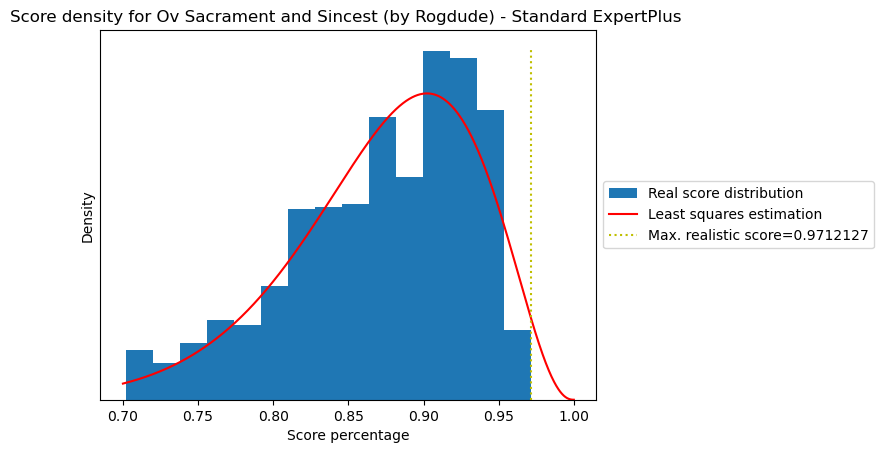

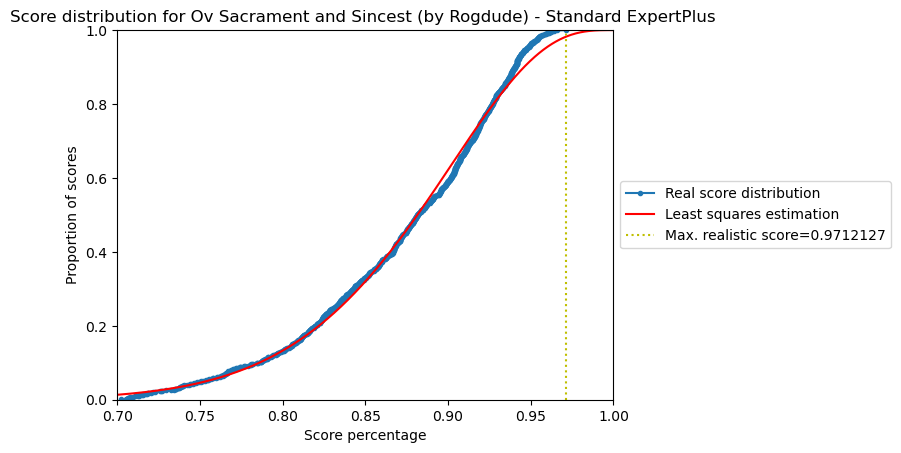

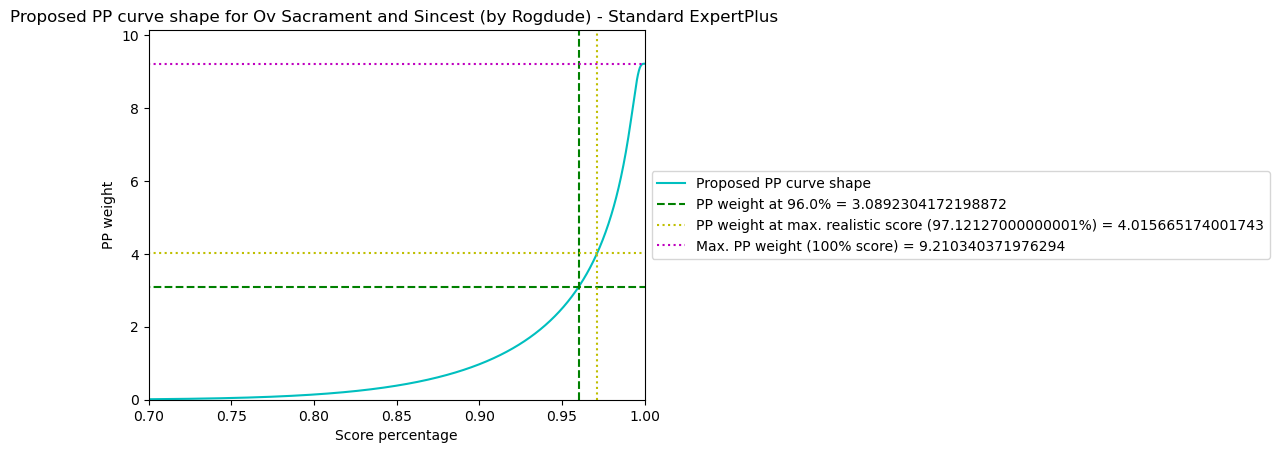

{'Hash': '547d15e033e7c3480428d3a0508f1b7ce50da5d6', 'Name': '666', 'CoverImage': 'https://na.cdn.beatsaver.com/547d15e033e7c3480428d3a0508f1b7ce50da5d6.jpg', 'Mapper': 'ComplexFrequency & Narwhal', 'Id': '2ee3bxxxxxx91', 'SongId': '2ee3bxxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.862437, 'PassRating': 12.594467, 'TechRating': 8.803961, 'PredictedAcc': 0.9643922, 'ModifiersRating': {'Id': 1098426, 'SSPredictedAcc': 0.96637076, 'SSPassRating': 10.578978, 'SSAccRating': 12.494317, 'SSTechRating': 8.6788, 'SSStars': 13.022665, 'FSPredictedAcc': 0.96192956, 'FSPassRating': 15.413415, 'FSAccRating': 13.305814, 'FSTechRating': 8.986385, 'FSStars': 15.9848585, 'SFPredictedAcc': 0.957942, 'SFPassRating': 20.558159, 'SFAccRating': 13.940844, 'SFTechRating': 9.587521, 'SFStars': 19.491306, 'BFSPredictedAcc': 0.95723855, 'BFSPassRating': 16.56289, 'BFSAccRating': 13.699425, 'BFSTechRating': 9.150749, 'BFSStars': 16.974865, 'BSFPredictedAcc': 0.95135593, 'BSFPa

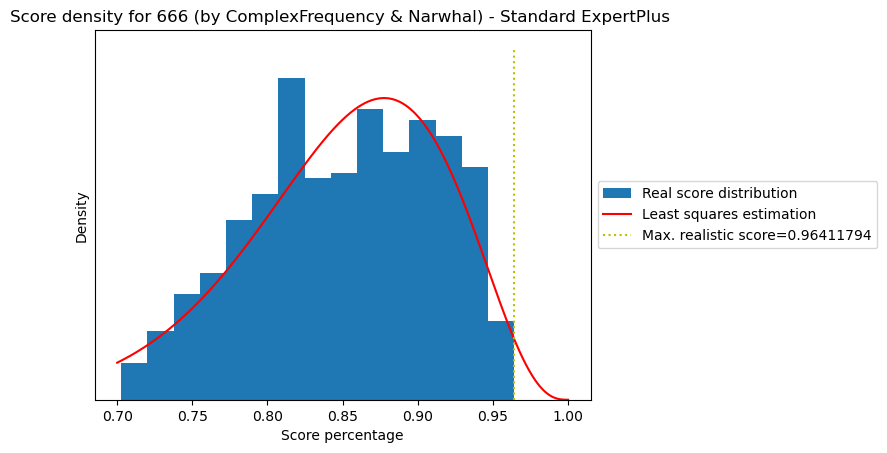

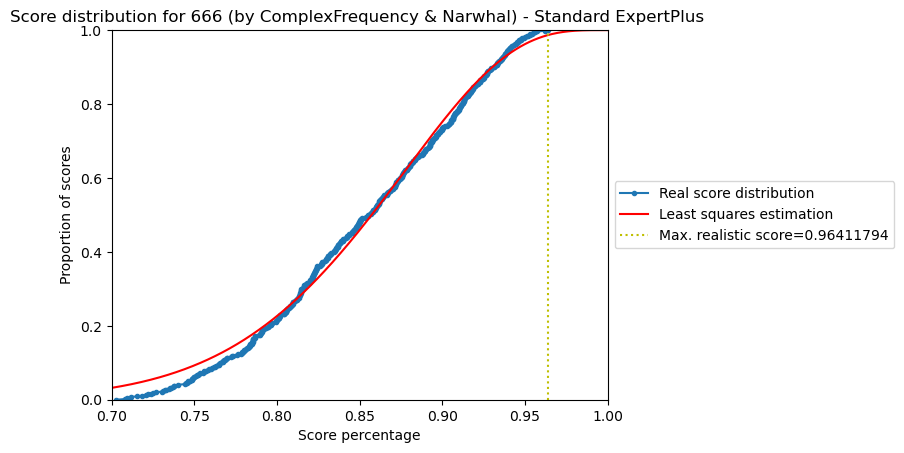

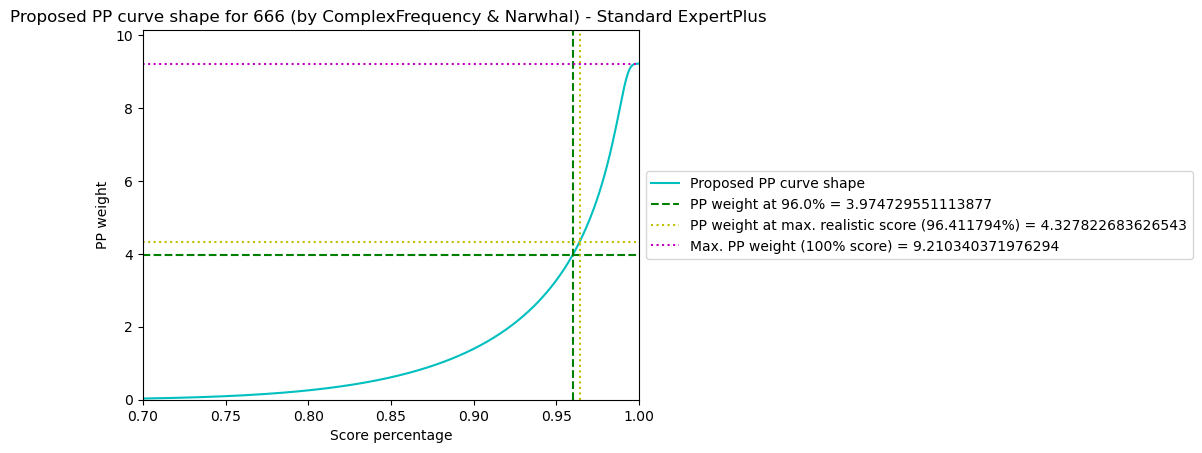

{'Hash': '4963752d07b806f9b0028d0015dc7e65bb74a1c8', 'Name': 'Quiet Water', 'CoverImage': 'https://eu.cdn.beatsaver.com/4963752d07b806f9b0028d0015dc7e65bb74a1c8.jpg', 'Mapper': 'Whiisper', 'Id': '7e8f11', 'SongId': '7e8f', 'ModeName': 'Standard', 'DifficultyName': 'Easy', 'AccRating': 1.849692, 'PassRating': 0.017607981, 'TechRating': 0.006381757, 'PredictedAcc': 0.9972797, 'ModifiersRating': {'Id': 8598, 'SSPredictedAcc': 0.997525, 'SSPassRating': 0.012998902, 'SSAccRating': 1.7740775, 'SSTechRating': 0.004714915, 'SSStars': 0.63929594, 'FSPredictedAcc': 0.99700767, 'FSPassRating': 0.024645664, 'FSAccRating': 1.9414564, 'FSTechRating': 0.008921906, 'FSStars': 0.7191181, 'SFPredictedAcc': 0.9965727, 'SFPassRating': 0.036929652, 'SFAccRating': 2.0723765, 'SFTechRating': 0.013341245, 'SFStars': 0.78312385, 'BFSPredictedAcc': 0.9972922, 'BFSPassRating': 0.0285304, 'BFSAccRating': 2.1983514, 'BFSTechRating': 0.01032147, 'BFSStars': 0.84522176, 'BSFPredictedAcc': 0.9969696, 'BSFPassRating':

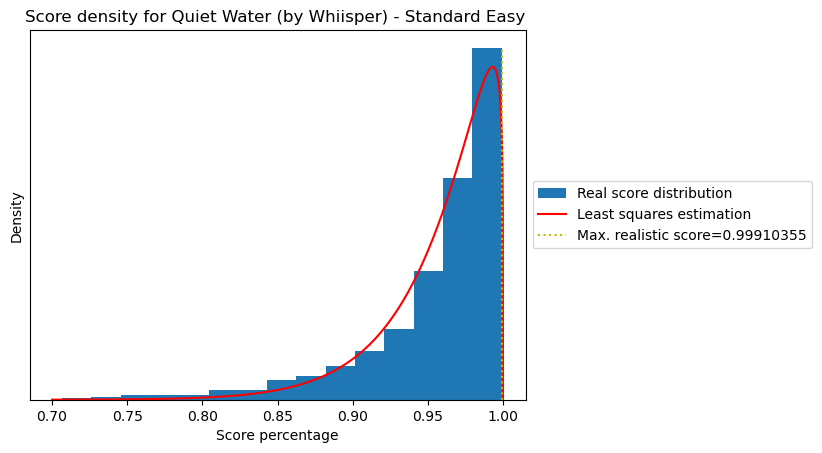

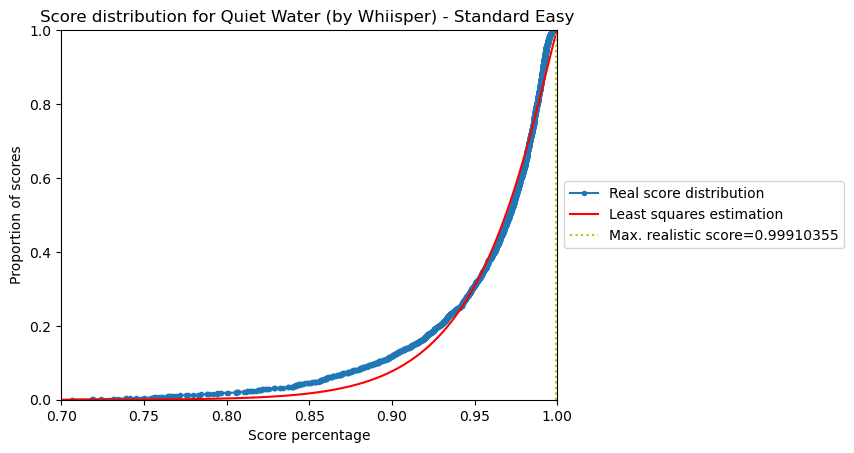

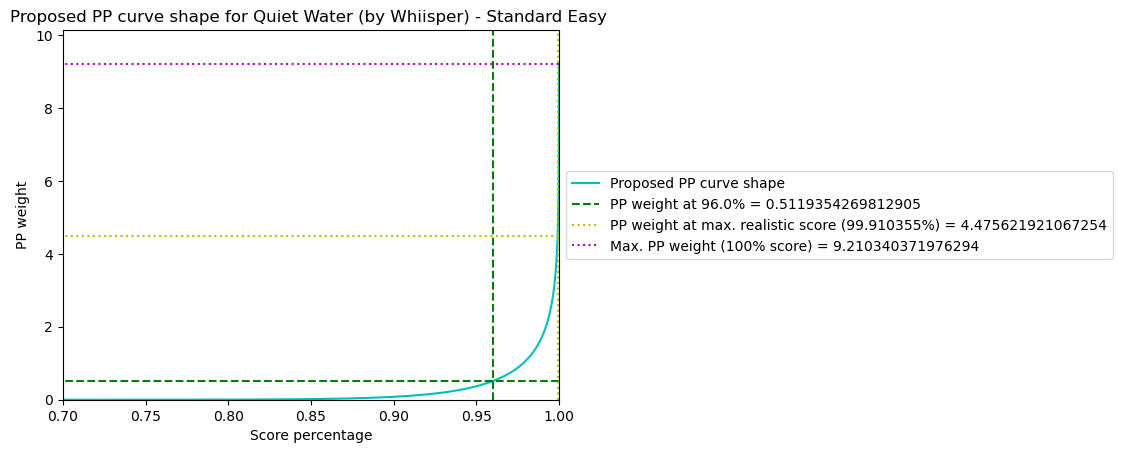

{'Hash': 'b97774a83bdfd669e1bd231039cccfa1162efa13', 'Name': 'Accelerate', 'CoverImage': 'https://na.cdn.beatsaver.com/b97774a83bdfd669e1bd231039cccfa1162efa13.jpg', 'Mapper': 'GalaxyMaster & Phøenix', 'Id': '36bce91', 'SongId': '36bce', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 13.033914, 'PassRating': 10.752386, 'TechRating': 11.006353, 'PredictedAcc': 0.9635087, 'ModifiersRating': {'Id': 1040275, 'SSPredictedAcc': 0.96533877, 'SSPassRating': 8.980194, 'SSAccRating': 12.683652, 'SSTechRating': 10.758843, 'SSStars': 12.929366, 'FSPredictedAcc': 0.9612418, 'FSPassRating': 13.06871, 'FSAccRating': 13.411184, 'FSTechRating': 11.170669, 'FSStars': 15.3816395, 'SFPredictedAcc': 0.957935, 'SFPassRating': 16.974102, 'SFAccRating': 13.942015, 'SFTechRating': 11.603688, 'SFStars': 17.873146, 'BFSPredictedAcc': 0.9577731, 'BFSPassRating': 13.354142, 'BFSAccRating': 13.627579, 'BFSTechRating': 11.4032135, 'BFSStars': 15.762796, 'BSFPredictedAcc': 0.95211947, 'BSFPassRa

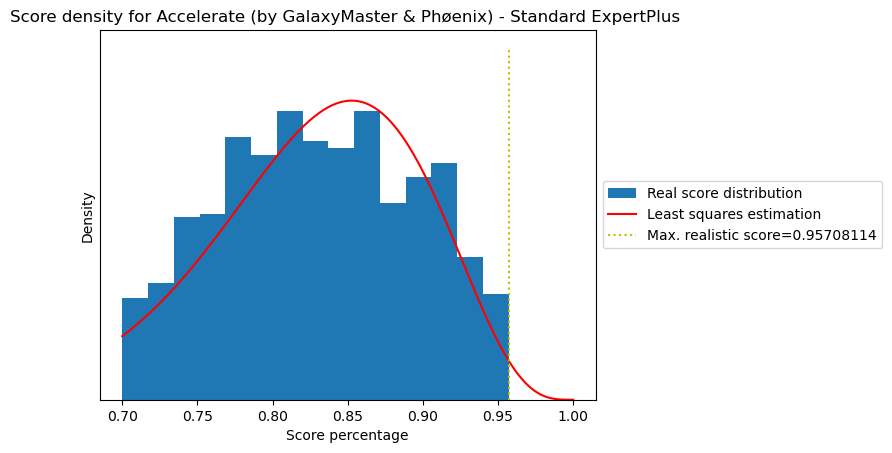

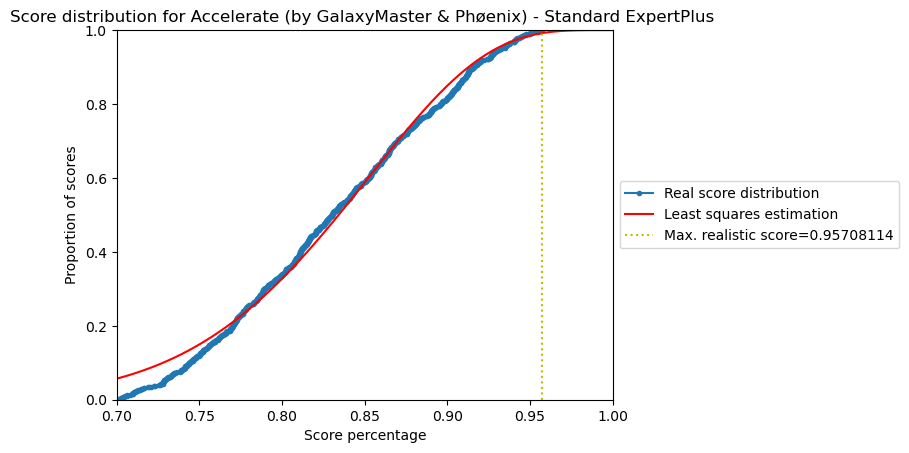

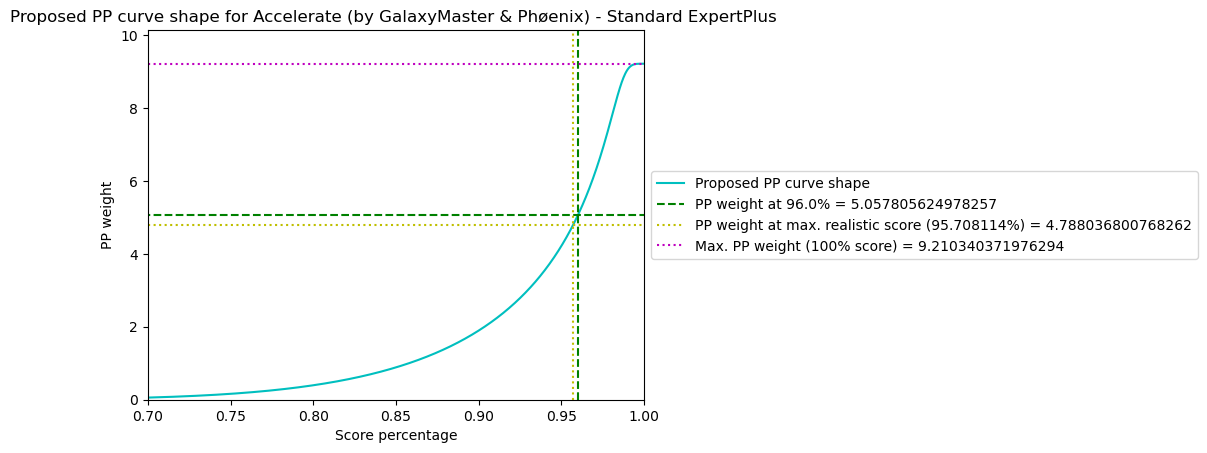

{'Hash': 'C2A5083F21B656EA2B5DB5F689240C39774F8119', 'Name': 'Ludicrous Speed', 'CoverImage': 'https://eu.cdn.beatsaver.com/c2a5083f21b656ea2b5db5f689240c39774f8119.jpg', 'Mapper': 'Helloiamdaan, cerret & Olaf', 'Id': '1f6b1xxxxxxxx91', 'SongId': '1f6b1xxxxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.938913, 'PassRating': 13.142659, 'TechRating': 2.4304786, 'PredictedAcc': 0.9691477, 'ModifiersRating': {'Id': 7560, 'SSPredictedAcc': 0.9718953, 'SSPassRating': 11.079212, 'SSAccRating': 11.270875, 'SSTechRating': 2.4008696, 'SSStars': 11.051611, 'FSPredictedAcc': 0.96566355, 'FSPassRating': 16.416653, 'FSAccRating': 12.623446, 'FSTechRating': 2.5362573, 'FSStars': 14.677316, 'SFPredictedAcc': 0.96031415, 'SFPassRating': 21.935665, 'SFAccRating': 13.555963, 'SFTechRating': 2.7149062, 'SFStars': 18.654512, 'BFSPredictedAcc': 0.96223223, 'BFSPassRating': 17.520617, 'BFSAccRating': 12.936552, 'BFSTechRating': 2.5808072, 'BFSStars': 15.54242, 'BSFPredictedAcc

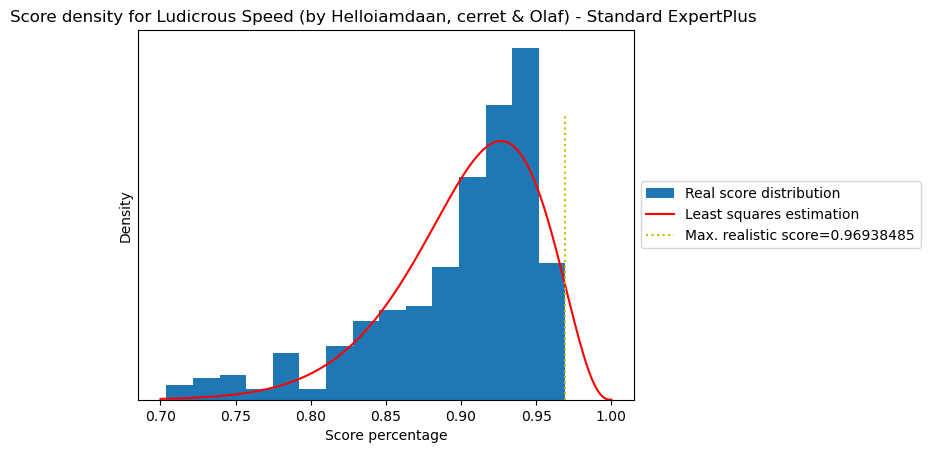

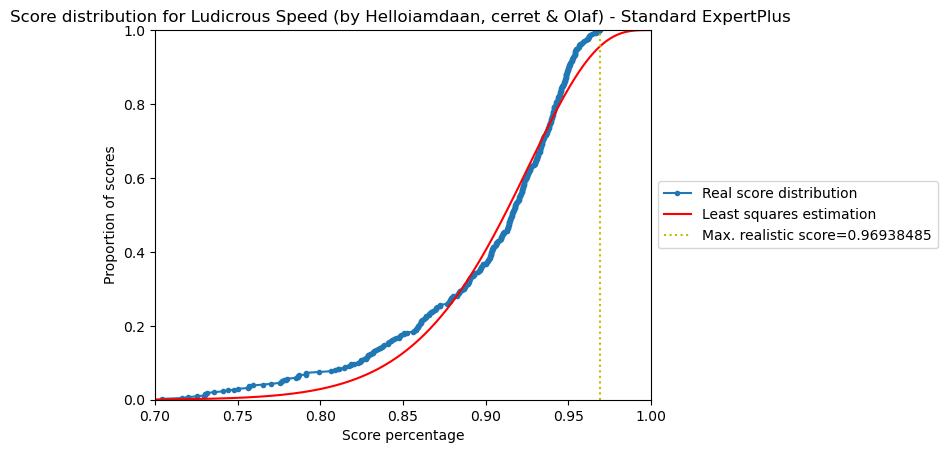

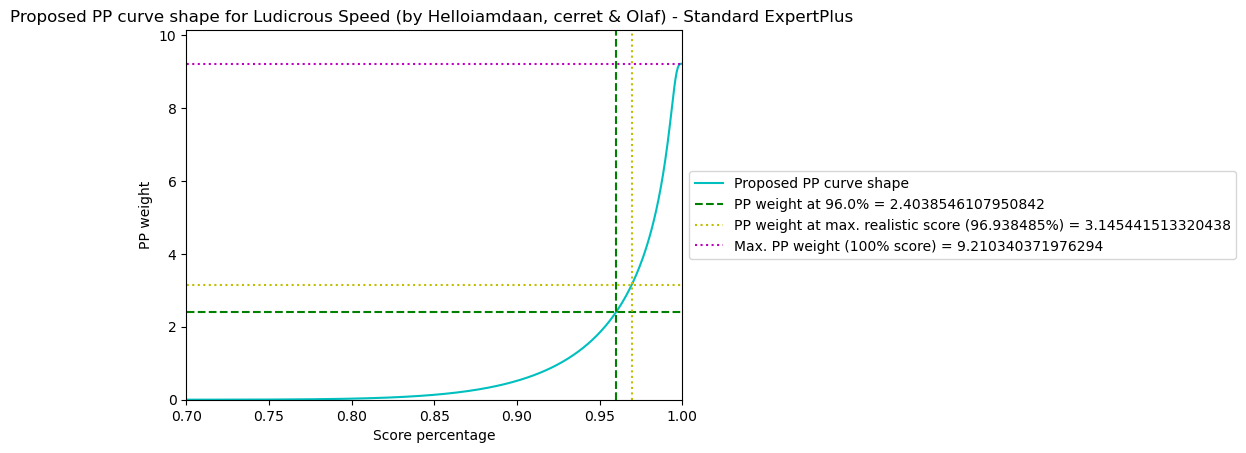

{'Hash': 'C3CFED196F96B161C0862EC387E0EE9241CD5B48', 'Name': 'Novablast', 'CoverImage': 'https://eu.cdn.beatsaver.com/c3cfed196f96b161c0862ec387e0ee9241cd5b48.jpg', 'Mapper': 'Bitz, Cokeinjector, Luck & Sync', 'Id': '23596xxx91', 'SongId': '23596xxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.352792, 'PassRating': 9.229344, 'TechRating': 7.588059, 'PredictedAcc': 0.9671628, 'ModifiersRating': {'Id': 7756, 'SSPredictedAcc': 0.9692271, 'SSPassRating': 7.654591, 'SSAccRating': 11.921572, 'SSTechRating': 7.3393674, 'SSStars': 11.174194, 'FSPredictedAcc': 0.9645801, 'FSPassRating': 11.283625, 'FSAccRating': 12.826547, 'FSTechRating': 7.7656817, 'FSStars': 13.466044, 'SFPredictedAcc': 0.96068, 'SFPassRating': 15.15156, 'SFAccRating': 13.498491, 'SFTechRating': 8.351992, 'SFStars': 15.935818, 'BFSPredictedAcc': 0.961079, 'BFSPassRating': 12.113143, 'BFSAccRating': 13.108646, 'BFSTechRating': 8.013302, 'BFSStars': 14.123602, 'BSFPredictedAcc': 0.954904, 'BSFPassRa

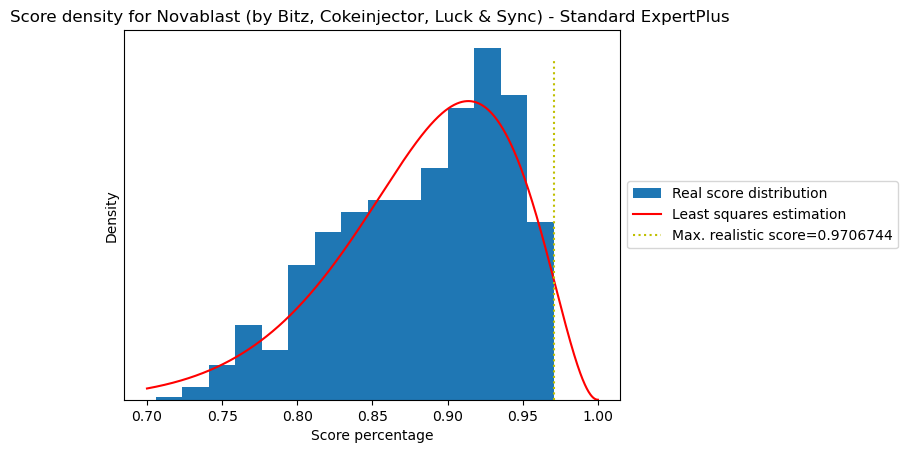

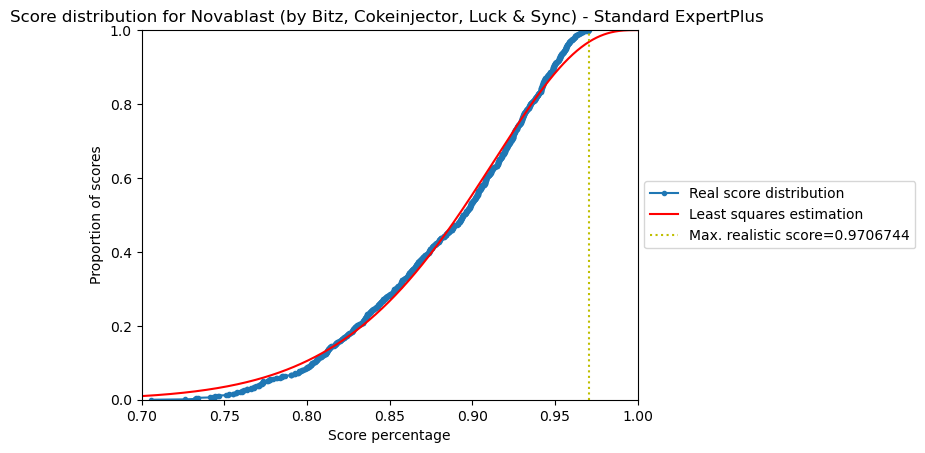

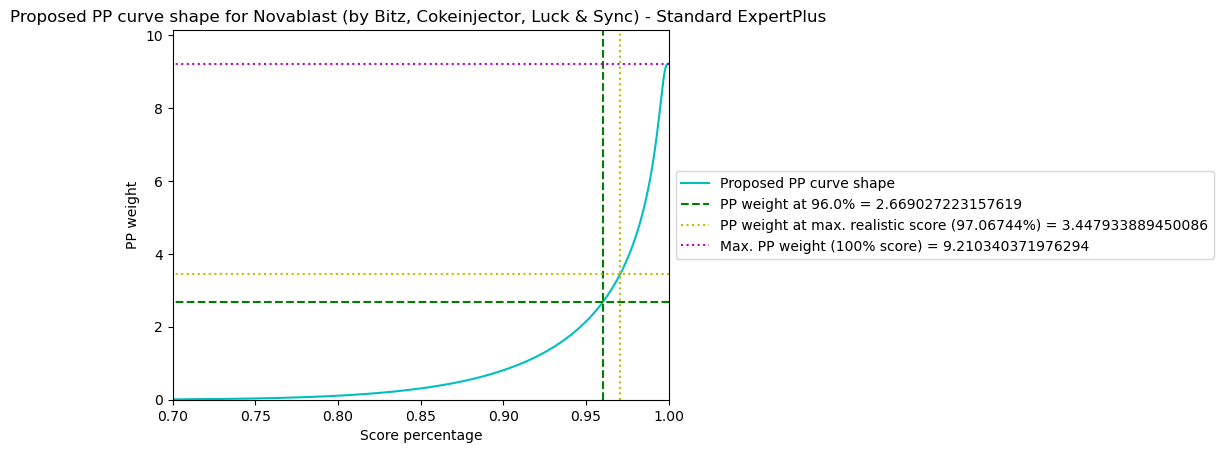

{'Hash': '9A33B85AF39D74C590036E9E8E92060B4FDEDFBD', 'Name': '""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""', 'CoverImage': 'https://eu.cdn.beatsaver.com/9a33b85af39d74c590036e9e8e92060b4fdedfbd.jpg', 'Mapper': 'Vilawes', 'Id': '2cf6391', 'SongId': '2cf63', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 8.789539, 'PassRating': 15.426448, 'TechRating': 1.953545, 'PredictedAcc': 0.9779913, 'ModifiersRating': {'Id': 8284, 'SSPredictedAcc': 0.98016113, 'SSPassRating': 13.070849, 'SSAccRating': 8.068162, 'SSTechRating': 1.9403174, 'SSStars': 8.933409, 'FSPredictedAcc': 0.9752563, 'FSPassRating': 18.985346, 'FSAccRating': 9.631505, 'FSTechRating': 2.0077035, 'FSStars': 13.027602, 'SFPredictedAcc': 0.9713166, 'SFPassRating': 25.277428, 'SFAccRating': 10.647221, 'SFTechRating': 2.1404138, 'SFStars': 17.717543, 'BFSPredictedAcc': 0.9716948, 'BFSPassRating': 19.562475, 'BFSAccRating': 11.045979, 'BFSTechRating': 2.0432973, 'BFSStars': 14.683779, 'BSFP

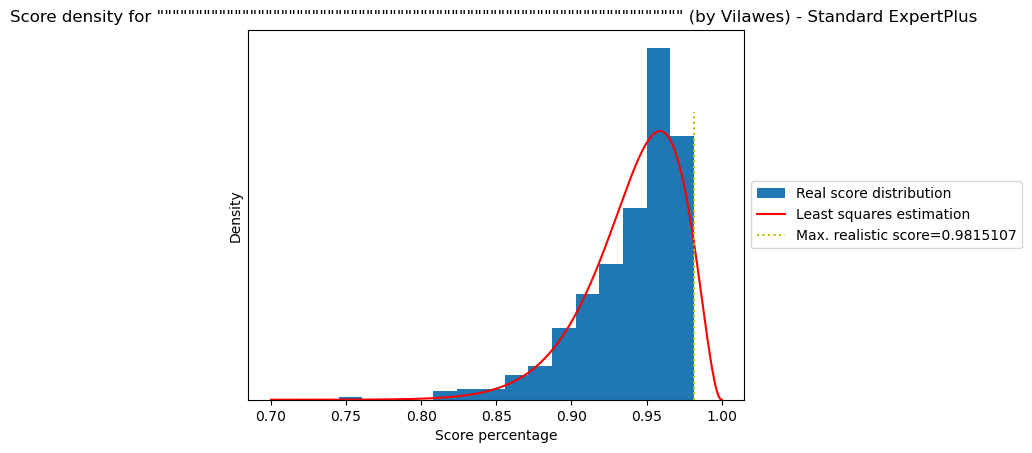

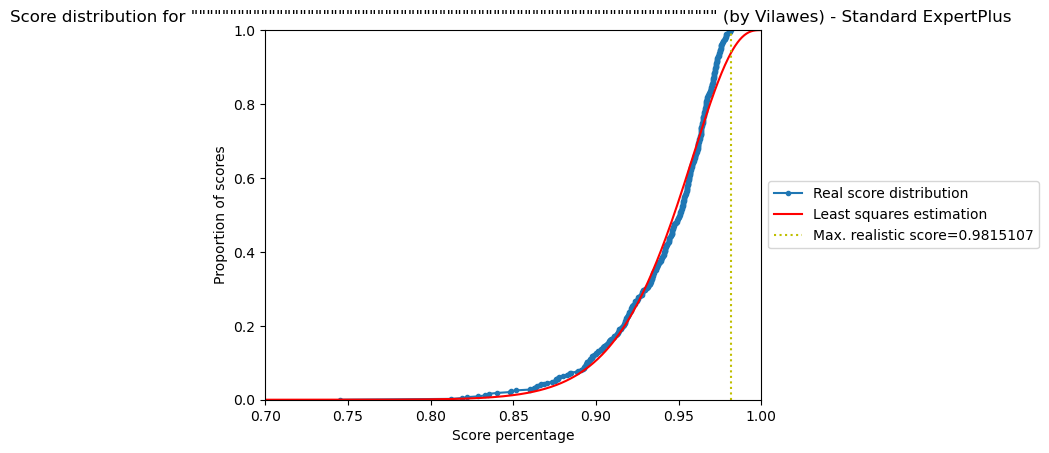

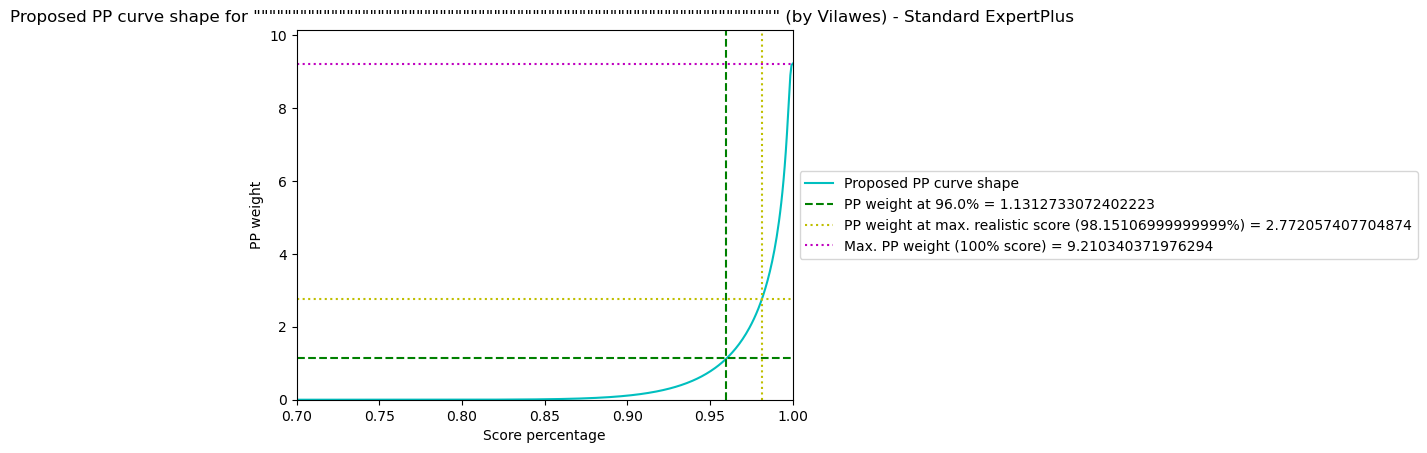

{'Hash': '2712a515d8fefb9c06cd0f8fb7021e7d5da3f2d1', 'Name': 'Dual Doom Deathmatch', 'CoverImage': 'https://cdn.beatsaver.com/2712a515d8fefb9c06cd0f8fb7021e7d5da3f2d1.jpg', 'Mapper': 'Blackjack', 'Id': '3e2c2xxxxx91', 'SongId': '3e2c2xxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 13.393936, 'PassRating': 13.197565, 'TechRating': 11.08773, 'PredictedAcc': 0.9613536, 'ModifiersRating': {'Id': 1233026, 'SSPredictedAcc': 0.96317434, 'SSPassRating': 11.116317, 'SSAccRating': 13.100003, 'SSTechRating': 10.953567, 'SSStars': 14.2033825, 'FSPredictedAcc': 0.9591188, 'FSPassRating': 15.936348, 'FSAccRating': 13.747217, 'FSTechRating': 11.167368, 'FSStars': 17.069088, 'SFPredictedAcc': 0.95562214, 'SFPassRating': 21.203966, 'SFAccRating': 14.269415, 'SFTechRating': 11.879003, 'SFStars': 20.647152, 'BFSPredictedAcc': 0.95505947, 'BFSPassRating': 16.6403, 'BFSAccRating': 14.000344, 'BFSTechRating': 11.416222, 'BFSStars': 17.725101, 'BSFPredictedAcc': 0.94912535, 'BSFP

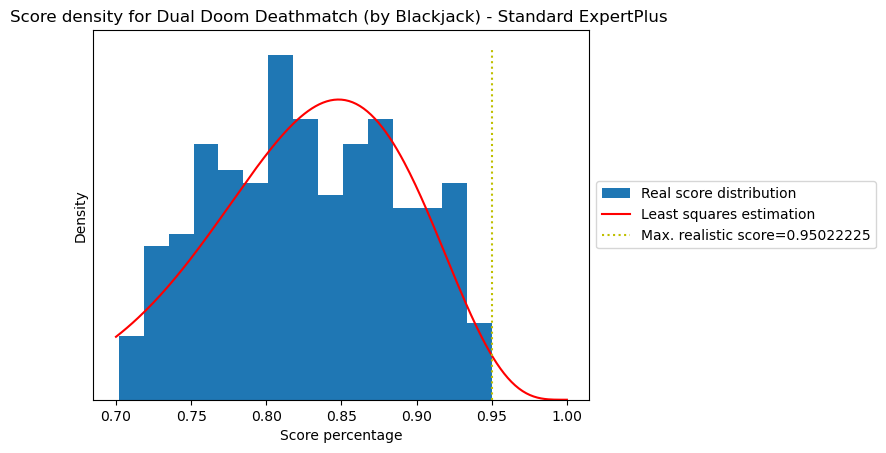

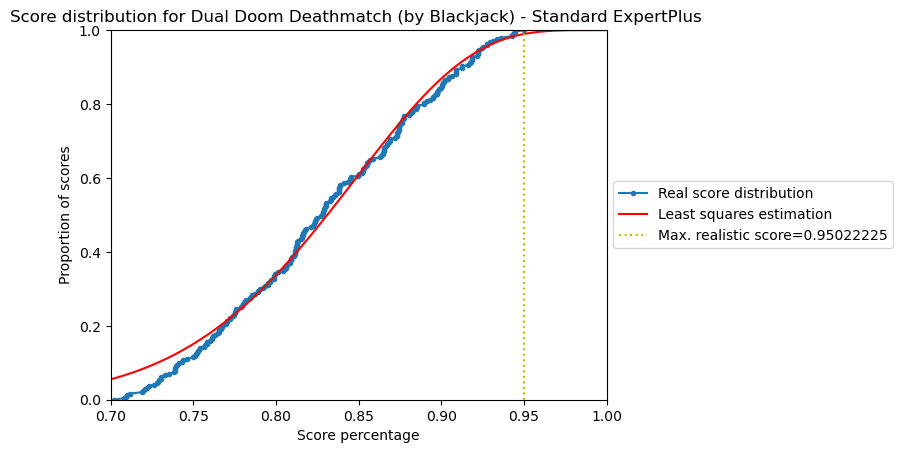

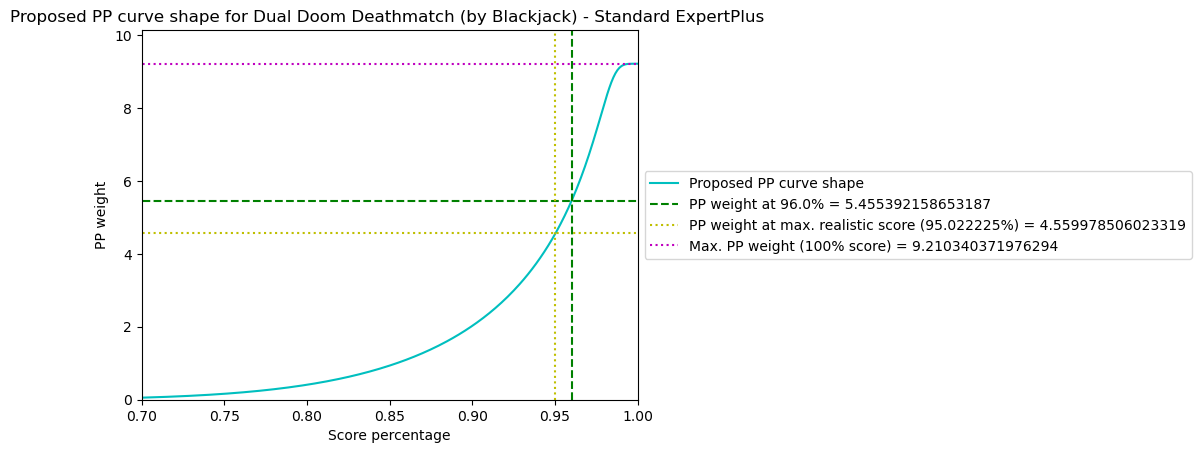

{'Hash': '187bea15de6bd730123917f889c2690a1500433c', 'Name': 'nieuwe tune', 'CoverImage': 'https://cdn.beatsaver.com/187bea15de6bd730123917f889c2690a1500433c.jpg', 'Mapper': 'Stupidity-101', 'Id': '3bcf5xxxxxxxx91', 'SongId': '3bcf5xxxxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.55551, 'PassRating': 13.282304, 'TechRating': 10.852338, 'PredictedAcc': 0.96603376, 'ModifiersRating': {'Id': 1222925, 'SSPredictedAcc': 0.967761, 'SSPassRating': 11.160863, 'SSAccRating': 12.248008, 'SSTechRating': 10.721307, 'SSStars': 13.371577, 'FSPredictedAcc': 0.9637907, 'FSPassRating': 16.06466, 'FSAccRating': 12.978677, 'FSTechRating': 10.928797, 'FSStars': 16.326294, 'SFPredictedAcc': 0.9603623, 'SFPassRating': 21.243496, 'SFAccRating': 13.548368, 'SFTechRating': 11.541488, 'SFStars': 19.858559, 'BFSPredictedAcc': 0.9608965, 'BFSPassRating': 16.882214, 'BFSAccRating': 13.1363, 'BFSTechRating': 11.120437, 'BFSStars': 16.92973, 'BSFPredictedAcc': 0.955367, 'BSFPassRati

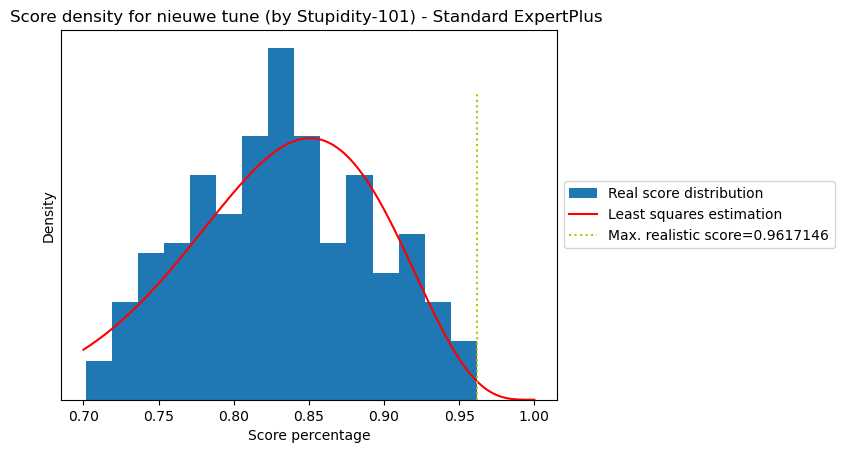

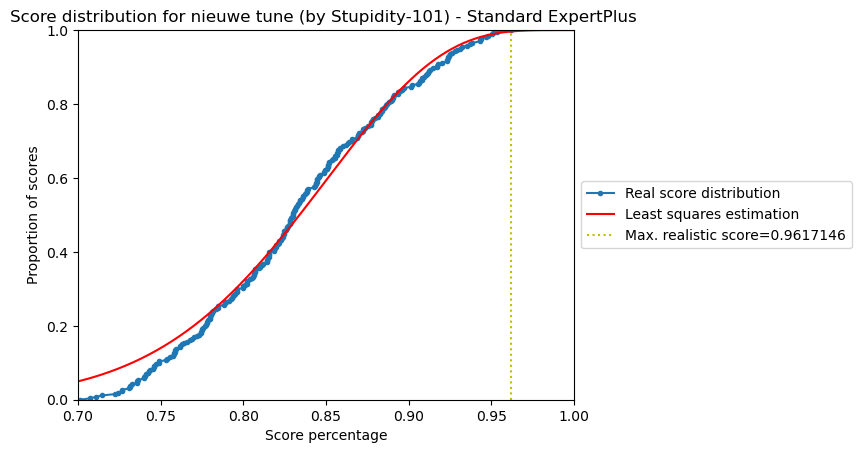

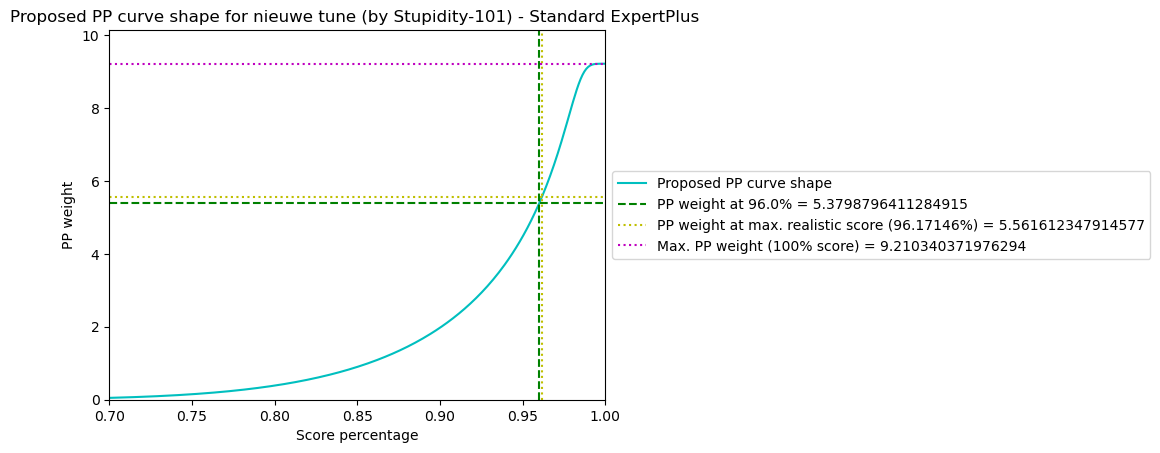

{'Hash': '495E4FB9D9460900A0433E11CA8BDBD3BB8DD471', 'Name': 'ANOTHER HIM', 'CoverImage': 'https://eu.cdn.beatsaver.com/495e4fb9d9460900a0433e11ca8bdbd3bb8dd471.jpg', 'Mapper': 'Phøenix', 'Id': '2a57111', 'SongId': '2a571', 'ModeName': 'Standard', 'DifficultyName': 'Easy', 'AccRating': 2.3616474, 'PassRating': 0.032721817, 'TechRating': 0.058093388, 'PredictedAcc': 0.9959079, 'ModifiersRating': {'Id': 8131, 'SSPredictedAcc': 0.9961961, 'SSPassRating': 0.024133362, 'SSAccRating': 2.2770023, 'SSTechRating': 0.04290754, 'SSStars': 0.887669, 'FSPredictedAcc': 0.9955365, 'FSPassRating': 0.045856256, 'FSAccRating': 2.480489, 'FSTechRating': 0.0812326, 'FSStars': 0.99536645, 'SFPredictedAcc': 0.9949858, 'SFPassRating': 0.06882976, 'SFAccRating': 2.6363578, 'SFTechRating': 0.12146045, 'SFStars': 1.0807717, 'BFSPredictedAcc': 0.99603415, 'BFSPassRating': 0.046950806, 'BFSAccRating': 2.6371045, 'BFSTechRating': 0.08315628, 'BFSStars': 1.0775249, 'BSFPredictedAcc': 0.9956299, 'BSFPassRating': 0.0

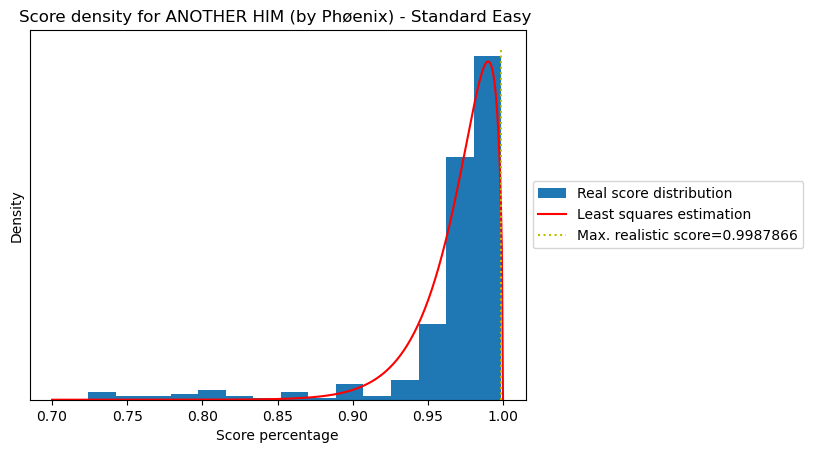

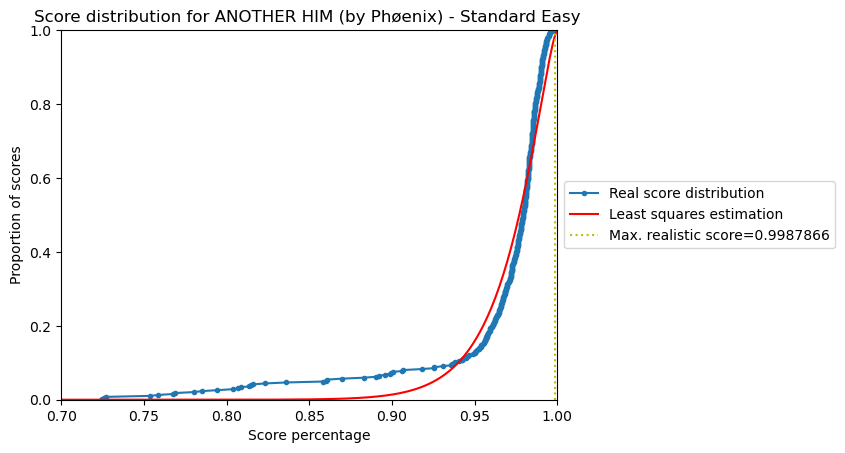

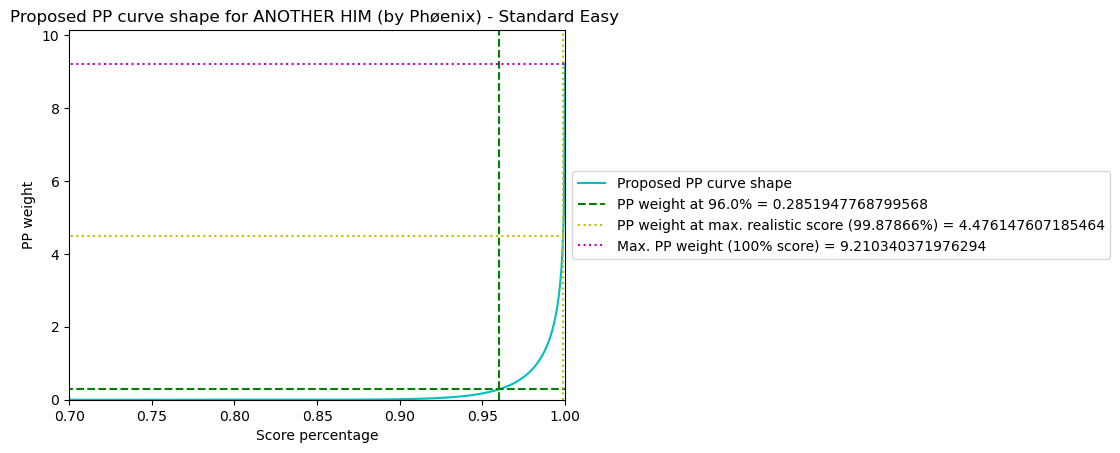

{'Hash': '3EB725A7D0343654527475369AE950A6AB8154F7', 'Name': 'Atomic', 'CoverImage': 'https://eu.cdn.beatsaver.com/3eb725a7d0343654527475369ae950a6ab8154f7.jpg', 'Mapper': 'A Jhintleman & GojiCrafter', 'Id': '220f2xxx91', 'SongId': '220f2xxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.762368, 'PassRating': 4.356675, 'TechRating': 10.134479, 'PredictedAcc': 0.9699667, 'ModifiersRating': {'Id': 7721, 'SSPredictedAcc': 0.9711831, 'SSPassRating': 3.495524, 'SSAccRating': 11.455069, 'SSTechRating': 9.112044, 'SSStars': 9.664208, 'FSPredictedAcc': 0.9683302, 'FSPassRating': 5.5124326, 'FSAccRating': 12.120489, 'FSTechRating': 11.114587, 'FSStars': 11.233856, 'SFPredictedAcc': 0.9660025, 'SFPassRating': 7.45235, 'SFAccRating': 12.56122, 'SFTechRating': 12.382359, 'SFStars': 12.522653, 'BFSPredictedAcc': 0.966374, 'BFSPassRating': 5.740912, 'BFSAccRating': 12.189007, 'BFSTechRating': 11.378487, 'BFSStars': 11.416256, 'BSFPredictedAcc': 0.96260864, 'BSFPassRating':

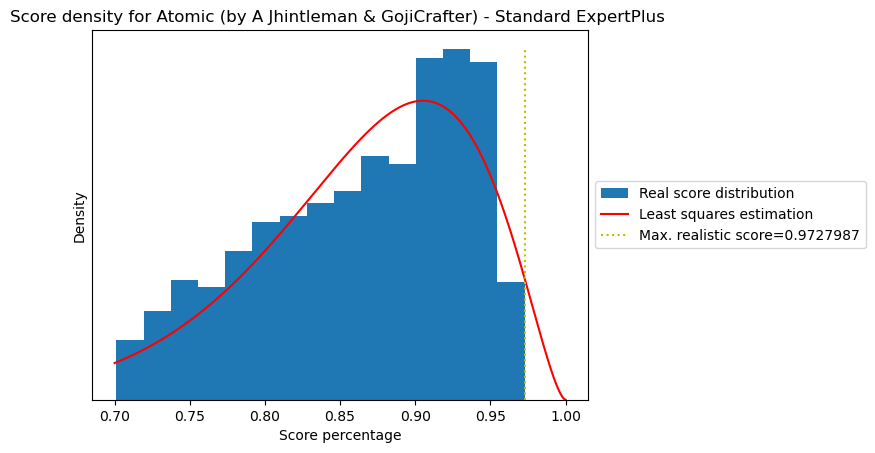

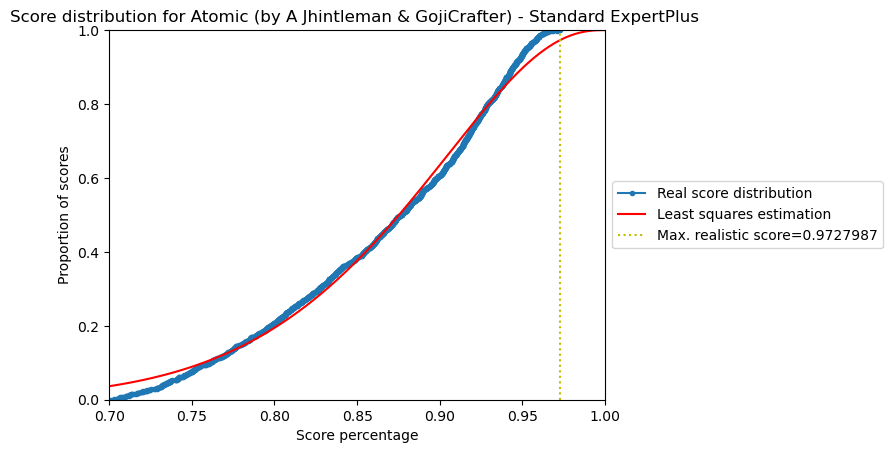

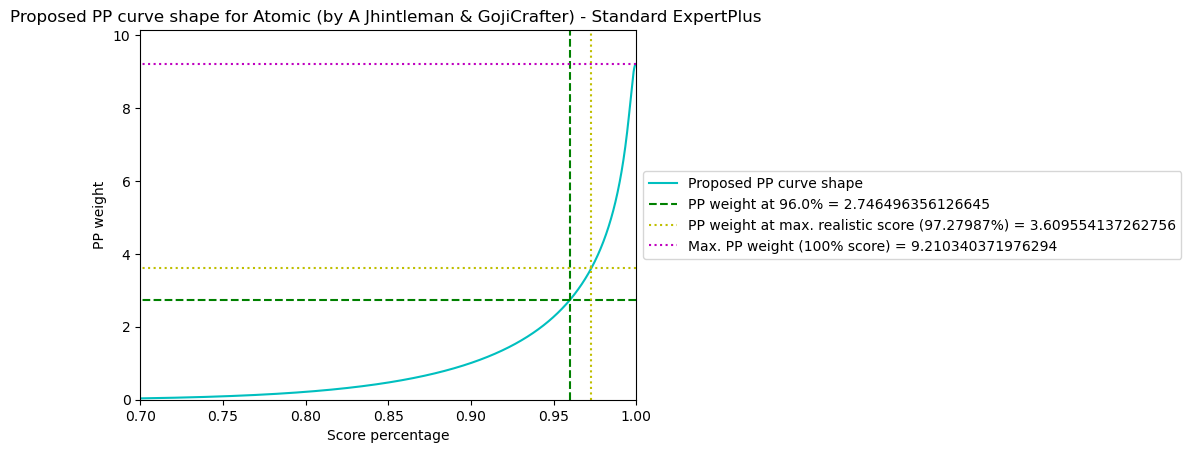

{'Hash': '848e58c44755966c9265c3e1021db6d9e679c9cb', 'Name': 'heaven', 'CoverImage': 'https://cdn.beatsaver.com/848e58c44755966c9265c3e1021db6d9e679c9cb.jpg', 'Mapper': 'UglyApe', 'Id': '3963ex92', 'SongId': '3963ex', 'ModeName': 'OneSaber', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.596535, 'PassRating': 6.947315, 'TechRating': 10.197642, 'PredictedAcc': 0.9688082, 'ModifiersRating': {'Id': 1153625, 'SSPredictedAcc': 0.96990126, 'SSPassRating': 5.8011007, 'SSAccRating': 11.367393, 'SSTechRating': 9.684717, 'SSStars': 10.421305, 'FSPredictedAcc': 0.9676286, 'FSPassRating': 8.45135, 'FSAccRating': 11.844977, 'FSTechRating': 10.630499, 'FSStars': 11.9317665, 'SFPredictedAcc': 0.9661287, 'SFPassRating': 11.15212, 'SFAccRating': 12.102866, 'SFTechRating': 11.470247, 'SFStars': 13.358196, 'BFSPredictedAcc': 0.96478033, 'BFSPassRating': 9.799537, 'BFSAccRating': 12.476607, 'BFSTechRating': 10.910571, 'BFSStars': 13.075837, 'BSFPredictedAcc': 0.9611753, 'BSFPassRating': 12.726621, 'BSFAc

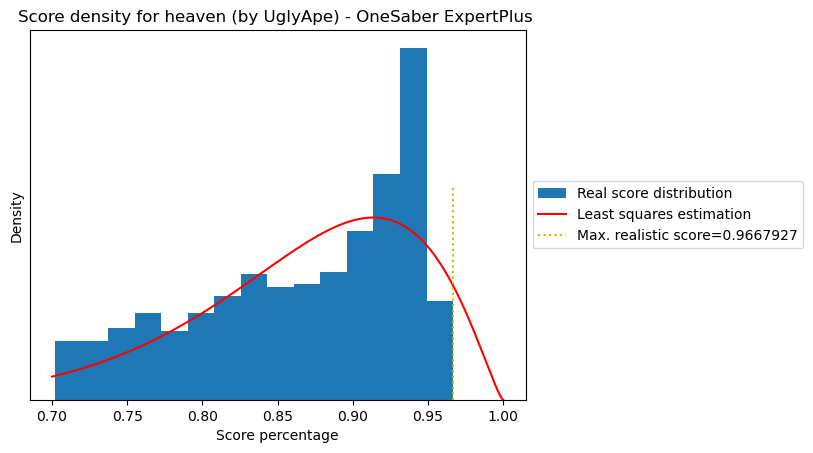

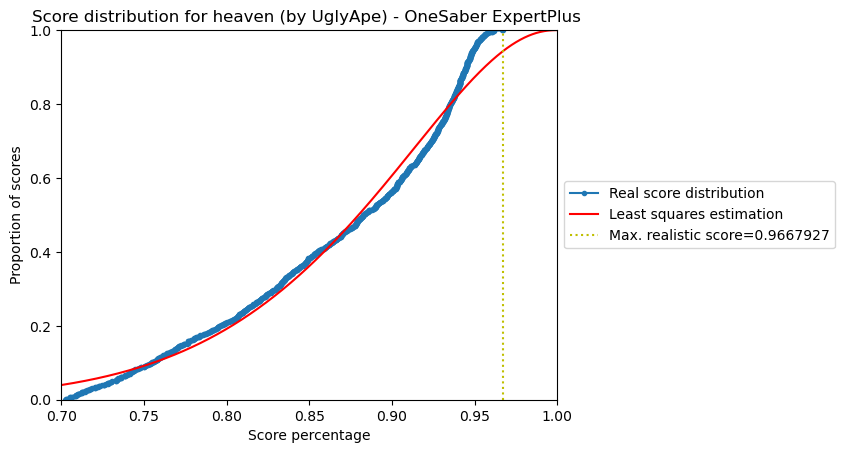

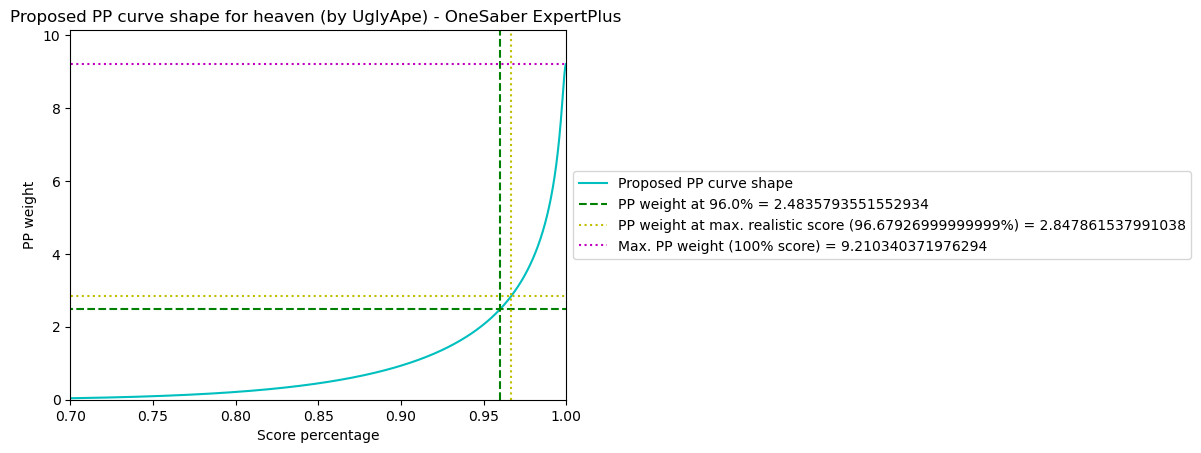

{'Hash': 'ed1a3273b99d5f0b0cd61a1d42cbe02de11fe0c8', 'Name': 'Scream', 'CoverImage': 'https://na.cdn.beatsaver.com/ed1a3273b99d5f0b0cd61a1d42cbe02de11fe0c8.jpg', 'Mapper': 'Serephor, CMP1111, LaidBackAries', 'Id': '38419x91', 'SongId': '38419x', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 10.3140135, 'PassRating': 3.5834234, 'TechRating': 8.042309, 'PredictedAcc': 0.9753135, 'ModifiersRating': {'Id': 1132570, 'SSPredictedAcc': 0.97667176, 'SSPassRating': 2.872866, 'SSAccRating': 9.854296, 'SSTechRating': 7.1137333, 'SSStars': 7.7946877, 'FSPredictedAcc': 0.97369045, 'FSPassRating': 4.5441246, 'FSAccRating': 10.775066, 'FSTechRating': 8.991936, 'FSStars': 9.382673, 'SFPredictedAcc': 0.97149974, 'SFPassRating': 6.08231, 'SFAccRating': 11.372445, 'SFTechRating': 10.10108, 'SFStars': 10.586478, 'BFSPredictedAcc': 0.9745814, 'BFSPassRating': 4.6645627, 'BFSAccRating': 10.261094, 'BFSTechRating': 9.076766, 'BFSStars': 8.988707, 'BSFPredictedAcc': 0.9710023, 'BSFPassR

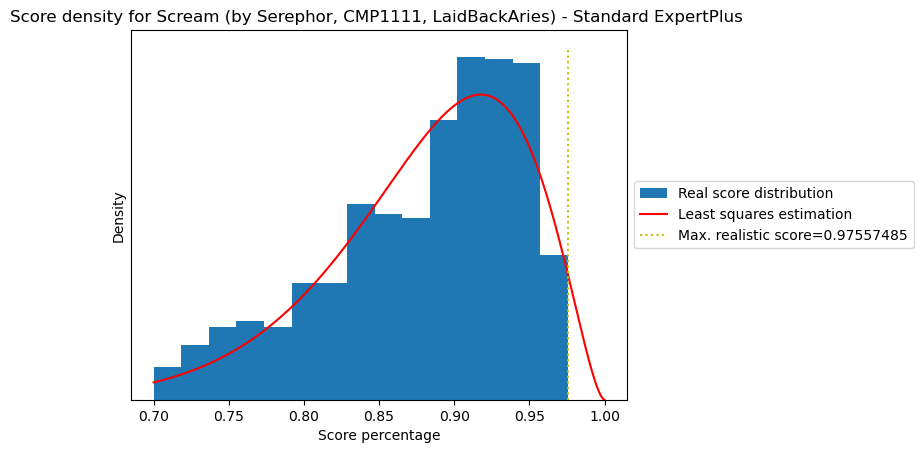

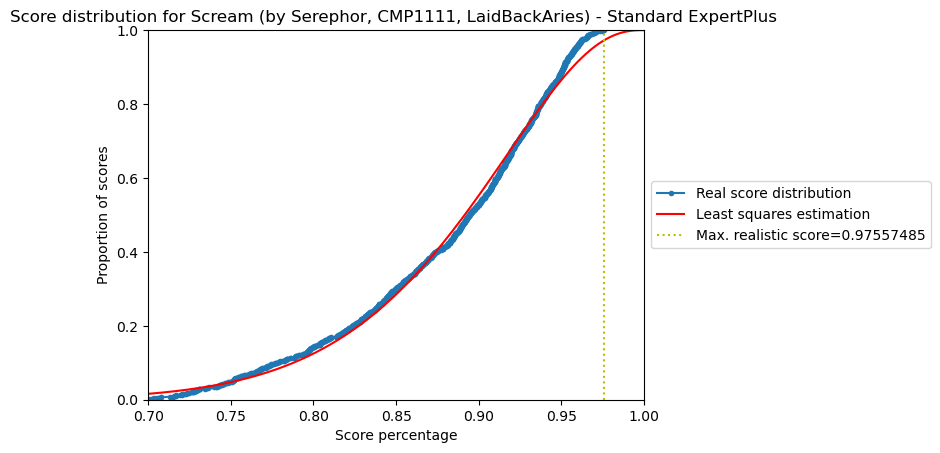

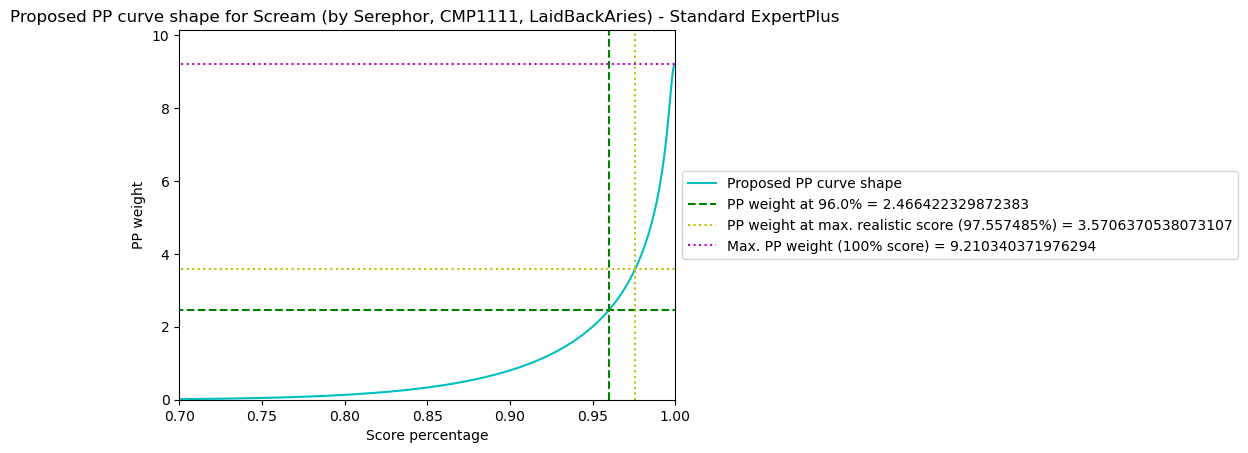

In [29]:
# Some well known maps
golden_standard_map_ids = ["c32d91","2ee3bxxxxxx91","7e8f11","36bce91","1f6b1xxxxxxxx91","23596xxx91","2cf6391","3e2c2xxxxx91","3bcf5xxxxxxxx91","2a57111","220f2xxx91","3963ex92","38419x91"]

for map_id in golden_standard_map_ids:
    map_summary(map_id)

## Main algorithm

In [187]:
#initial_player_skills = {player_id:random.random() for player_id in scores_by_player_id}
initial_player_skills = {player_id:0.5 for player_id in scores_by_player_id}

model = BetaSaberBiRating(maps_by_id,
                          scores_by_map_id,
                          scores_by_player_id,
                          least_squares_beta_parameters_per_map,
                          initial_player_skills,
                          debug=True,
                          metrics_each_iteration=False,
                          max_iter=25)

#model.iterate()
#model.bcycle()
#model.acycle()
model.run()
metrics = model.calculate_metrics()

B cycle starting
5000 B nodes processed
10000 B nodes processed
15000 B nodes processed
20000 B nodes processed
25000 B nodes processed
30000 B nodes processed
35000 B nodes processed
40000 B nodes processed
45000 B nodes processed
50000 B nodes processed
55000 B nodes processed
60000 B nodes processed
65000 B nodes processed
70000 B nodes processed
75000 B nodes processed
80000 B nodes processed
85000 B nodes processed
90000 B nodes processed
A cycle starting
500 A nodes processed
1000 A nodes processed
1500 A nodes processed
2000 A nodes processed
2500 A nodes processed
3000 A nodes processed
3500 A nodes processed
Metrics iteration
1 iterations complete
B cycle starting
5000 B nodes processed
10000 B nodes processed
15000 B nodes processed
20000 B nodes processed
25000 B nodes processed
30000 B nodes processed
35000 B nodes processed
40000 B nodes processed
45000 B nodes processed
50000 B nodes processed
55000 B nodes processed
60000 B nodes processed
65000 B nodes processed
70000 B

In [51]:
model.bcycle()

In [55]:
model.acycle()

In [ ]:
model.bcycle()
model.acycle()

In [208]:
metrics = model.calculate_metrics()

Beginning to calculate metrics
50 measured
100 measured
150 measured
200 measured
250 measured
300 measured
350 measured
400 measured
450 measured
500 measured
550 measured
600 measured
650 measured
700 measured
750 measured
800 measured
850 measured
900 measured
950 measured
1000 measured
1050 measured
1100 measured
1150 measured
1200 measured
1250 measured
1300 measured
1350 measured
1400 measured
1450 measured
1500 measured
1550 measured
1600 measured
1650 measured
1700 measured
1750 measured
1800 measured
1850 measured
1900 measured
1950 measured
2000 measured
2050 measured
2100 measured
2150 measured
2200 measured
2250 measured
2300 measured
2350 measured
2400 measured
2450 measured
2500 measured
2550 measured
2600 measured
2650 measured
2700 measured
2750 measured
2800 measured
2850 measured
2900 measured
2950 measured
3000 measured
3050 measured
3100 measured
3150 measured
3200 measured
3250 measured
3300 measured
3350 measured
3400 measured
3450 measured
3500 measured
3550 meas

In [188]:
result_map_params = model.anodes_params
result_player_skills = model.bnodes_params

{'Hash': 'f402008042efaca4291a6633ebb6b562e4adcd87', 'Name': 'Ov Sacrament and Sincest', 'CoverImage': 'https://eu.cdn.beatsaver.com/f402008042efaca4291a6633ebb6b562e4adcd87.jpg', 'Mapper': 'Rogdude', 'Id': 'c32d91', 'SongId': 'c32d', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.452999, 'PassRating': 12.574544, 'TechRating': 3.1434433, 'PredictedAcc': 0.9666001, 'ModifiersRating': {'Id': 8850, 'SSPredictedAcc': 0.9698934, 'SSPassRating': 10.590675, 'SSAccRating': 11.777966, 'SSTechRating': 3.0994165, 'SSStars': 11.43603, 'FSPredictedAcc': 0.9622678, 'FSPassRating': 15.899232, 'FSAccRating': 13.254593, 'FSTechRating': 3.3226414, 'FSStars': 15.173468, 'SFPredictedAcc': 0.95544827, 'SFPassRating': 21.294296, 'SFAccRating': 14.294328, 'SFTechRating': 3.5666428, 'SFStars': 19.17921, 'BFSPredictedAcc': 0.956516, 'BFSPassRating': 16.298454, 'BFSAccRating': 13.797754, 'BFSTechRating': 3.4141693, 'BFSStars': 15.916871, 'BSFPredictedAcc': 0.9474555, 'BSFPassRating': 21

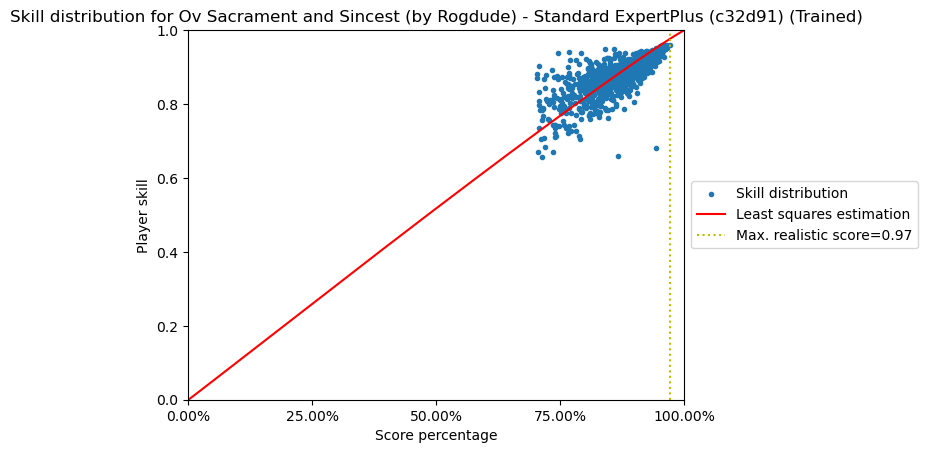

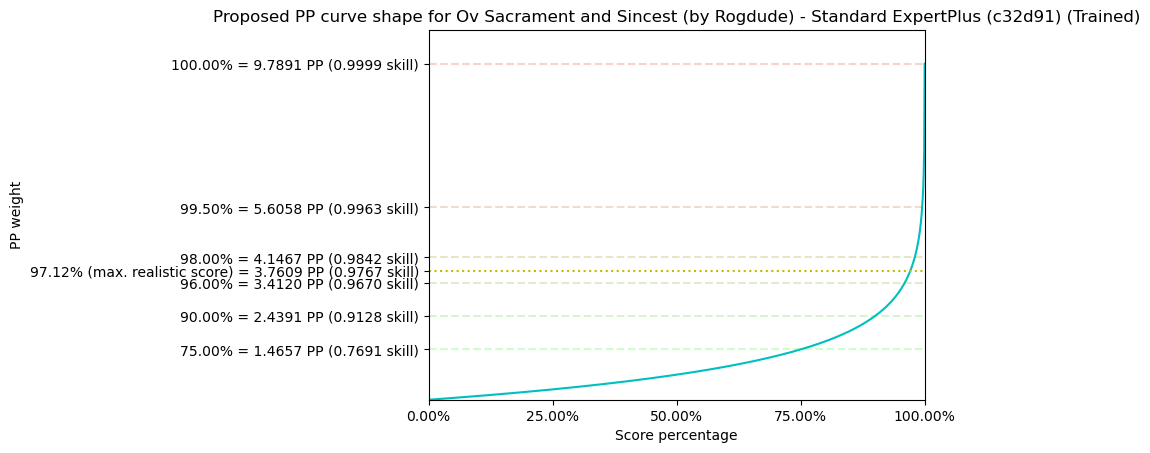

{'Hash': '547d15e033e7c3480428d3a0508f1b7ce50da5d6', 'Name': '666', 'CoverImage': 'https://na.cdn.beatsaver.com/547d15e033e7c3480428d3a0508f1b7ce50da5d6.jpg', 'Mapper': 'ComplexFrequency & Narwhal', 'Id': '2ee3bxxxxxx91', 'SongId': '2ee3bxxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.862437, 'PassRating': 12.594467, 'TechRating': 8.803961, 'PredictedAcc': 0.9643922, 'ModifiersRating': {'Id': 1098426, 'SSPredictedAcc': 0.96637076, 'SSPassRating': 10.578978, 'SSAccRating': 12.494317, 'SSTechRating': 8.6788, 'SSStars': 13.022665, 'FSPredictedAcc': 0.96192956, 'FSPassRating': 15.413415, 'FSAccRating': 13.305814, 'FSTechRating': 8.986385, 'FSStars': 15.9848585, 'SFPredictedAcc': 0.957942, 'SFPassRating': 20.558159, 'SFAccRating': 13.940844, 'SFTechRating': 9.587521, 'SFStars': 19.491306, 'BFSPredictedAcc': 0.95723855, 'BFSPassRating': 16.56289, 'BFSAccRating': 13.699425, 'BFSTechRating': 9.150749, 'BFSStars': 16.974865, 'BSFPredictedAcc': 0.95135593, 'BSFPa

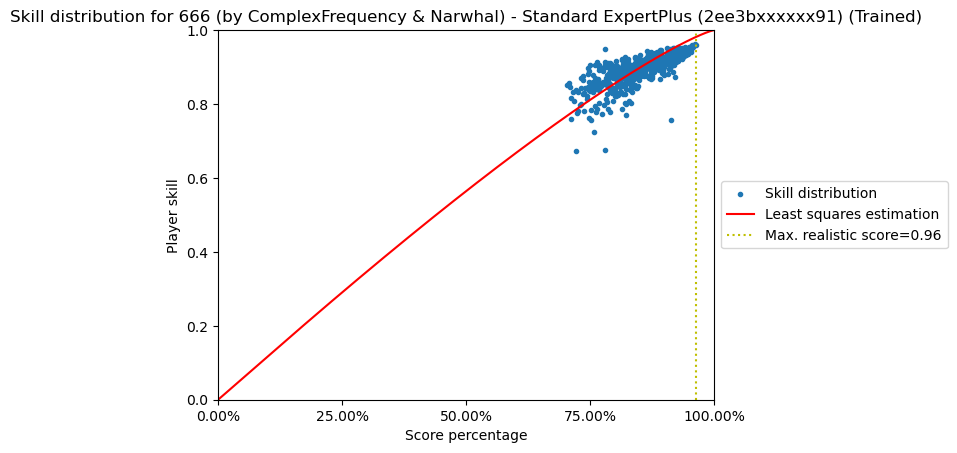

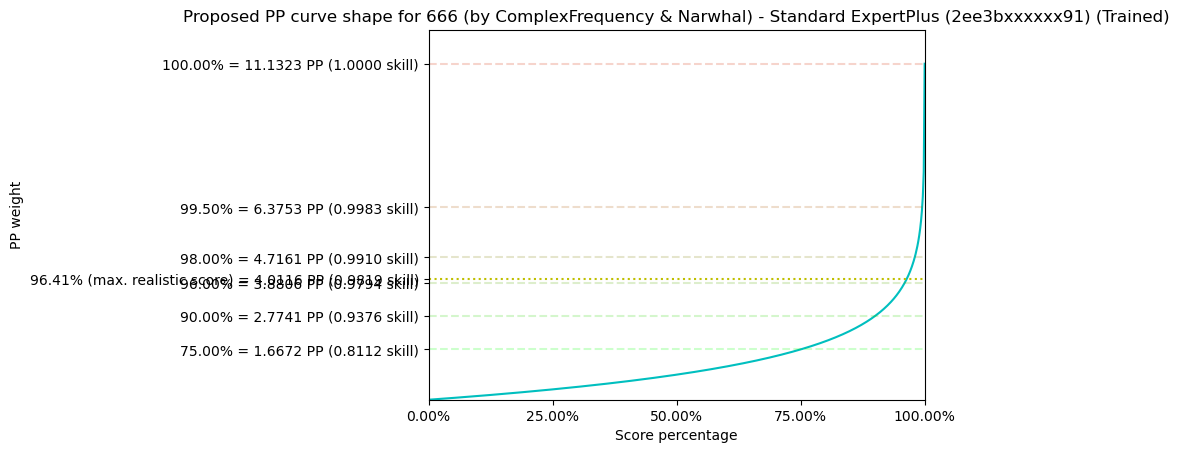

{'Hash': '4963752d07b806f9b0028d0015dc7e65bb74a1c8', 'Name': 'Quiet Water', 'CoverImage': 'https://eu.cdn.beatsaver.com/4963752d07b806f9b0028d0015dc7e65bb74a1c8.jpg', 'Mapper': 'Whiisper', 'Id': '7e8f11', 'SongId': '7e8f', 'ModeName': 'Standard', 'DifficultyName': 'Easy', 'AccRating': 1.849692, 'PassRating': 0.017607981, 'TechRating': 0.006381757, 'PredictedAcc': 0.9972797, 'ModifiersRating': {'Id': 8598, 'SSPredictedAcc': 0.997525, 'SSPassRating': 0.012998902, 'SSAccRating': 1.7740775, 'SSTechRating': 0.004714915, 'SSStars': 0.63929594, 'FSPredictedAcc': 0.99700767, 'FSPassRating': 0.024645664, 'FSAccRating': 1.9414564, 'FSTechRating': 0.008921906, 'FSStars': 0.7191181, 'SFPredictedAcc': 0.9965727, 'SFPassRating': 0.036929652, 'SFAccRating': 2.0723765, 'SFTechRating': 0.013341245, 'SFStars': 0.78312385, 'BFSPredictedAcc': 0.9972922, 'BFSPassRating': 0.0285304, 'BFSAccRating': 2.1983514, 'BFSTechRating': 0.01032147, 'BFSStars': 0.84522176, 'BSFPredictedAcc': 0.9969696, 'BSFPassRating':

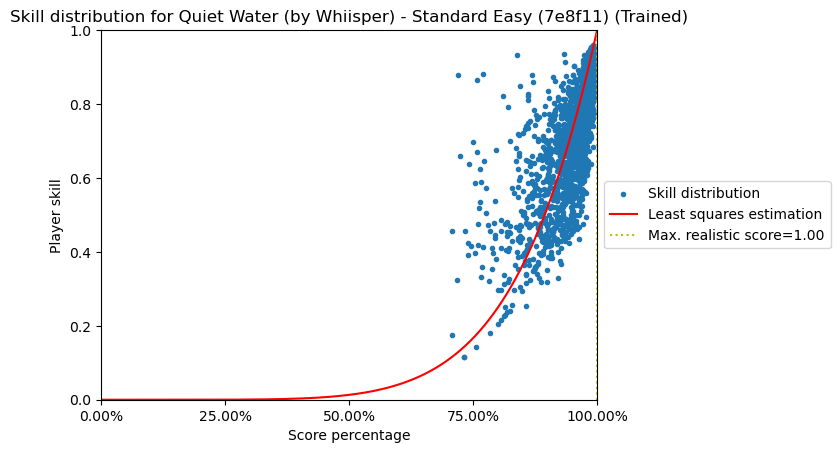

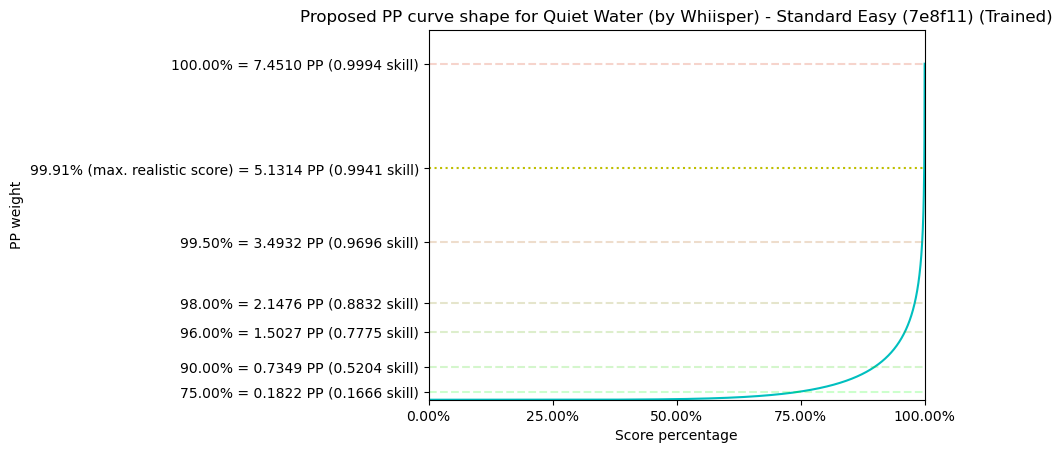

{'Hash': 'b97774a83bdfd669e1bd231039cccfa1162efa13', 'Name': 'Accelerate', 'CoverImage': 'https://na.cdn.beatsaver.com/b97774a83bdfd669e1bd231039cccfa1162efa13.jpg', 'Mapper': 'GalaxyMaster & Phøenix', 'Id': '36bce91', 'SongId': '36bce', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 13.033914, 'PassRating': 10.752386, 'TechRating': 11.006353, 'PredictedAcc': 0.9635087, 'ModifiersRating': {'Id': 1040275, 'SSPredictedAcc': 0.96533877, 'SSPassRating': 8.980194, 'SSAccRating': 12.683652, 'SSTechRating': 10.758843, 'SSStars': 12.929366, 'FSPredictedAcc': 0.9612418, 'FSPassRating': 13.06871, 'FSAccRating': 13.411184, 'FSTechRating': 11.170669, 'FSStars': 15.3816395, 'SFPredictedAcc': 0.957935, 'SFPassRating': 16.974102, 'SFAccRating': 13.942015, 'SFTechRating': 11.603688, 'SFStars': 17.873146, 'BFSPredictedAcc': 0.9577731, 'BFSPassRating': 13.354142, 'BFSAccRating': 13.627579, 'BFSTechRating': 11.4032135, 'BFSStars': 15.762796, 'BSFPredictedAcc': 0.95211947, 'BSFPassRa

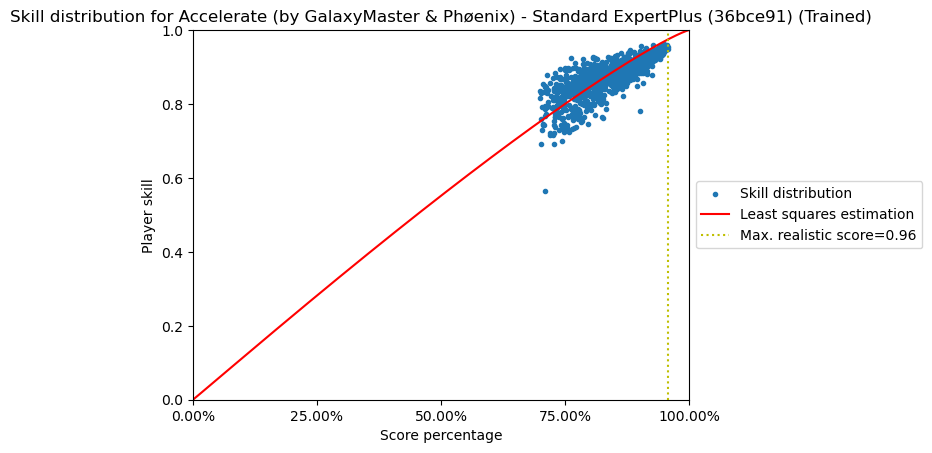

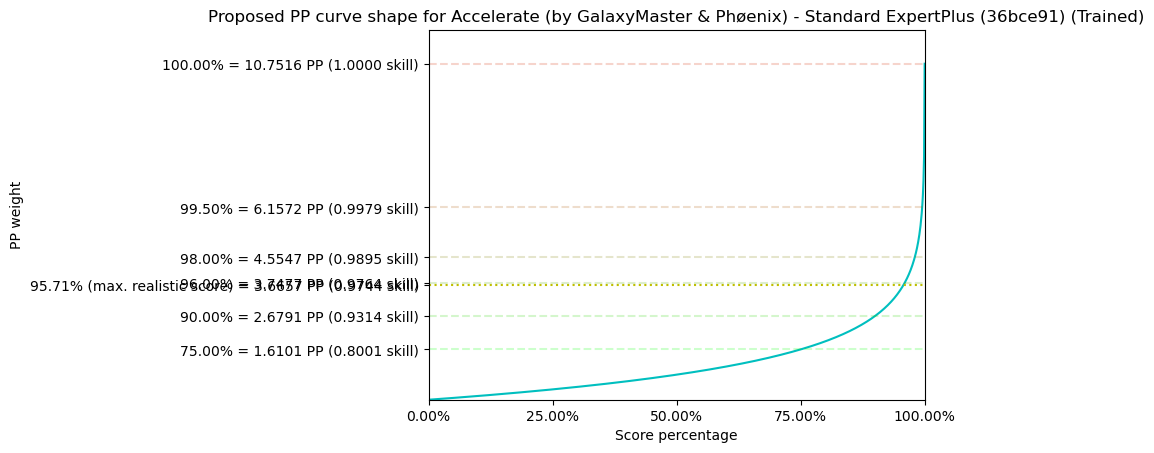

{'Hash': 'C2A5083F21B656EA2B5DB5F689240C39774F8119', 'Name': 'Ludicrous Speed', 'CoverImage': 'https://eu.cdn.beatsaver.com/c2a5083f21b656ea2b5db5f689240c39774f8119.jpg', 'Mapper': 'Helloiamdaan, cerret & Olaf', 'Id': '1f6b1xxxxxxxx91', 'SongId': '1f6b1xxxxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.938913, 'PassRating': 13.142659, 'TechRating': 2.4304786, 'PredictedAcc': 0.9691477, 'ModifiersRating': {'Id': 7560, 'SSPredictedAcc': 0.9718953, 'SSPassRating': 11.079212, 'SSAccRating': 11.270875, 'SSTechRating': 2.4008696, 'SSStars': 11.051611, 'FSPredictedAcc': 0.96566355, 'FSPassRating': 16.416653, 'FSAccRating': 12.623446, 'FSTechRating': 2.5362573, 'FSStars': 14.677316, 'SFPredictedAcc': 0.96031415, 'SFPassRating': 21.935665, 'SFAccRating': 13.555963, 'SFTechRating': 2.7149062, 'SFStars': 18.654512, 'BFSPredictedAcc': 0.96223223, 'BFSPassRating': 17.520617, 'BFSAccRating': 12.936552, 'BFSTechRating': 2.5808072, 'BFSStars': 15.54242, 'BSFPredictedAcc

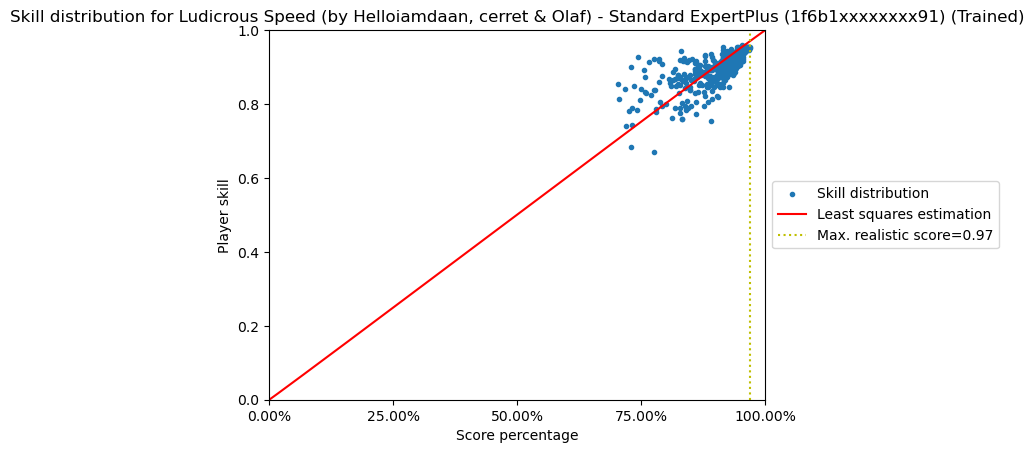

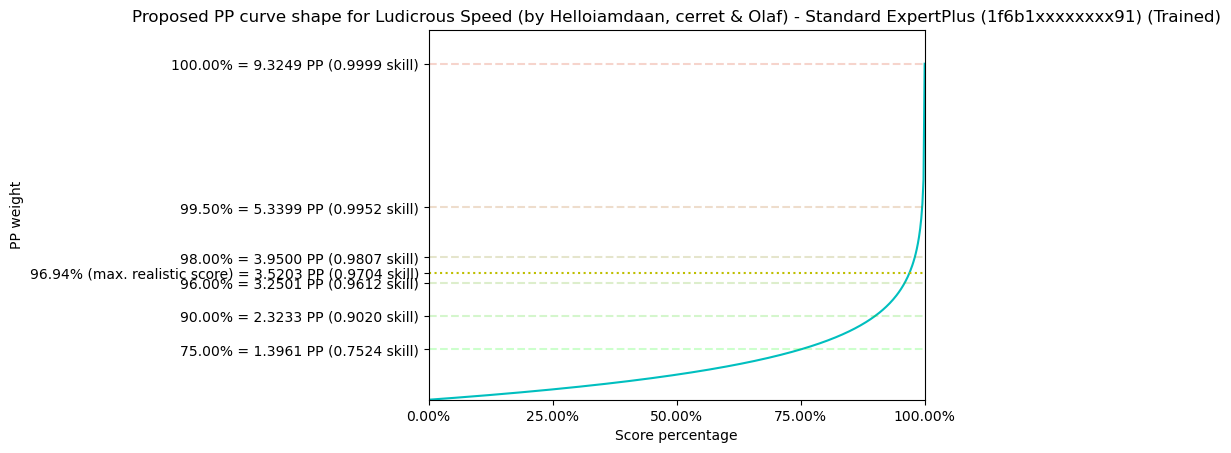

{'Hash': 'C3CFED196F96B161C0862EC387E0EE9241CD5B48', 'Name': 'Novablast', 'CoverImage': 'https://eu.cdn.beatsaver.com/c3cfed196f96b161c0862ec387e0ee9241cd5b48.jpg', 'Mapper': 'Bitz, Cokeinjector, Luck & Sync', 'Id': '23596xxx91', 'SongId': '23596xxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.352792, 'PassRating': 9.229344, 'TechRating': 7.588059, 'PredictedAcc': 0.9671628, 'ModifiersRating': {'Id': 7756, 'SSPredictedAcc': 0.9692271, 'SSPassRating': 7.654591, 'SSAccRating': 11.921572, 'SSTechRating': 7.3393674, 'SSStars': 11.174194, 'FSPredictedAcc': 0.9645801, 'FSPassRating': 11.283625, 'FSAccRating': 12.826547, 'FSTechRating': 7.7656817, 'FSStars': 13.466044, 'SFPredictedAcc': 0.96068, 'SFPassRating': 15.15156, 'SFAccRating': 13.498491, 'SFTechRating': 8.351992, 'SFStars': 15.935818, 'BFSPredictedAcc': 0.961079, 'BFSPassRating': 12.113143, 'BFSAccRating': 13.108646, 'BFSTechRating': 8.013302, 'BFSStars': 14.123602, 'BSFPredictedAcc': 0.954904, 'BSFPassRa

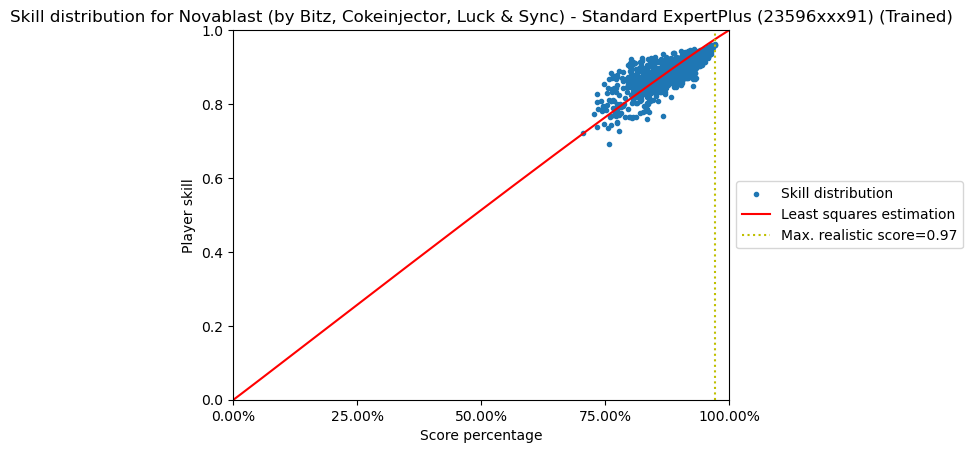

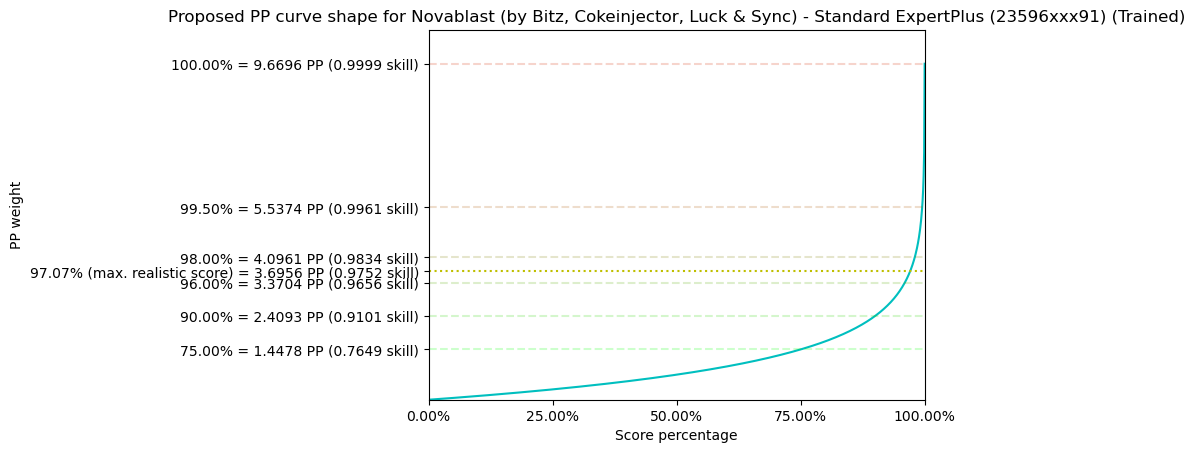

{'Hash': '9A33B85AF39D74C590036E9E8E92060B4FDEDFBD', 'Name': '""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""', 'CoverImage': 'https://eu.cdn.beatsaver.com/9a33b85af39d74c590036e9e8e92060b4fdedfbd.jpg', 'Mapper': 'Vilawes', 'Id': '2cf6391', 'SongId': '2cf63', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 8.789539, 'PassRating': 15.426448, 'TechRating': 1.953545, 'PredictedAcc': 0.9779913, 'ModifiersRating': {'Id': 8284, 'SSPredictedAcc': 0.98016113, 'SSPassRating': 13.070849, 'SSAccRating': 8.068162, 'SSTechRating': 1.9403174, 'SSStars': 8.933409, 'FSPredictedAcc': 0.9752563, 'FSPassRating': 18.985346, 'FSAccRating': 9.631505, 'FSTechRating': 2.0077035, 'FSStars': 13.027602, 'SFPredictedAcc': 0.9713166, 'SFPassRating': 25.277428, 'SFAccRating': 10.647221, 'SFTechRating': 2.1404138, 'SFStars': 17.717543, 'BFSPredictedAcc': 0.9716948, 'BFSPassRating': 19.562475, 'BFSAccRating': 11.045979, 'BFSTechRating': 2.0432973, 'BFSStars': 14.683779, 'BSFP

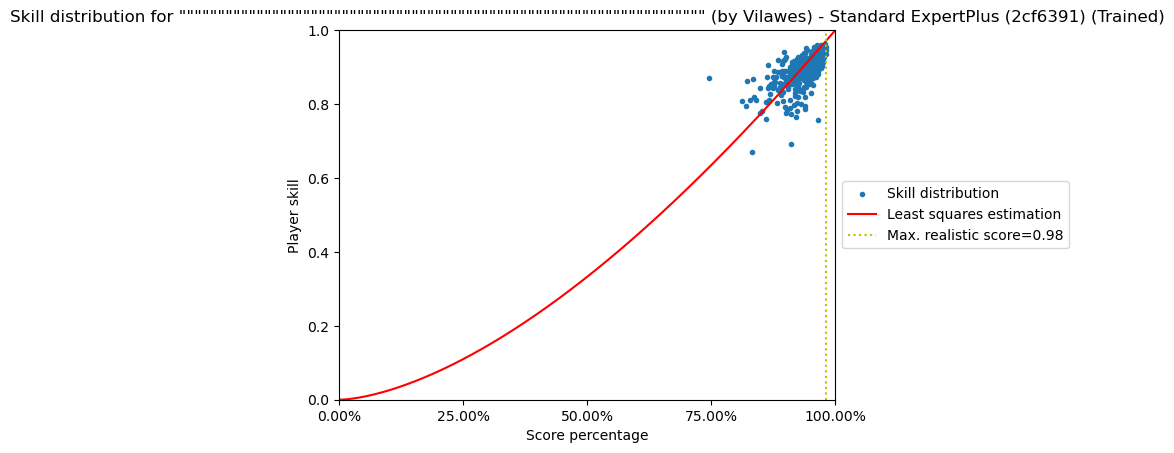

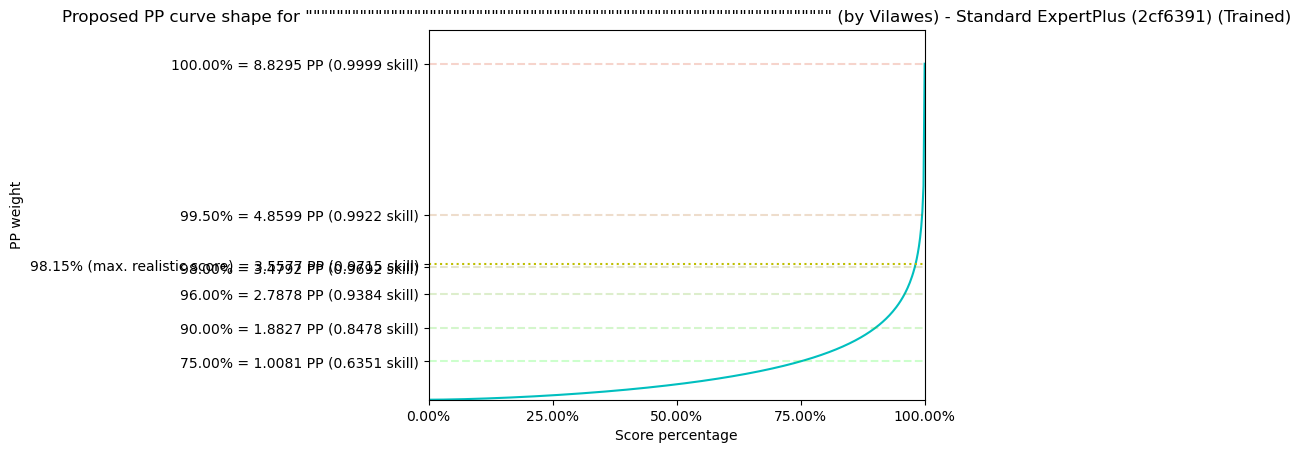

{'Hash': '2712a515d8fefb9c06cd0f8fb7021e7d5da3f2d1', 'Name': 'Dual Doom Deathmatch', 'CoverImage': 'https://cdn.beatsaver.com/2712a515d8fefb9c06cd0f8fb7021e7d5da3f2d1.jpg', 'Mapper': 'Blackjack', 'Id': '3e2c2xxxxx91', 'SongId': '3e2c2xxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 13.393936, 'PassRating': 13.197565, 'TechRating': 11.08773, 'PredictedAcc': 0.9613536, 'ModifiersRating': {'Id': 1233026, 'SSPredictedAcc': 0.96317434, 'SSPassRating': 11.116317, 'SSAccRating': 13.100003, 'SSTechRating': 10.953567, 'SSStars': 14.2033825, 'FSPredictedAcc': 0.9591188, 'FSPassRating': 15.936348, 'FSAccRating': 13.747217, 'FSTechRating': 11.167368, 'FSStars': 17.069088, 'SFPredictedAcc': 0.95562214, 'SFPassRating': 21.203966, 'SFAccRating': 14.269415, 'SFTechRating': 11.879003, 'SFStars': 20.647152, 'BFSPredictedAcc': 0.95505947, 'BFSPassRating': 16.6403, 'BFSAccRating': 14.000344, 'BFSTechRating': 11.416222, 'BFSStars': 17.725101, 'BSFPredictedAcc': 0.94912535, 'BSFP

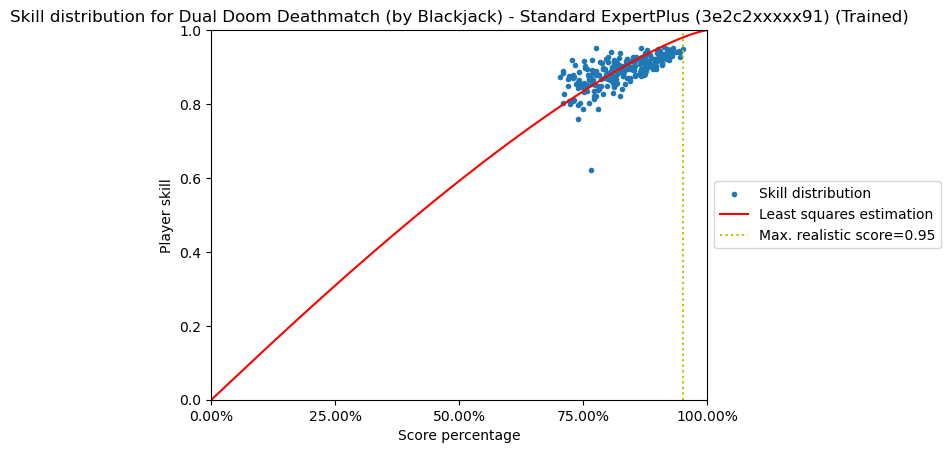

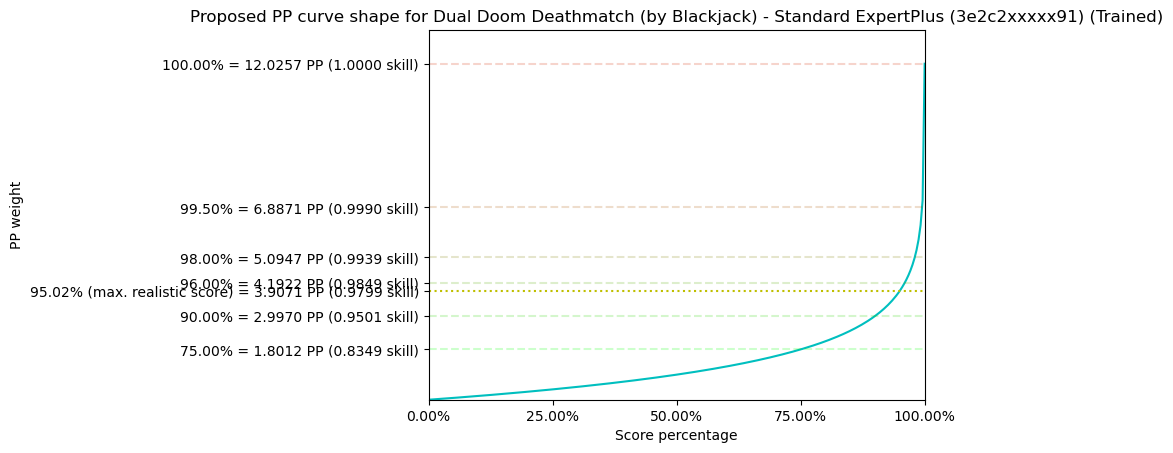

{'Hash': '187bea15de6bd730123917f889c2690a1500433c', 'Name': 'nieuwe tune', 'CoverImage': 'https://cdn.beatsaver.com/187bea15de6bd730123917f889c2690a1500433c.jpg', 'Mapper': 'Stupidity-101', 'Id': '3bcf5xxxxxxxx91', 'SongId': '3bcf5xxxxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.55551, 'PassRating': 13.282304, 'TechRating': 10.852338, 'PredictedAcc': 0.96603376, 'ModifiersRating': {'Id': 1222925, 'SSPredictedAcc': 0.967761, 'SSPassRating': 11.160863, 'SSAccRating': 12.248008, 'SSTechRating': 10.721307, 'SSStars': 13.371577, 'FSPredictedAcc': 0.9637907, 'FSPassRating': 16.06466, 'FSAccRating': 12.978677, 'FSTechRating': 10.928797, 'FSStars': 16.326294, 'SFPredictedAcc': 0.9603623, 'SFPassRating': 21.243496, 'SFAccRating': 13.548368, 'SFTechRating': 11.541488, 'SFStars': 19.858559, 'BFSPredictedAcc': 0.9608965, 'BFSPassRating': 16.882214, 'BFSAccRating': 13.1363, 'BFSTechRating': 11.120437, 'BFSStars': 16.92973, 'BSFPredictedAcc': 0.955367, 'BSFPassRati

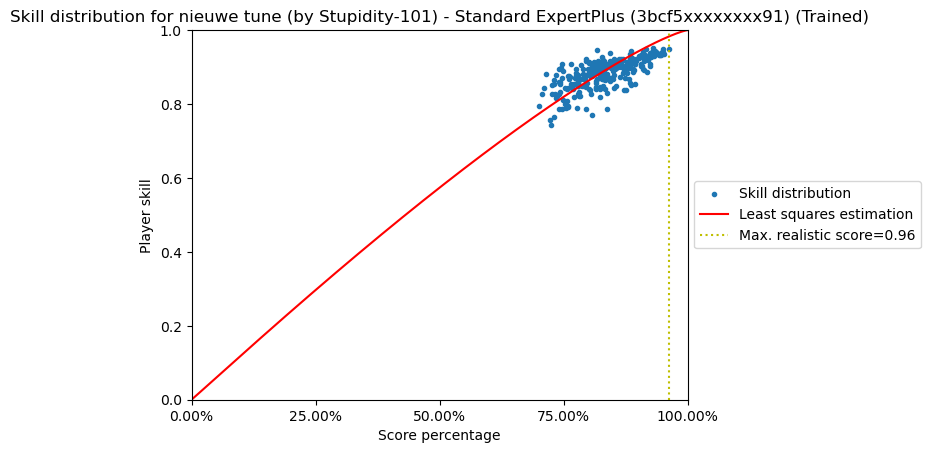

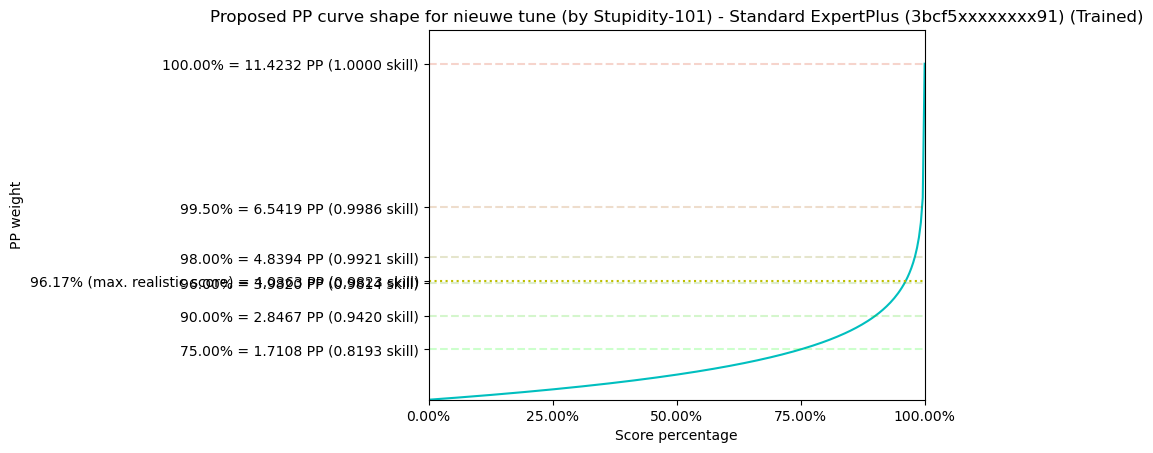

{'Hash': '495E4FB9D9460900A0433E11CA8BDBD3BB8DD471', 'Name': 'ANOTHER HIM', 'CoverImage': 'https://eu.cdn.beatsaver.com/495e4fb9d9460900a0433e11ca8bdbd3bb8dd471.jpg', 'Mapper': 'Phøenix', 'Id': '2a57111', 'SongId': '2a571', 'ModeName': 'Standard', 'DifficultyName': 'Easy', 'AccRating': 2.3616474, 'PassRating': 0.032721817, 'TechRating': 0.058093388, 'PredictedAcc': 0.9959079, 'ModifiersRating': {'Id': 8131, 'SSPredictedAcc': 0.9961961, 'SSPassRating': 0.024133362, 'SSAccRating': 2.2770023, 'SSTechRating': 0.04290754, 'SSStars': 0.887669, 'FSPredictedAcc': 0.9955365, 'FSPassRating': 0.045856256, 'FSAccRating': 2.480489, 'FSTechRating': 0.0812326, 'FSStars': 0.99536645, 'SFPredictedAcc': 0.9949858, 'SFPassRating': 0.06882976, 'SFAccRating': 2.6363578, 'SFTechRating': 0.12146045, 'SFStars': 1.0807717, 'BFSPredictedAcc': 0.99603415, 'BFSPassRating': 0.046950806, 'BFSAccRating': 2.6371045, 'BFSTechRating': 0.08315628, 'BFSStars': 1.0775249, 'BSFPredictedAcc': 0.9956299, 'BSFPassRating': 0.0

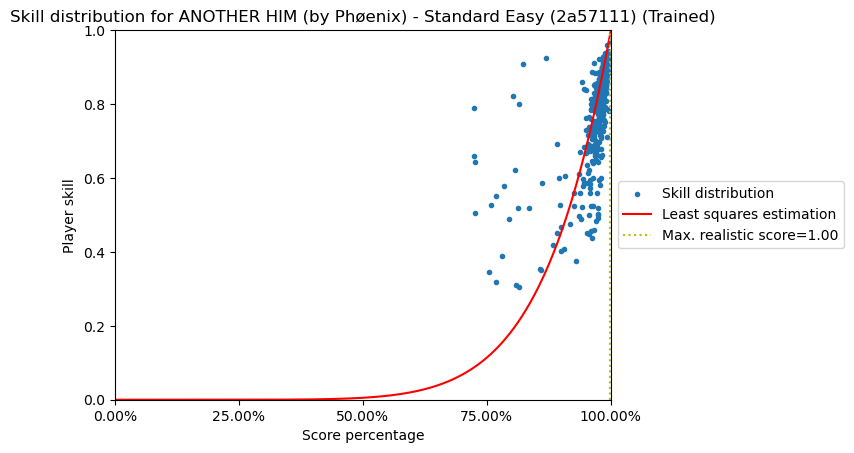

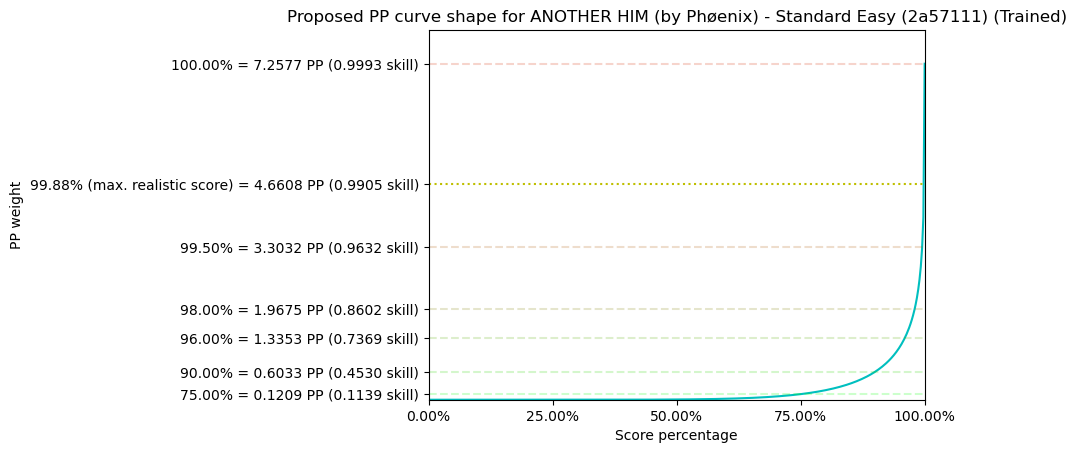

{'Hash': '3EB725A7D0343654527475369AE950A6AB8154F7', 'Name': 'Atomic', 'CoverImage': 'https://eu.cdn.beatsaver.com/3eb725a7d0343654527475369ae950a6ab8154f7.jpg', 'Mapper': 'A Jhintleman & GojiCrafter', 'Id': '220f2xxx91', 'SongId': '220f2xxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.762368, 'PassRating': 4.356675, 'TechRating': 10.134479, 'PredictedAcc': 0.9699667, 'ModifiersRating': {'Id': 7721, 'SSPredictedAcc': 0.9711831, 'SSPassRating': 3.495524, 'SSAccRating': 11.455069, 'SSTechRating': 9.112044, 'SSStars': 9.664208, 'FSPredictedAcc': 0.9683302, 'FSPassRating': 5.5124326, 'FSAccRating': 12.120489, 'FSTechRating': 11.114587, 'FSStars': 11.233856, 'SFPredictedAcc': 0.9660025, 'SFPassRating': 7.45235, 'SFAccRating': 12.56122, 'SFTechRating': 12.382359, 'SFStars': 12.522653, 'BFSPredictedAcc': 0.966374, 'BFSPassRating': 5.740912, 'BFSAccRating': 12.189007, 'BFSTechRating': 11.378487, 'BFSStars': 11.416256, 'BSFPredictedAcc': 0.96260864, 'BSFPassRating':

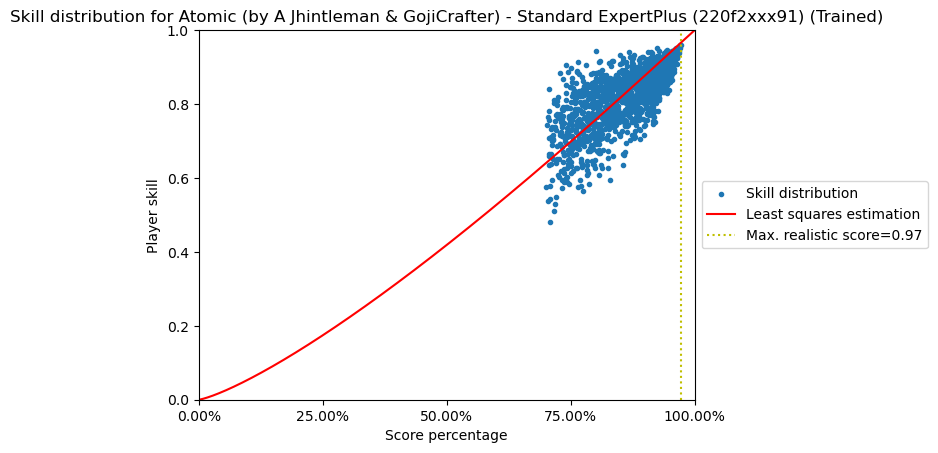

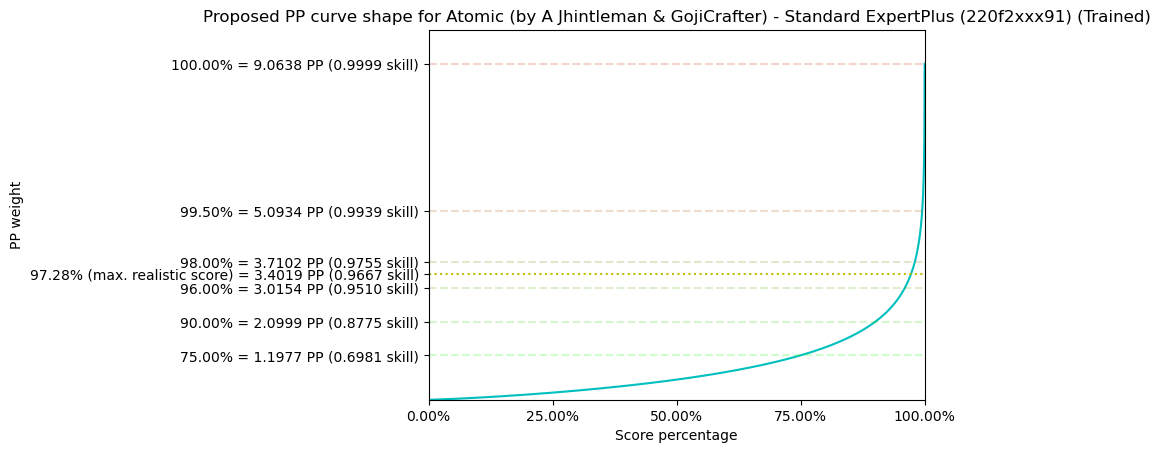

{'Hash': '848e58c44755966c9265c3e1021db6d9e679c9cb', 'Name': 'heaven', 'CoverImage': 'https://cdn.beatsaver.com/848e58c44755966c9265c3e1021db6d9e679c9cb.jpg', 'Mapper': 'UglyApe', 'Id': '3963ex92', 'SongId': '3963ex', 'ModeName': 'OneSaber', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.596535, 'PassRating': 6.947315, 'TechRating': 10.197642, 'PredictedAcc': 0.9688082, 'ModifiersRating': {'Id': 1153625, 'SSPredictedAcc': 0.96990126, 'SSPassRating': 5.8011007, 'SSAccRating': 11.367393, 'SSTechRating': 9.684717, 'SSStars': 10.421305, 'FSPredictedAcc': 0.9676286, 'FSPassRating': 8.45135, 'FSAccRating': 11.844977, 'FSTechRating': 10.630499, 'FSStars': 11.9317665, 'SFPredictedAcc': 0.9661287, 'SFPassRating': 11.15212, 'SFAccRating': 12.102866, 'SFTechRating': 11.470247, 'SFStars': 13.358196, 'BFSPredictedAcc': 0.96478033, 'BFSPassRating': 9.799537, 'BFSAccRating': 12.476607, 'BFSTechRating': 10.910571, 'BFSStars': 13.075837, 'BSFPredictedAcc': 0.9611753, 'BSFPassRating': 12.726621, 'BSFAc

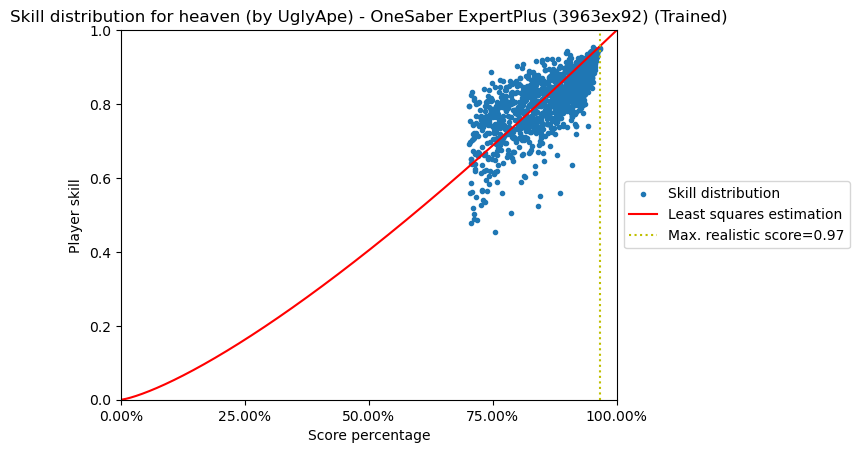

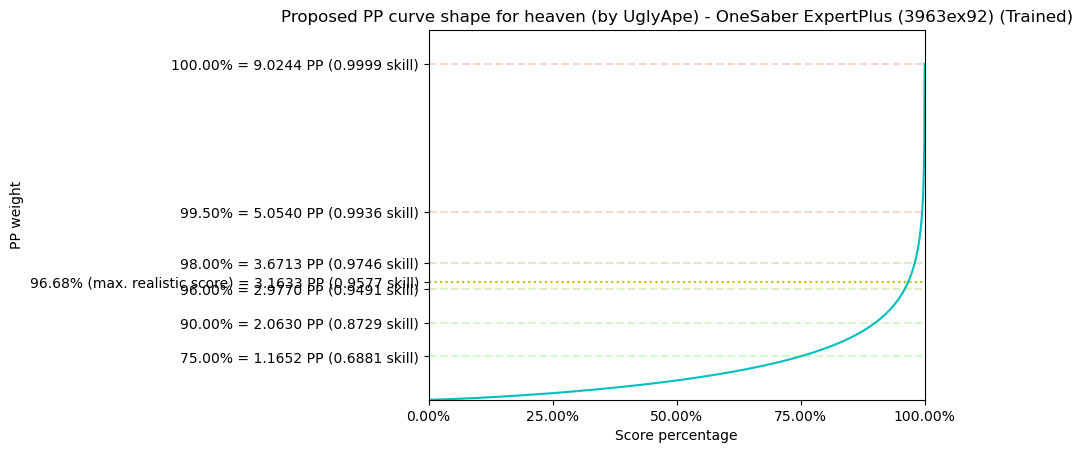

{'Hash': 'ed1a3273b99d5f0b0cd61a1d42cbe02de11fe0c8', 'Name': 'Scream', 'CoverImage': 'https://na.cdn.beatsaver.com/ed1a3273b99d5f0b0cd61a1d42cbe02de11fe0c8.jpg', 'Mapper': 'Serephor, CMP1111, LaidBackAries', 'Id': '38419x91', 'SongId': '38419x', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 10.3140135, 'PassRating': 3.5834234, 'TechRating': 8.042309, 'PredictedAcc': 0.9753135, 'ModifiersRating': {'Id': 1132570, 'SSPredictedAcc': 0.97667176, 'SSPassRating': 2.872866, 'SSAccRating': 9.854296, 'SSTechRating': 7.1137333, 'SSStars': 7.7946877, 'FSPredictedAcc': 0.97369045, 'FSPassRating': 4.5441246, 'FSAccRating': 10.775066, 'FSTechRating': 8.991936, 'FSStars': 9.382673, 'SFPredictedAcc': 0.97149974, 'SFPassRating': 6.08231, 'SFAccRating': 11.372445, 'SFTechRating': 10.10108, 'SFStars': 10.586478, 'BFSPredictedAcc': 0.9745814, 'BFSPassRating': 4.6645627, 'BFSAccRating': 10.261094, 'BFSTechRating': 9.076766, 'BFSStars': 8.988707, 'BSFPredictedAcc': 0.9710023, 'BSFPassR

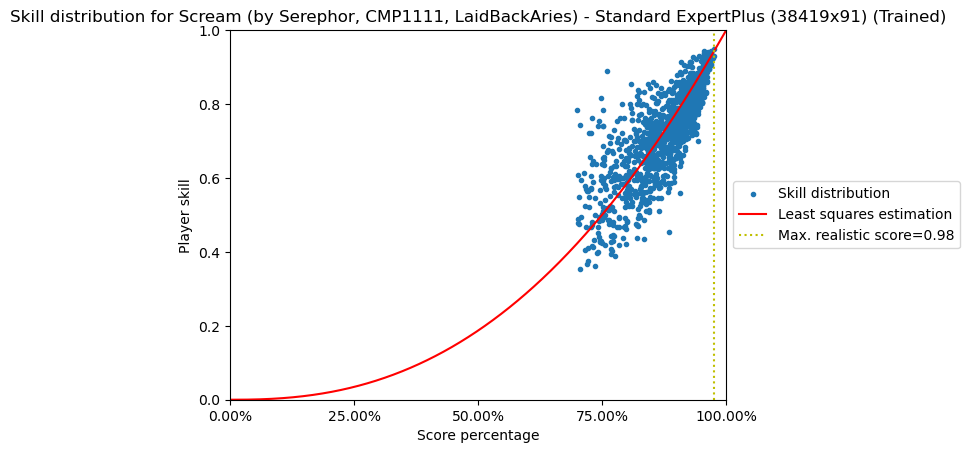

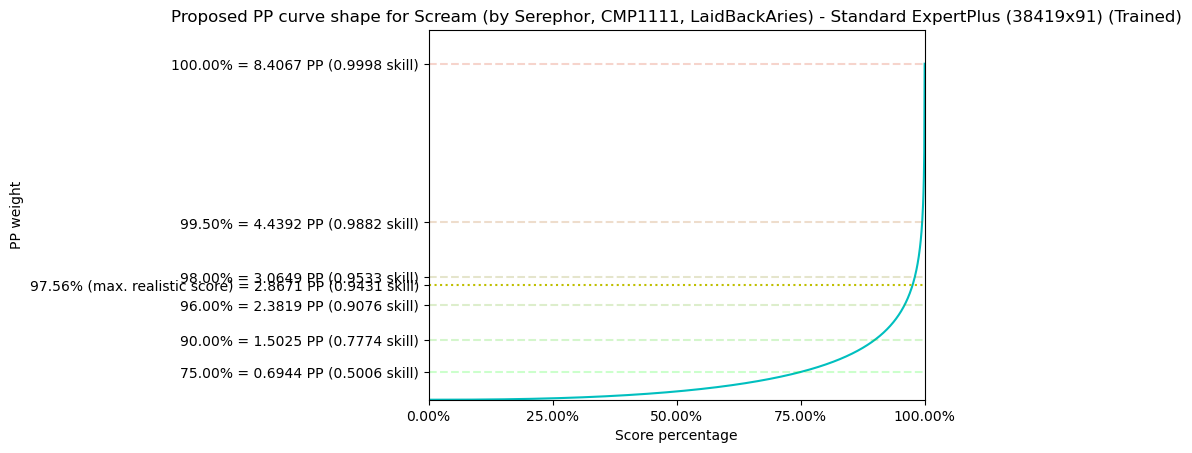

In [211]:
for map_id in golden_standard_map_ids:    
    #map_summary(map_id, suffix = "(Initial)")
    map_summary_with_skills(map_id, result_player_skills, map_params_by_map_id = result_map_params, suffix = "(Trained)")

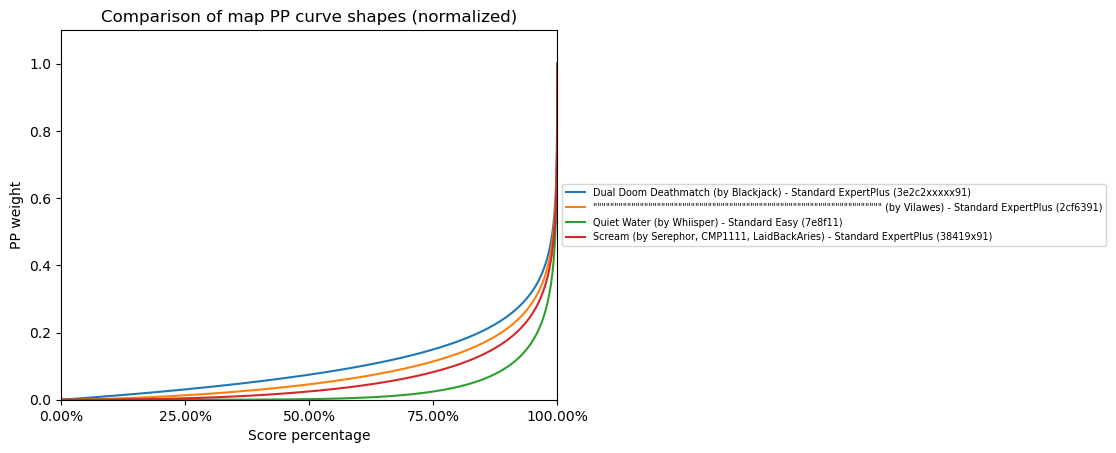

In [191]:
show_map_pp_comparison_by_map_ids(["3e2c2xxxxx91","2cf6391","7e8f11","38419x91"], map_params_by_map_id = result_map_params, min_x = 0, normalize=True)
#show_map_pp_comparison_by_map_ids(golden_standard_map_ids, map_params_by_map_id = result_map_params, min_x = 0, normalize=True)

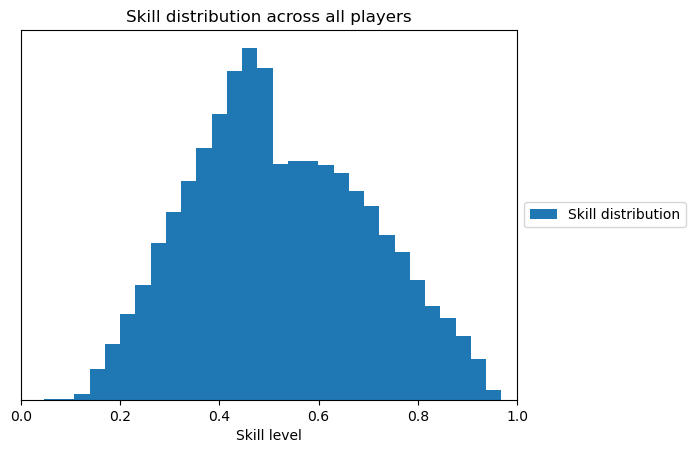

In [190]:
skills = list(result_player_skills.values())
skills.sort()

show_skill_distribution(skills)

In [37]:
print(metrics.keys())

dict_keys(['map_metrics_by_id', 'map_r2_quantiles', 'player_skill_quantiles', 'highest_min_threshold_map_id', 'highest_min_threshold', 'highest_100_threshold_map_id', 'highest_100_threshold', 'lowest_100_threshold_map_id', 'lowest_100_threshold'])


In [209]:
print([0, 0.25, 0.5, 0.75, 0.9, 1])
print(metrics["map_r2_quantiles"])
print(metrics["player_skill_quantiles"])

[0, 0.25, 0.5, 0.75, 0.9, 1]
[-0.80171344  0.59761291  0.66464369  0.71612172  0.75490244  0.90304473]
[0.04586743 0.39161283 0.5000002  0.65368105 0.77019918 0.96825226]


Map 2a57111 has r2 = -0.014987723997470948
Map 2a9e791 has r2 = -0.2856946658427826
Map 290c991 has r2 = -0.25170914522448307
Map 3ee4bxx12 has r2 = -0.07489916615104719
Map 2b43ax91 has r2 = -0.4135711656213015
Map 2ceacxxxxx91 has r2 = -0.8017134395760337
Map 2cde3xxx71 has r2 = -0.010331060804541714
Map 3b5a9xxxx92 has r2 = -0.004096468349068072
Map 6b5f71 has r2 = -0.0788153429029097
Map 2dd6cxx92 has r2 = -0.2708485972612895
Map 3598fxx91 has r2 = -0.01323644424122028
Map 3f829xxxxxx91 has r2 = -0.23957166344341463
Map 2c888xxxxx91 has r2 = -0.0399830247895141
Map 2cde3xxx91 has r2 = -0.4244382254843839
Map 334e3x91 has r2 = -0.3426971586607095
Map 2dd30xxxxxx91 has r2 = -0.12217714742165997
{'Hash': '495E4FB9D9460900A0433E11CA8BDBD3BB8DD471', 'Name': 'ANOTHER HIM', 'CoverImage': 'https://eu.cdn.beatsaver.com/495e4fb9d9460900a0433e11ca8bdbd3bb8dd471.jpg', 'Mapper': 'Phøenix', 'Id': '2a57111', 'SongId': '2a571', 'ModeName': 'Standard', 'DifficultyName': 'Easy', 'AccRating': 2.36164

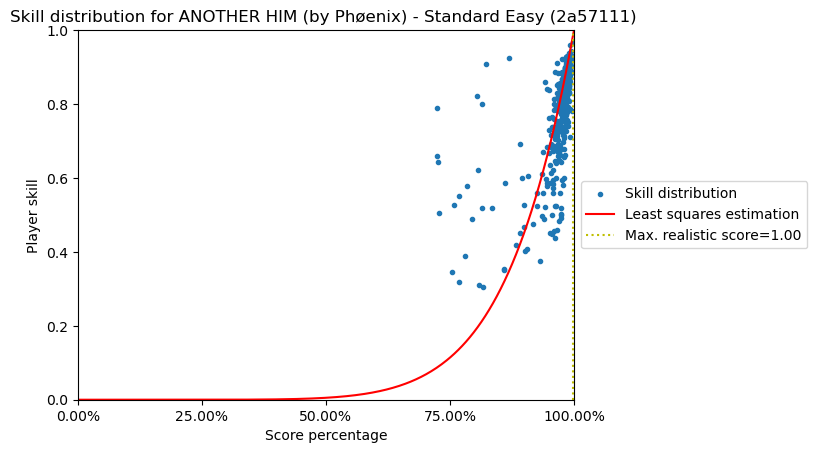

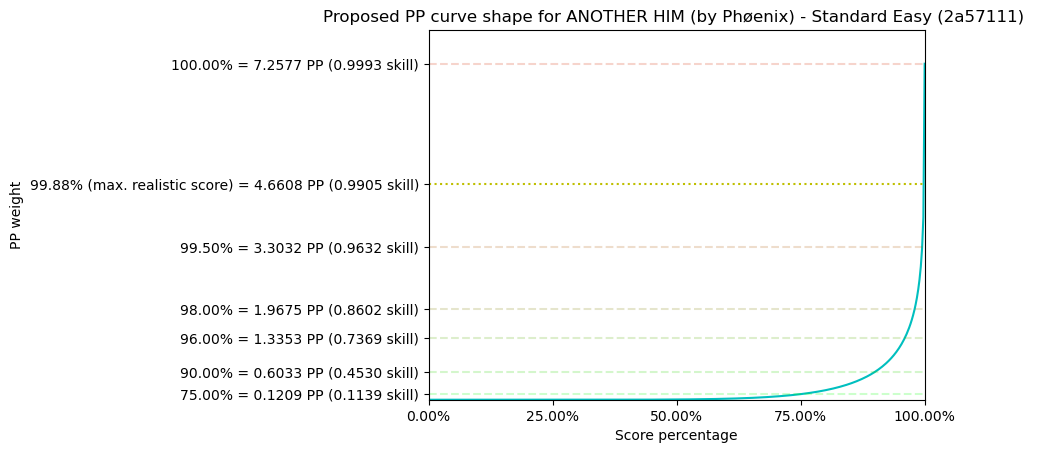

{'Hash': '65271048A9A759FECA86CED657D1733D5994CDF1', 'Name': 'Speedcore Paradise', 'CoverImage': 'https://eu.cdn.beatsaver.com/65271048a9a759feca86ced657d1733d5994cdf1.jpg', 'Mapper': 'Emilia', 'Id': '2a9e791', 'SongId': '2a9e7', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 10.506173, 'PassRating': 12.078603, 'TechRating': 5.5113525, 'PredictedAcc': 0.9754499, 'ModifiersRating': {'Id': 8144, 'SSPredictedAcc': 0.9768002, 'SSPassRating': 10.162626, 'SSAccRating': 10.042596, 'SSTechRating': 5.424139, 'SSStars': 10.090717, 'FSPredictedAcc': 0.9737528, 'FSPassRating': 14.7135515, 'FSAccRating': 11.00839, 'FSTechRating': 5.6148124, 'FSStars': 12.867682, 'SFPredictedAcc': 0.97111523, 'SFPassRating': 19.592653, 'SFAccRating': 11.741456, 'SFTechRating': 5.9925585, 'SFStars': 16.07154, 'BFSPredictedAcc': 0.9732158, 'BFSPassRating': 15.160106, 'BFSAccRating': 10.651139, 'BFSTechRating': 5.7243357, 'BFSStars': 12.75463, 'BSFPredictedAcc': 0.96886075, 'BSFPassRating': 19.589

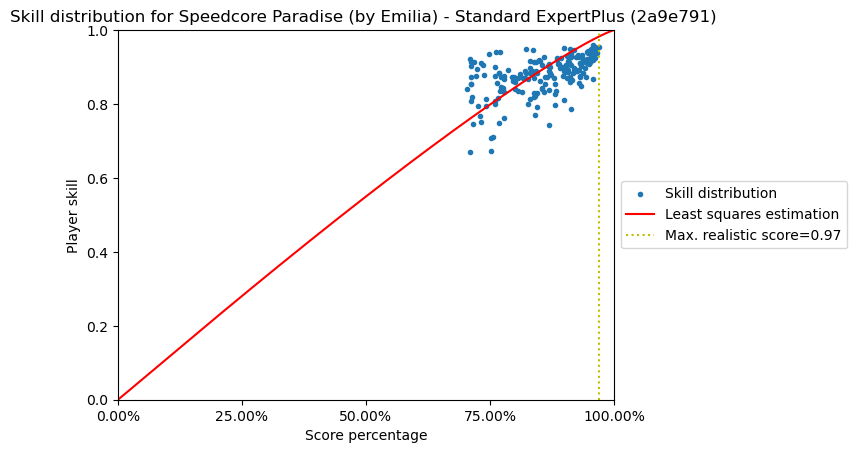

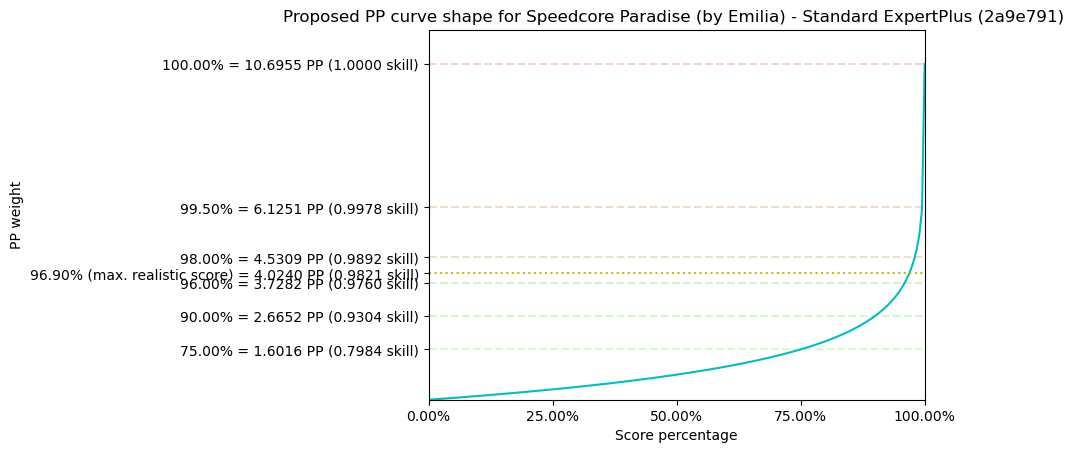

{'Hash': 'D99DB4C1D15D7ED66E3D5B6FB803116E76D2A937', 'Name': 'Superluminal Absolutely EXTRA-TONE-ordinary', 'CoverImage': 'https://eu.cdn.beatsaver.com/d99db4c1d15d7ed66e3d5b6fb803116e76d2a937.jpg', 'Mapper': 'cerret', 'Id': '290c991', 'SongId': '290c9', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.762481, 'PassRating': 14.917446, 'TechRating': 2.8173664, 'PredictedAcc': 0.96491814, 'ModifiersRating': {'Id': 8058, 'SSPredictedAcc': 0.9680589, 'SSPassRating': 12.613052, 'SSAccRating': 12.181988, 'SSTechRating': 2.7954097, 'SSStars': 12.574343, 'FSPredictedAcc': 0.96050537, 'FSPassRating': 18.596792, 'FSAccRating': 13.525869, 'FSTechRating': 2.931212, 'FSStars': 16.751472, 'SFPredictedAcc': 0.9530242, 'SFPassRating': 24.823032, 'SFAccRating': 14.65093, 'SFTechRating': 3.1322675, 'SFStars': 21.731047, 'BFSPredictedAcc': 0.9567738, 'BFSPassRating': 19.110445, 'BFSAccRating': 13.76251, 'BFSTechRating': 2.9938903, 'BFSStars': 17.2787, 'BSFPredictedAcc': 0.94882643,

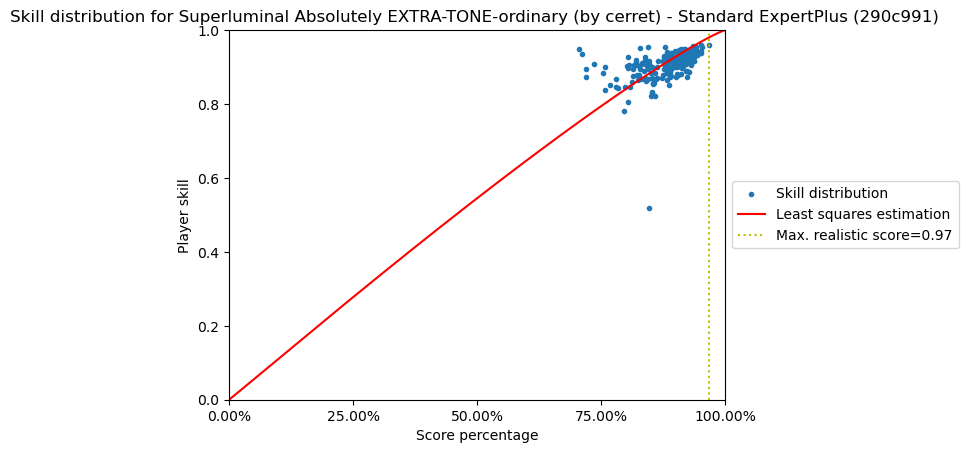

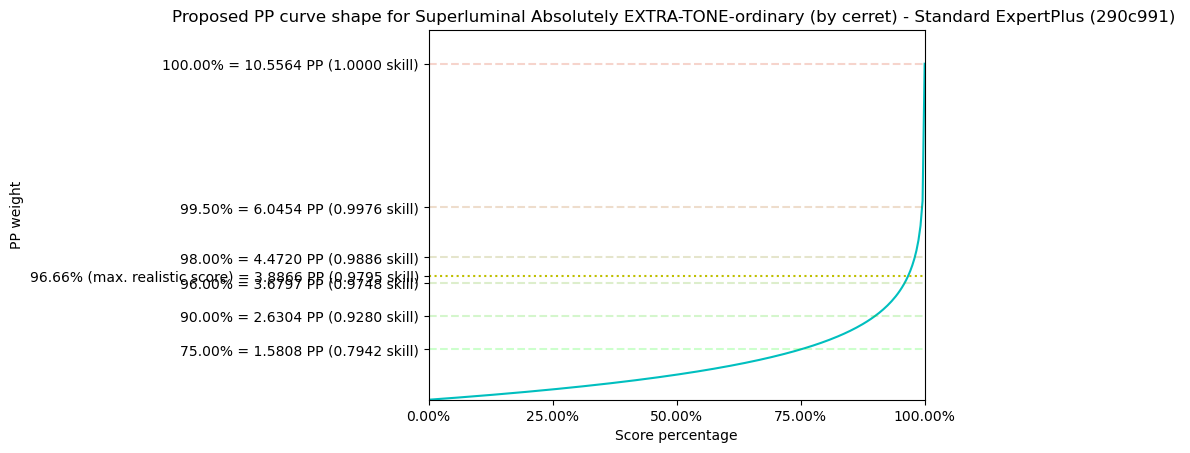

{'Hash': '5faf5fa82a44027a1417dad4f945f7f8dcebdc9e', 'Name': 'RTX 20000', 'CoverImage': 'https://cdn.beatsaver.com/5faf5fa82a44027a1417dad4f945f7f8dcebdc9e.jpg', 'Mapper': 'Darkrealm7 & bobthezealot', 'Id': '3ee4bxx12', 'SongId': '3ee4bxx', 'ModeName': 'OneSaber', 'DifficultyName': 'Easy', 'AccRating': 2.8682945, 'PassRating': 0.008320305, 'TechRating': 0.012929889, 'PredictedAcc': 0.99343145, 'ModifiersRating': {'Id': 1314515, 'SSPredictedAcc': 0.9935543, 'SSPassRating': 0.0060668495, 'SSAccRating': 2.8311515, 'SSTechRating': 0.009431557, 'SSStars': 1.1739726, 'FSPredictedAcc': 0.9932273, 'FSPassRating': 0.011836124, 'FSAccRating': 2.9322176, 'FSTechRating': 0.01838266, 'FSStars': 1.2295867, 'SFPredictedAcc': 0.9928759, 'SFPassRating': 0.018160995, 'SFAccRating': 3.0492024, 'SFTechRating': 0.028175833, 'SFStars': 1.2946359, 'BFSPredictedAcc': 0.9934201, 'BFSPassRating': 0.011836124, 'BFSAccRating': 2.8717635, 'BFSTechRating': 0.01838266, 'BFSStars': 1.1967703, 'BSFPredictedAcc': 0.993

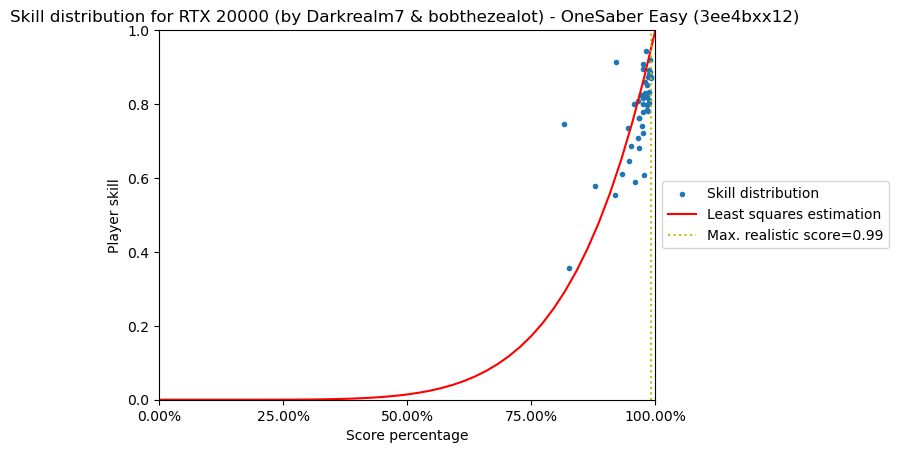

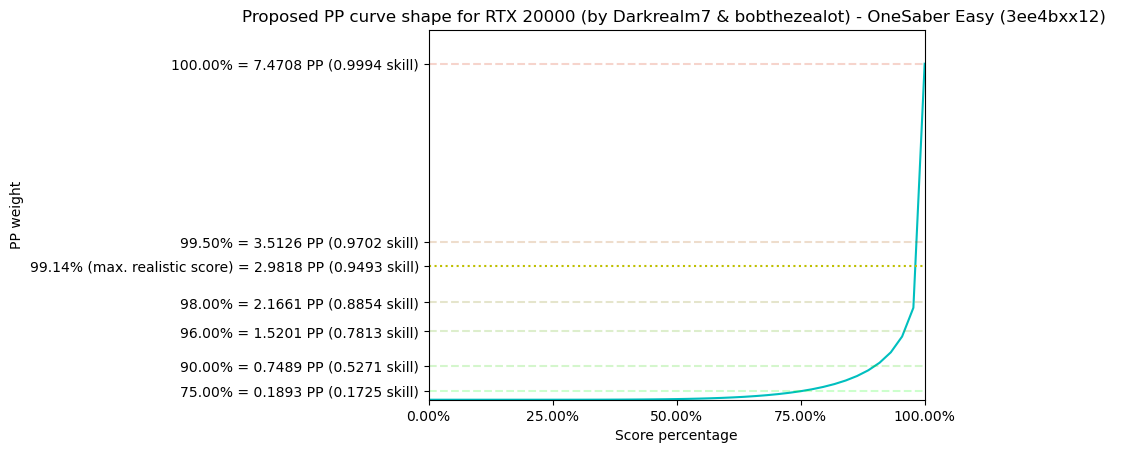

{'Hash': 'cc169c94622560aa6eee49dab0985ced736c7eef', 'Name': 'Saw-Saw.', 'CoverImage': 'https://eu.cdn.beatsaver.com/cc169c94622560aa6eee49dab0985ced736c7eef.jpg', 'Mapper': 'Emilia', 'Id': '2b43ax91', 'SongId': '2b43ax', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.511669, 'PassRating': 14.253604, 'TechRating': 2.1068802, 'PredictedAcc': 0.9720322, 'ModifiersRating': {'Id': 8172, 'SSPredictedAcc': 0.9738613, 'SSPassRating': 12.061027, 'SSAccRating': 10.987711, 'SSTechRating': 2.0877244, 'SSStars': 11.133336, 'FSPredictedAcc': 0.9695876, 'FSPassRating': 17.563688, 'FSAccRating': 12.133836, 'FSTechRating': 2.1686425, 'FSStars': 14.712304, 'SFPredictedAcc': 0.96547127, 'SFPassRating': 23.411674, 'SFAccRating': 12.969428, 'SFTechRating': 2.313951, 'SFStars': 18.899282, 'BFSPredictedAcc': 0.96595335, 'BFSPassRating': 18.068235, 'BFSAccRating': 12.263621, 'BFSTechRating': 2.2710342, 'BFSStars': 15.114327, 'BSFPredictedAcc': 0.9614088, 'BSFPassRating': 23.34181, 'B

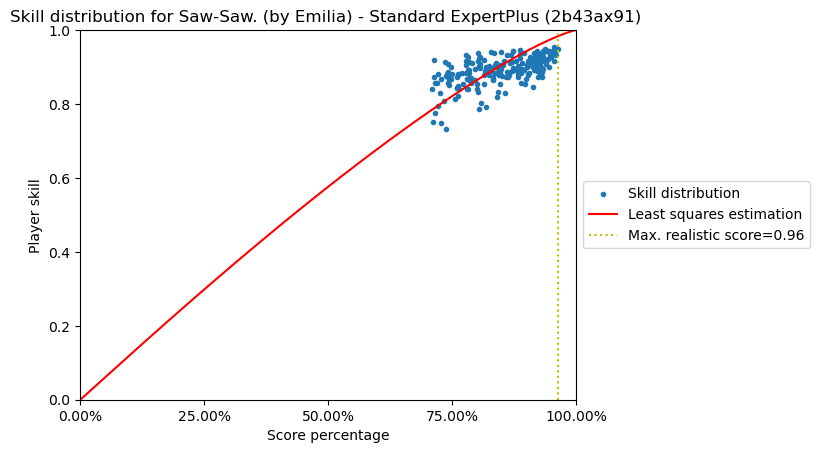

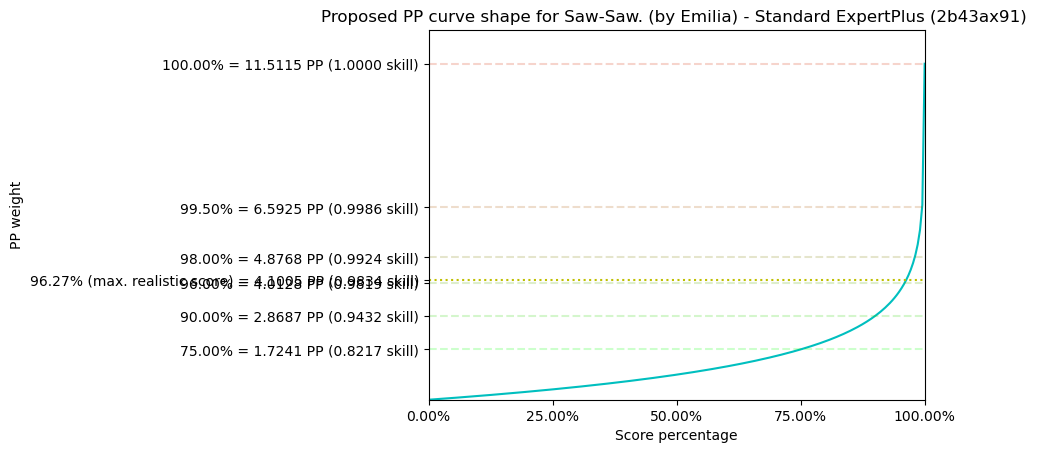

{'Hash': 'D5EBC9C4E38A700AB971C6256AE3A175C63B5B1D', 'Name': 'G e n g a o z o - f o o n', 'CoverImage': 'https://eu.cdn.beatsaver.com/d5ebc9c4e38a700ab971c6256ae3a175c63b5b1d.jpg', 'Mapper': 'ComplexFrequency', 'Id': '2ceacxxxxx91', 'SongId': '2ceacxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.160641, 'PassRating': 11.372194, 'TechRating': 3.2136338, 'PredictedAcc': 0.9696545, 'ModifiersRating': {'Id': 299843, 'SSPredictedAcc': 0.97172016, 'SSPassRating': 9.535997, 'SSAccRating': 11.632827, 'SSTechRating': 3.1524436, 'SSStars': 10.913464, 'FSPredictedAcc': 0.9671335, 'FSPassRating': 13.76647, 'FSAccRating': 12.704384, 'FSTechRating': 3.2532284, 'FSStars': 13.641699, 'SFPredictedAcc': 0.9635125, 'SFPassRating': 18.327972, 'SFAccRating': 13.398523, 'SFTechRating': 3.471965, 'SFStars': 16.577599, 'BFSPredictedAcc': 0.9640065, 'BFSPassRating': 14.190762, 'BFSAccRating': 12.621215, 'BFSTechRating': 3.3198571, 'BFSStars': 13.764002, 'BSFPredictedAcc': 0.9572

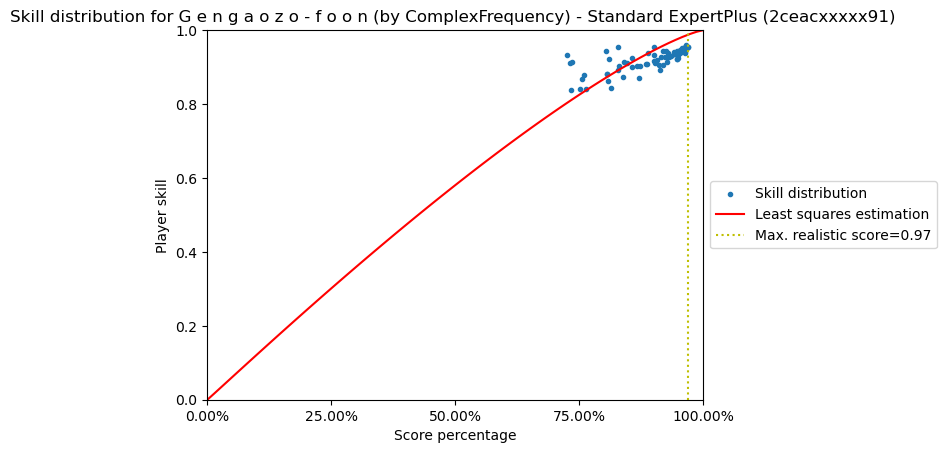

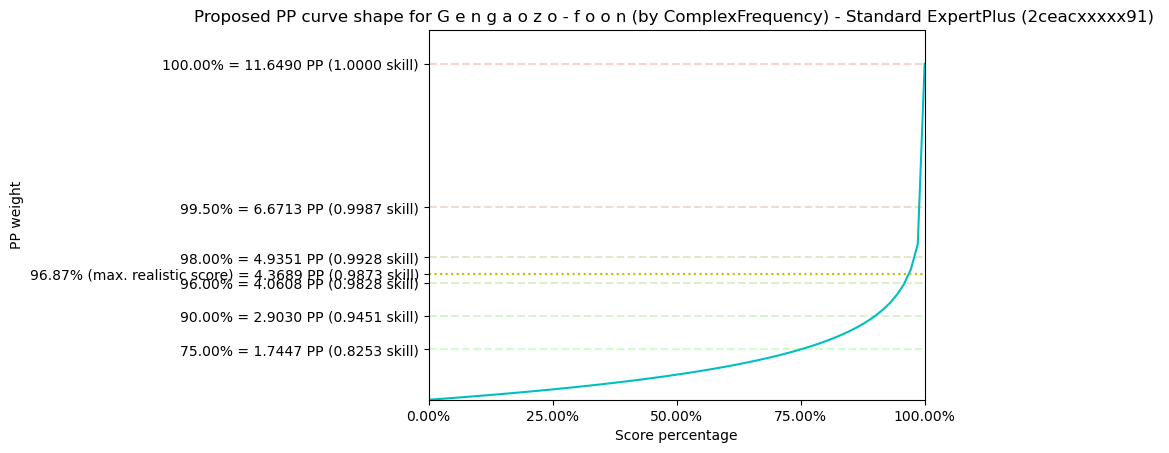

{'Hash': '506904800e3c03f9e0074156f6aae8bcb2f15705', 'Name': 'Shuenteki Routetsu Sokukakukyoku', 'CoverImage': 'https://eu.cdn.beatsaver.com/506904800e3c03f9e0074156f6aae8bcb2f15705.jpg', 'Mapper': 'Emilia', 'Id': '2cde3xxx71', 'SongId': '2cde3xxx', 'ModeName': 'Standard', 'DifficultyName': 'Expert', 'AccRating': 10.326146, 'PassRating': 13.51672, 'TechRating': 2.709908, 'PredictedAcc': 0.97527295, 'ModifiersRating': {'Id': 299789, 'SSPredictedAcc': 0.9773191, 'SSPassRating': 11.415317, 'SSAccRating': 9.649302, 'SSTechRating': 2.6800945, 'SSStars': 9.780771, 'FSPredictedAcc': 0.9724964, 'FSPassRating': 16.48407, 'FSAccRating': 11.119964, 'FSTechRating': 2.7602265, 'FSStars': 13.313583, 'SFPredictedAcc': 0.96800995, 'SFPassRating': 21.945988, 'SFAccRating': 12.193148, 'SFTechRating': 2.941266, 'SFStars': 17.323671, 'BFSPredictedAcc': 0.97060704, 'BFSPassRating': 17.078247, 'BFSAccRating': 11.325391, 'BFSTechRating': 2.8358681, 'BFSStars': 13.809889, 'BSFPredictedAcc': 0.9648907, 'BSFPas

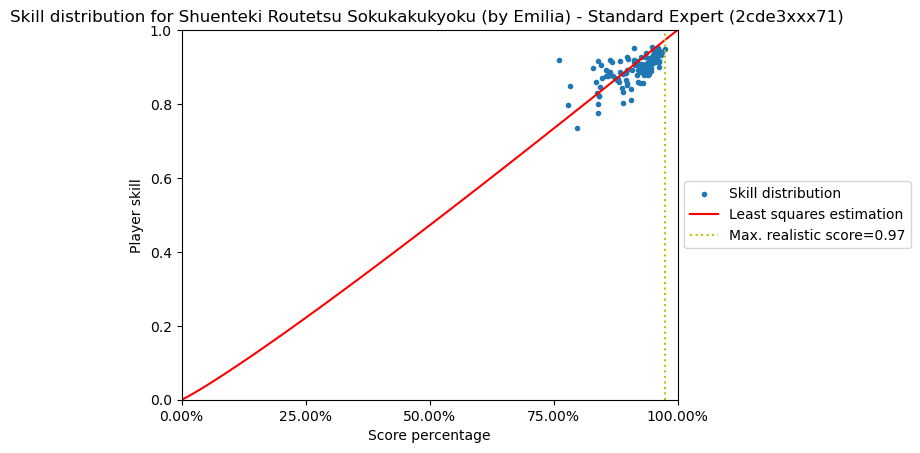

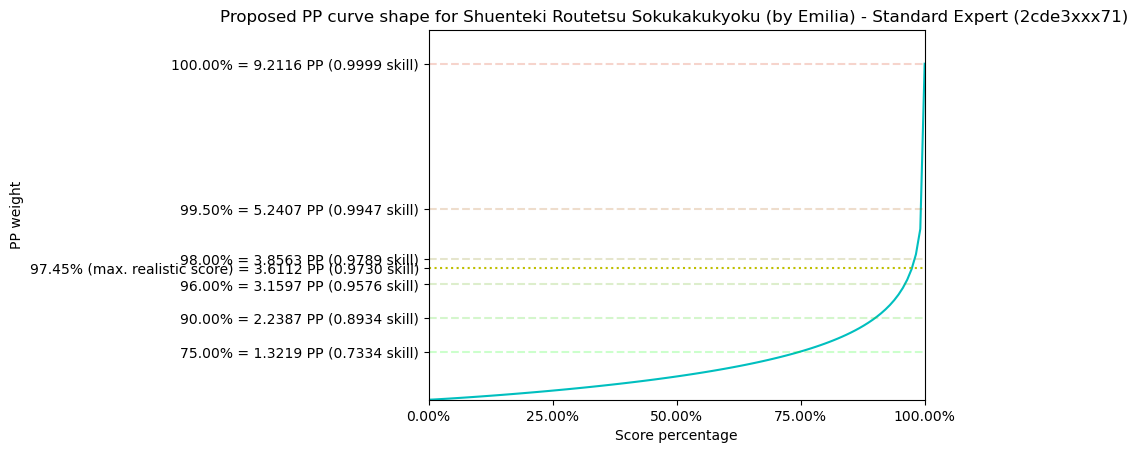

{'Hash': 'c293096c7b76628f44b2582379df85821d0734ff', 'Name': 'Flashback Flicker', 'CoverImage': 'https://cdn.beatsaver.com/c293096c7b76628f44b2582379df85821d0734ff.jpg', 'Mapper': 'BlAck_vOid-1001 & Darkrealm7', 'Id': '3b5a9xxxx92', 'SongId': '3b5a9xxxx', 'ModeName': 'OneSaber', 'DifficultyName': 'ExpertPlus', 'AccRating': 13.316683, 'PassRating': 8.196094, 'TechRating': 8.2344055, 'PredictedAcc': 0.9650883, 'ModifiersRating': {'Id': 1216411, 'SSPredictedAcc': 0.96676034, 'SSPassRating': 6.875129, 'SSAccRating': 12.996412, 'SSTechRating': 7.922273, 'SSStars': 11.977195, 'FSPredictedAcc': 0.9631687, 'FSPassRating': 9.925576, 'FSAccRating': 13.70441, 'FSTechRating': 8.480458, 'FSStars': 13.873379, 'SFPredictedAcc': 0.96041185, 'SFPassRating': 13.228981, 'SFAccRating': 14.1640835, 'SFTechRating': 9.1797905, 'SFStars': 15.840058, 'BFSPredictedAcc': 0.9576565, 'BFSPassRating': 11.927392, 'BFSAccRating': 13.643186, 'BFSTechRating': 8.792602, 'BFSStars': 14.692733, 'BSFPredictedAcc': 0.953293

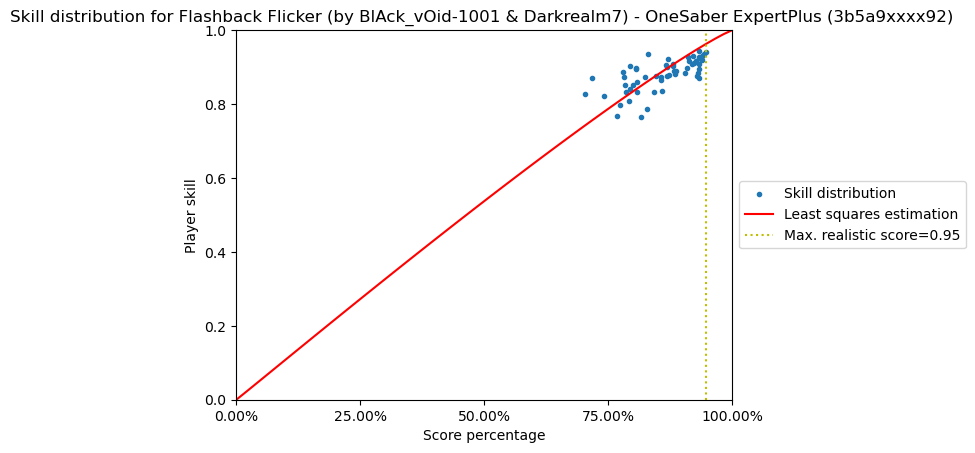

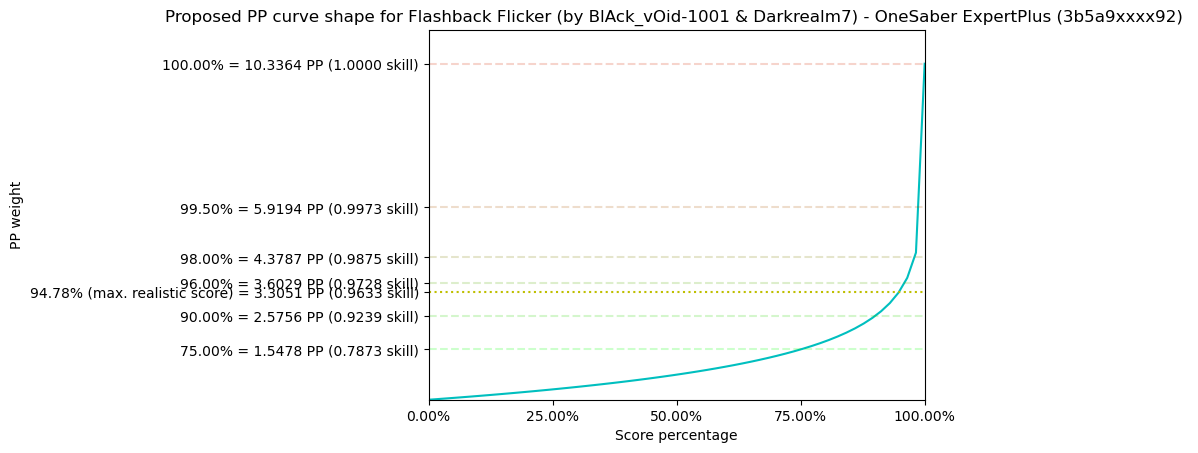

{'Hash': '6a5aea3ce9a7a9f120ebd4deea377b4a54640bfb', 'Name': 'Break', 'CoverImage': 'https://eu.cdn.beatsaver.com/6a5aea3ce9a7a9f120ebd4deea377b4a54640bfb.jpg', 'Mapper': 'Souk & Oddloop', 'Id': '6b5f71', 'SongId': '6b5f', 'ModeName': 'Standard', 'DifficultyName': 'Expert', 'AccRating': 12.348982, 'PassRating': 10.307068, 'TechRating': 4.507668, 'PredictedAcc': 0.96880037, 'ModifiersRating': {'Id': 8531, 'SSPredictedAcc': 0.9710096, 'SSPassRating': 8.585832, 'SSAccRating': 11.82016, 'SSTechRating': 4.3938637, 'SSStars': 10.936, 'FSPredictedAcc': 0.9661509, 'FSPassRating': 13.147838, 'FSAccRating': 12.882172, 'FSTechRating': 4.804481, 'FSStars': 13.80319, 'SFPredictedAcc': 0.9624809, 'SFPassRating': 17.71925, 'SFAccRating': 13.589631, 'SFTechRating': 5.1856446, 'SFStars': 16.751974, 'BFSPredictedAcc': 0.9588135, 'BFSPassRating': 13.4811125, 'BFSAccRating': 13.4604225, 'BFSTechRating': 4.880815, 'BFSStars': 14.517015, 'BSFPredictedAcc': 0.9502052, 'BSFPassRating': 17.574926, 'BSFAccRatin

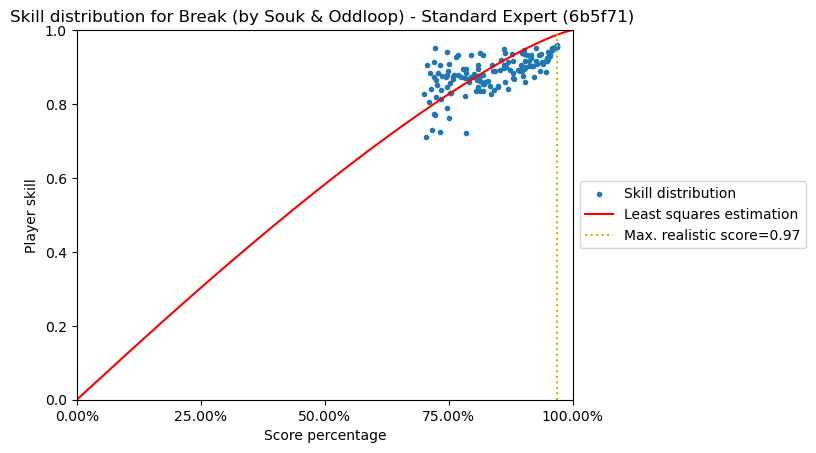

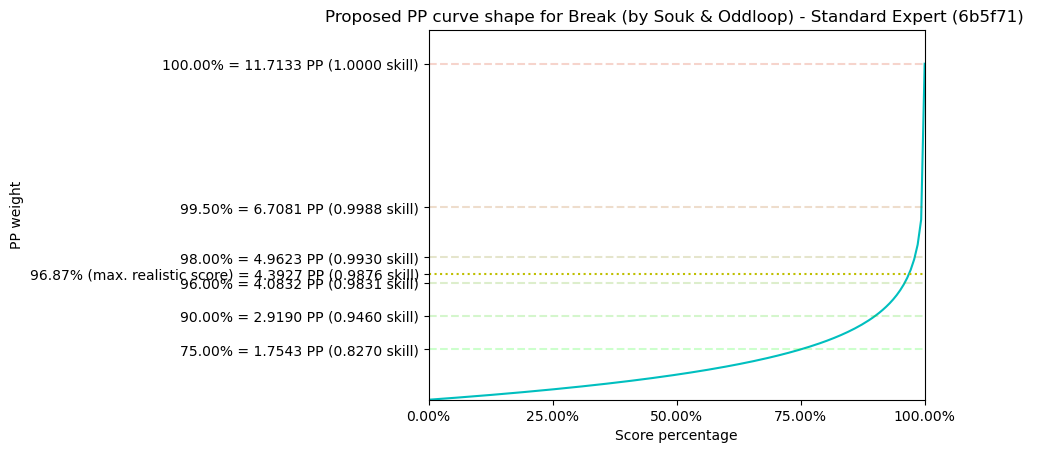

{'Hash': '90f11843fe54fb66296ec69908fcf53080ef197b', 'Name': 'Bomb The Rave', 'CoverImage': 'https://cdn.beatsaver.com/90f11843fe54fb66296ec69908fcf53080ef197b.jpg', 'Mapper': 'Blackjack', 'Id': '2dd6cxx92', 'SongId': '2dd6cxx', 'ModeName': 'OneSaber', 'DifficultyName': 'ExpertPlus', 'AccRating': 13.404479, 'PassRating': 6.1768565, 'TechRating': 11.720048, 'PredictedAcc': 0.96726257, 'ModifiersRating': {'Id': 1100579, 'SSPredictedAcc': 0.9689455, 'SSPassRating': 5.1238623, 'SSAccRating': 13.022099, 'SSTechRating': 11.007264, 'SSStars': 11.909079, 'FSPredictedAcc': 0.96551365, 'FSPassRating': 7.5588775, 'FSAccRating': 13.747836, 'FSTechRating': 12.343455, 'FSStars': 13.670211, 'SFPredictedAcc': 0.9634725, 'SFPassRating': 9.739114, 'SFAccRating': 14.171511, 'SFTechRating': 13.058716, 'SFStars': 15.040125, 'BFSPredictedAcc': 0.9639094, 'BFSPassRating': 8.789849, 'BFSAccRating': 12.639596, 'BFSTechRating': 12.945318, 'BFSStars': 13.185304, 'BSFPredictedAcc': 0.9595991, 'BSFPassRating': 11.

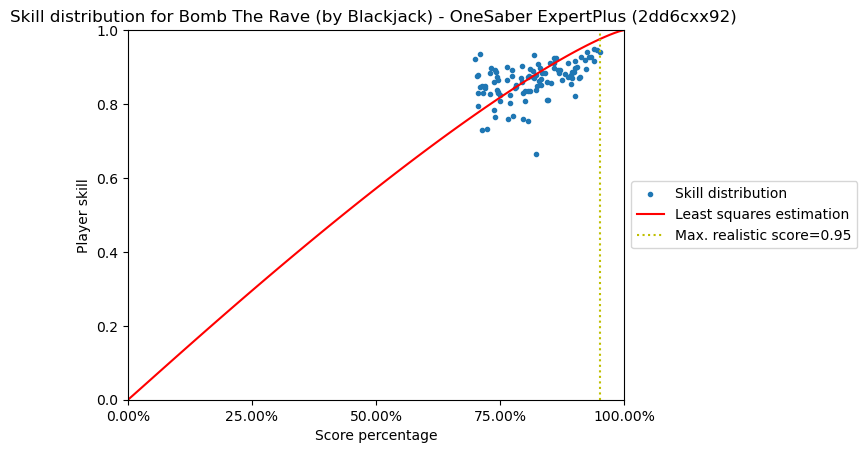

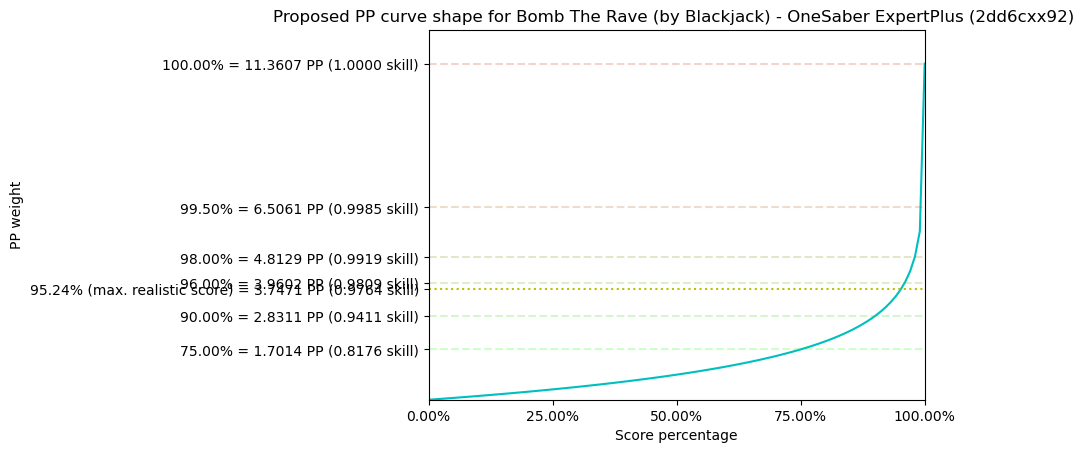

{'Hash': 'a626a0022e99517f71820cdb3eb802b6a70a2c79', 'Name': 'Deck The Halls', 'CoverImage': 'https://cdn.beatsaver.com/a626a0022e99517f71820cdb3eb802b6a70a2c79.jpg', 'Mapper': 'Emilia', 'Id': '3598fxx91', 'SongId': '3598fxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.027596, 'PassRating': 13.201743, 'TechRating': 3.2751286, 'PredictedAcc': 0.9728569, 'ModifiersRating': {'Id': 1057871, 'SSPredictedAcc': 0.9751085, 'SSPassRating': 11.148333, 'SSAccRating': 10.371042, 'SSTechRating': 3.236288, 'SSStars': 10.405595, 'FSPredictedAcc': 0.96991813, 'FSPassRating': 16.186573, 'FSAccRating': 11.772701, 'FSTechRating': 3.357779, 'FSStars': 13.891691, 'SFPredictedAcc': 0.96525794, 'SFPassRating': 21.552402, 'SFAccRating': 12.698721, 'SFTechRating': 3.5831401, 'SFStars': 17.71341, 'BFSPredictedAcc': 0.9670148, 'BFSPassRating': 16.692228, 'BFSAccRating': 12.077065, 'BFSTechRating': 3.427456, 'BFSStars': 14.440702, 'BSFPredictedAcc': 0.96123946, 'BSFPassRating': 21.551

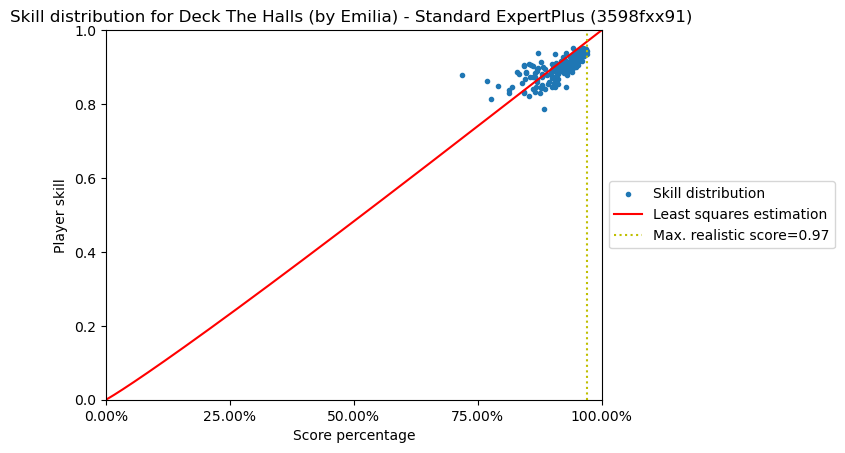

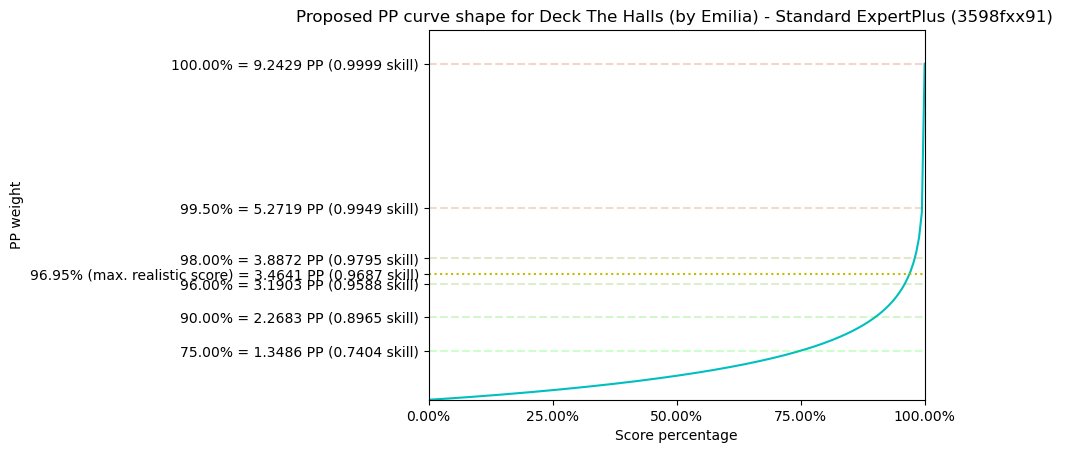

{'Hash': '40c3782bfcfebdac374203b6410092002c1c9ec5', 'Name': 'Extratongue', 'CoverImage': 'https://cdn.beatsaver.com/40c3782bfcfebdac374203b6410092002c1c9ec5.jpg', 'Mapper': 'Cratornugget', 'Id': '3f829xxxxxx91', 'SongId': '3f829xxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.46583, 'PassRating': 17.072155, 'TechRating': 2.5296187, 'PredictedAcc': 0.97114223, 'ModifiersRating': {'Id': 1300899, 'SSPredictedAcc': 0.97352135, 'SSPassRating': 14.479462, 'SSAccRating': 10.825347, 'SSTechRating': 2.5183067, 'SSStars': 12.075328, 'FSPredictedAcc': 0.96807814, 'FSPassRating': 20.756426, 'FSAccRating': 12.177607, 'FSTechRating': 2.5656097, 'FSStars': 16.545261, 'SFPredictedAcc': 0.9634306, 'SFPassRating': 27.578377, 'SFAccRating': 13.049293, 'SFTechRating': 2.7275863, 'SFStars': 21.915138, 'BFSPredictedAcc': 0.9663072, 'BFSPassRating': 21.397633, 'BFSAccRating': 12.20079, 'BFSTechRating': 2.6139858, 'BFSStars': 16.947996, 'BSFPredictedAcc': 0.9609672, 'BSFPassRa

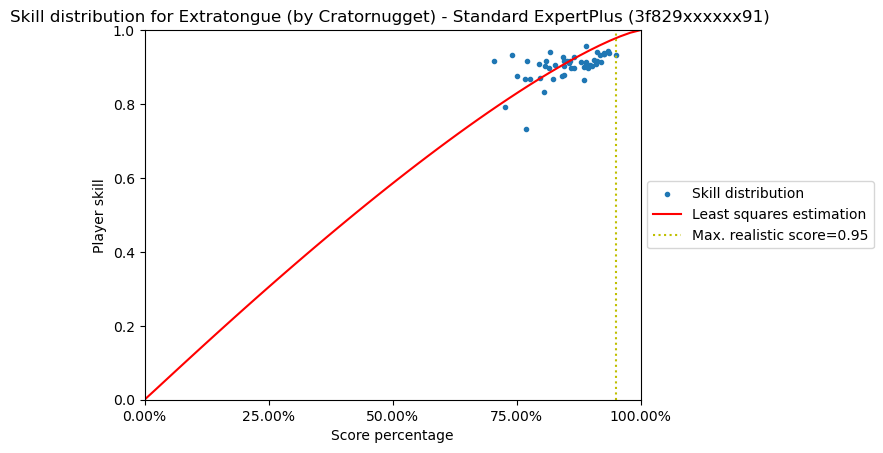

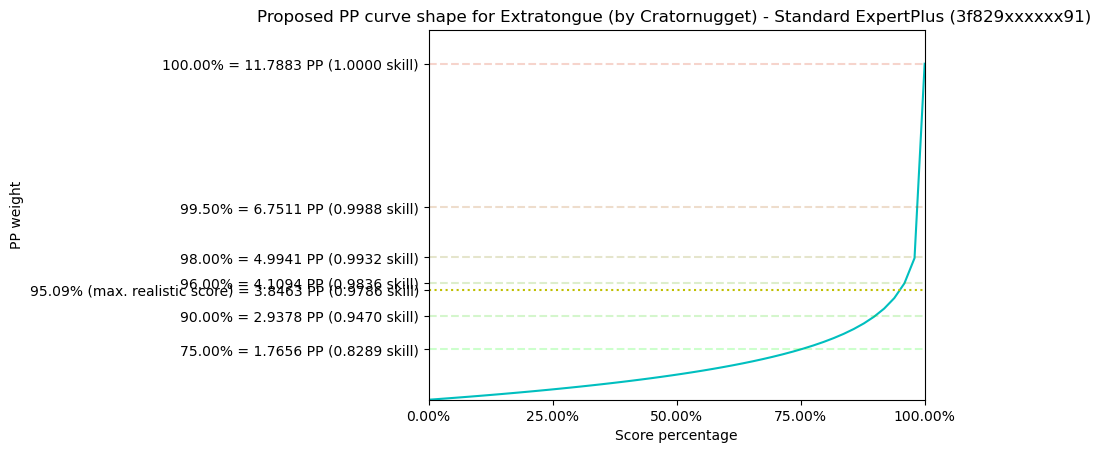

{'Hash': '3F567BC5CC7ADA8C9B5BC1436960C65C92355972', 'Name': 'Splatter Party', 'CoverImage': 'https://eu.cdn.beatsaver.com/3f567bc5cc7ada8c9b5bc1436960c65c92355972.jpg', 'Mapper': 'Anammelech & Otricity', 'Id': '2c888xxxxx91', 'SongId': '2c888xxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.314206, 'PassRating': 15.467564, 'TechRating': 4.0485296, 'PredictedAcc': 0.9707042, 'ModifiersRating': {'Id': 10162, 'SSPredictedAcc': 0.9730349, 'SSPassRating': 13.098803, 'SSAccRating': 10.718616, 'SSTechRating': 4.0212765, 'SSStars': 11.631456, 'FSPredictedAcc': 0.96748525, 'FSPassRating': 19.152706, 'FSAccRating': 12.011406, 'FSTechRating': 4.184974, 'FSStars': 15.777662, 'SFPredictedAcc': 0.9619043, 'SFPassRating': 25.527964, 'SFAccRating': 13.001505, 'SFTechRating': 4.4660172, 'SFStars': 20.733204, 'BFSPredictedAcc': 0.9640837, 'BFSPassRating': 19.975893, 'BFSAccRating': 12.606638, 'BFSTechRating': 4.2572865, 'BFSStars': 16.832142, 'BSFPredictedAcc': 0.95726866,

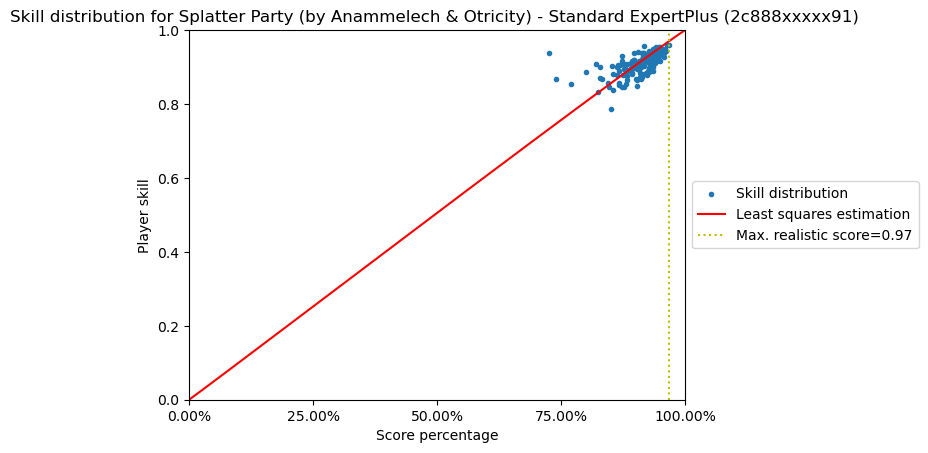

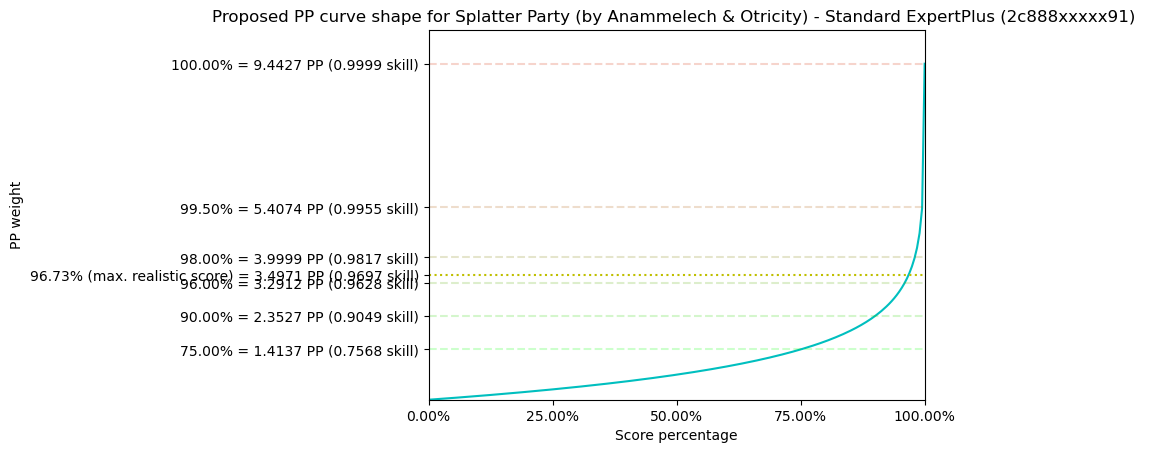

{'Hash': '506904800e3c03f9e0074156f6aae8bcb2f15705', 'Name': 'Shuenteki Routetsu Sokukakukyoku', 'CoverImage': 'https://eu.cdn.beatsaver.com/506904800e3c03f9e0074156f6aae8bcb2f15705.jpg', 'Mapper': 'Emilia', 'Id': '2cde3xxx91', 'SongId': '2cde3xxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.171565, 'PassRating': 15.241831, 'TechRating': 2.6215682, 'PredictedAcc': 0.972289, 'ModifiersRating': {'Id': 299784, 'SSPredictedAcc': 0.9744729, 'SSPassRating': 12.910148, 'SSAccRating': 10.548336, 'SSTechRating': 2.6029496, 'SSStars': 11.165604, 'FSPredictedAcc': 0.9693542, 'FSPassRating': 18.762304, 'FSAccRating': 11.893898, 'FSTechRating': 2.6948128, 'FSStars': 15.192278, 'SFPredictedAcc': 0.96450233, 'SFPassRating': 24.983833, 'SFAccRating': 12.841382, 'SFTechRating': 2.8732572, 'SFStars': 19.898546, 'BFSPredictedAcc': 0.9653758, 'BFSPassRating': 19.36099, 'BFSAccRating': 12.3675785, 'BFSTechRating': 2.7426627, 'BFSStars': 15.98561, 'BSFPredictedAcc': 0.959736, 'B

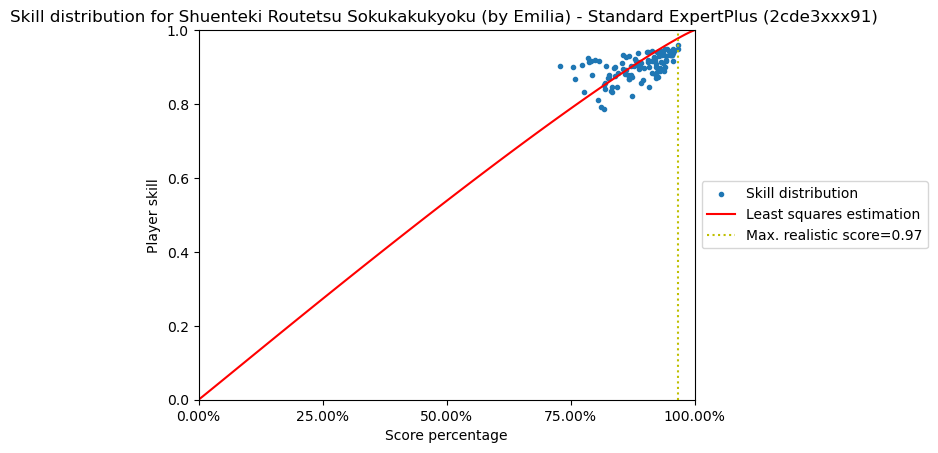

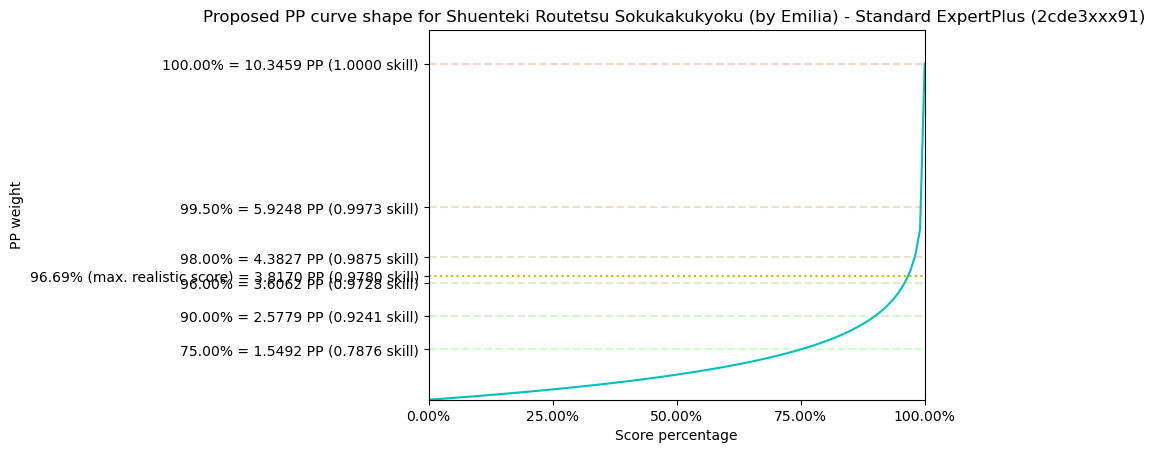

{'Hash': 'C4D4D2209DE79DCCE5BC30AE32EAA02C2B25C5B4', 'Name': 'Black Apple', 'CoverImage': 'https://eu.cdn.beatsaver.com/c4d4d2209de79dcce5bc30ae32eaa02c2b25c5b4.jpg', 'Mapper': 'Emilia', 'Id': '334e3x91', 'SongId': '334e3x', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.6179, 'PassRating': 12.047085, 'TechRating': 3.1336, 'PredictedAcc': 0.9728524, 'ModifiersRating': {'Id': 298911, 'SSPredictedAcc': 0.97540015, 'SSPassRating': 10.150647, 'SSAccRating': 10.832516, 'SSTechRating': 3.084166, 'SSStars': 10.41396, 'FSPredictedAcc': 0.9694259, 'FSPassRating': 14.753805, 'FSAccRating': 12.512625, 'FSTechRating': 3.2124753, 'FSStars': 13.898634, 'SFPredictedAcc': 0.9640834, 'SFPassRating': 19.662111, 'SFAccRating': 13.611858, 'SFTechRating': 3.4326289, 'SFStars': 17.513393, 'BFSPredictedAcc': 0.96527714, 'BFSPassRating': 15.196495, 'BFSAccRating': 12.385501, 'BFSTechRating': 3.2731535, 'BFSStars': 13.992883, 'BSFPredictedAcc': 0.9579277, 'BSFPassRating': 19.642466, 'B

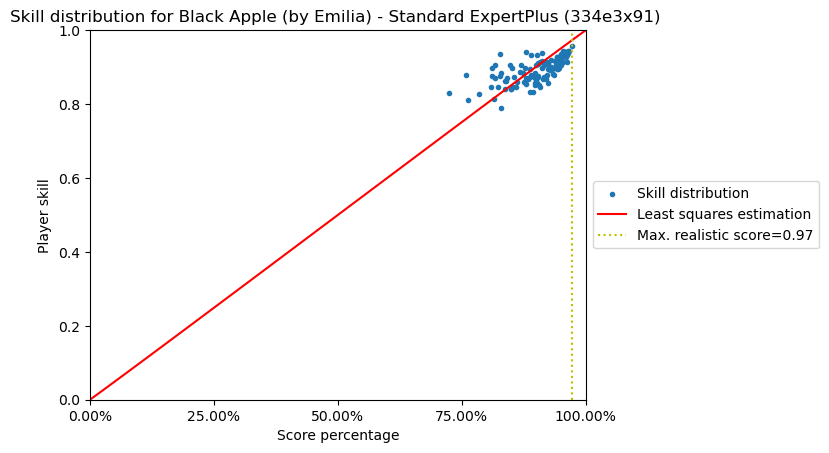

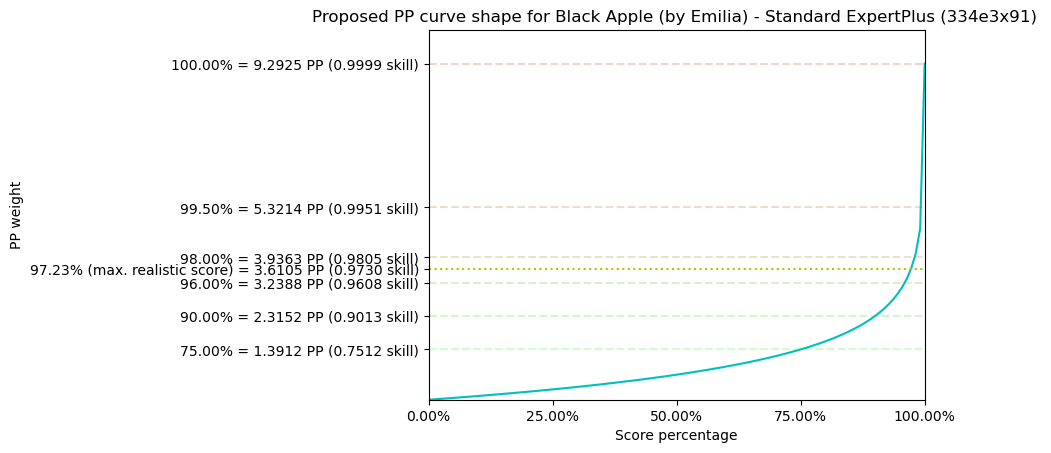

{'Hash': '8f2df8a22bcf7f7cddeed507390950c02b975dcf', 'Name': 'Splitting Noise', 'CoverImage': 'https://na.cdn.beatsaver.com/8f2df8a22bcf7f7cddeed507390950c02b975dcf.jpg', 'Mapper': 'Kip', 'Id': '2dd30xxxxxx91', 'SongId': '2dd30xxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.274255, 'PassRating': 15.368141, 'TechRating': 2.8149924, 'PredictedAcc': 0.97188205, 'ModifiersRating': {'Id': 1068058, 'SSPredictedAcc': 0.9741264, 'SSPassRating': 13.012602, 'SSAccRating': 10.64755, 'SSTechRating': 2.7955527, 'SSStars': 11.329563, 'FSPredictedAcc': 0.9689747, 'FSPassRating': 18.920225, 'FSAccRating': 11.976882, 'FSTechRating': 2.8932316, 'FSStars': 15.391766, 'SFPredictedAcc': 0.96427274, 'SFPassRating': 25.192528, 'SFAccRating': 12.88536, 'SFTechRating': 3.0845726, 'SFStars': 20.12432, 'BFSPredictedAcc': 0.9645233, 'BFSPassRating': 19.5294, 'BFSAccRating': 12.5242605, 'BFSTechRating': 2.944592, 'BFSStars': 16.26811, 'BSFPredictedAcc': 0.95891255, 'BSFPassRating':

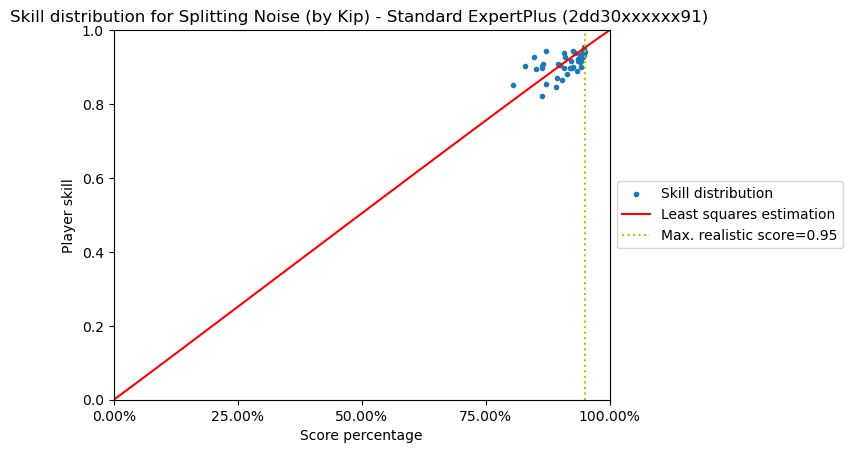

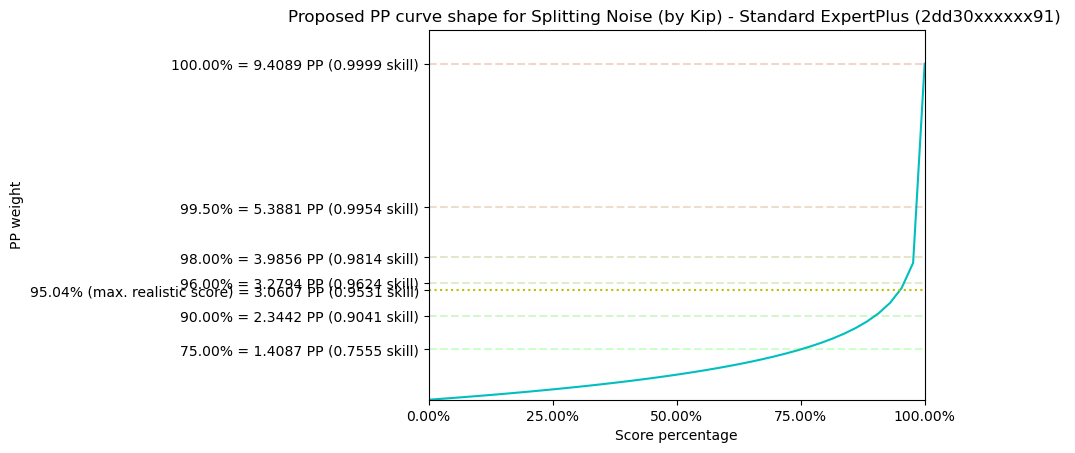

In [206]:
negative_r2_maps = []
for map_id, map_metrics in metrics["map_metrics_by_id"].items():
    if map_metrics["r2"] < 0:
        print(f"Map {map_id} has r2 = {map_metrics["r2"]}")
        negative_r2_maps.append(map_id)

for map_id in negative_r2_maps:        
    map_summary_with_skills(map_id, result_player_skills, map_params_by_map_id = result_map_params)

In [210]:
print(metrics["highest_100_threshold"])
print(metrics["highest_100_threshold_map_id"])

1.1404904426171087
38419x32


In [ ]:
print(metrics["highest_min_threshold"])
print(metrics["highest_min_threshold_map_id"])

In [ ]:
print(metrics["lowest_100_threshold"])
print(metrics["lowest_100_threshold_map_id"])

{'Hash': 'D5EBC9C4E38A700AB971C6256AE3A175C63B5B1D', 'Name': 'G e n g a o z o - f o o n', 'CoverImage': 'https://eu.cdn.beatsaver.com/d5ebc9c4e38a700ab971c6256ae3a175c63b5b1d.jpg', 'Mapper': 'ComplexFrequency', 'Id': '2ceacxxxxx91', 'SongId': '2ceacxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.160641, 'PassRating': 11.372194, 'TechRating': 3.2136338, 'PredictedAcc': 0.9696545, 'ModifiersRating': {'Id': 299843, 'SSPredictedAcc': 0.97172016, 'SSPassRating': 9.535997, 'SSAccRating': 11.632827, 'SSTechRating': 3.1524436, 'SSStars': 10.913464, 'FSPredictedAcc': 0.9671335, 'FSPassRating': 13.76647, 'FSAccRating': 12.704384, 'FSTechRating': 3.2532284, 'FSStars': 13.641699, 'SFPredictedAcc': 0.9635125, 'SFPassRating': 18.327972, 'SFAccRating': 13.398523, 'SFTechRating': 3.471965, 'SFStars': 16.577599, 'BFSPredictedAcc': 0.9640065, 'BFSPassRating': 14.190762, 'BFSAccRating': 12.621215, 'BFSTechRating': 3.3198571, 'BFSStars': 13.764002, 'BSFPredictedAcc': 0.9572

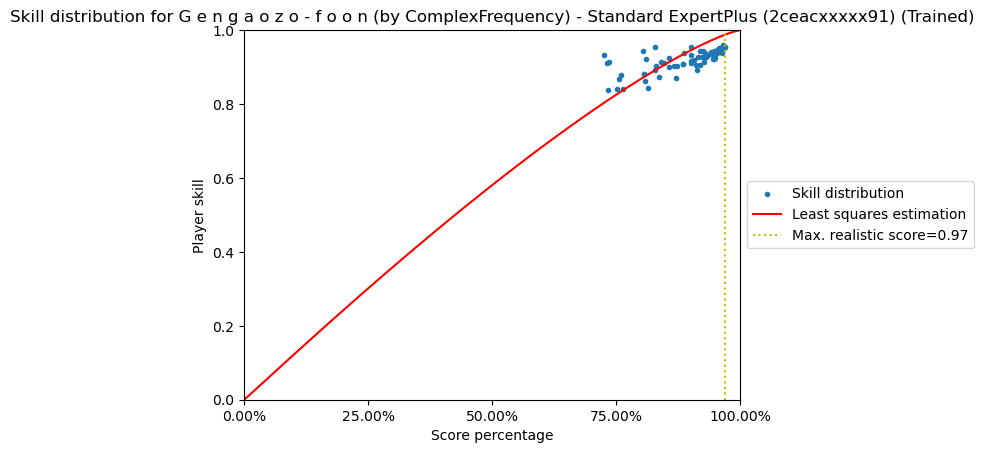

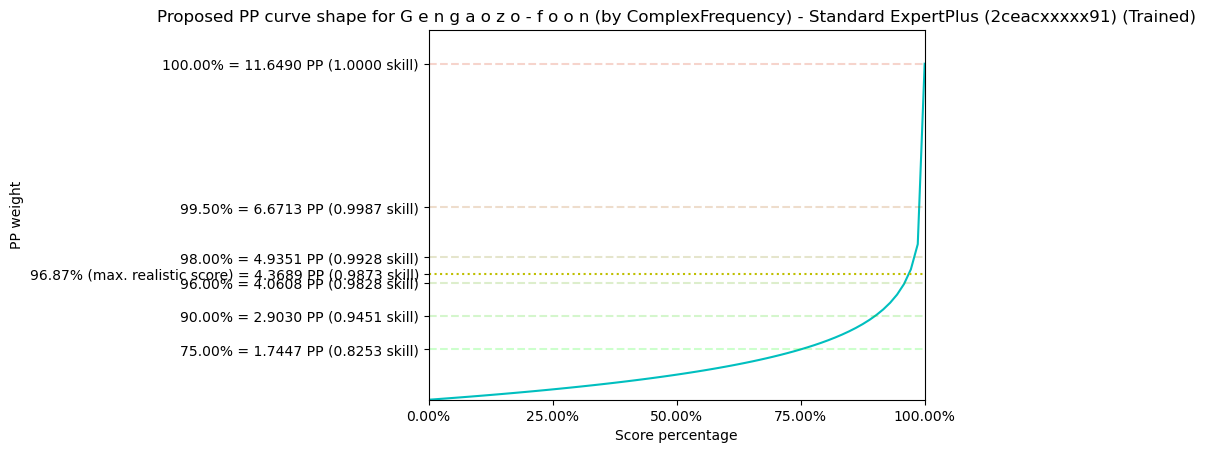

In [205]:
map_summary_with_skills("2ceacxxxxx91", result_player_skills, map_params_by_map_id = result_map_params, suffix = "(Trained)")

## Dirty testing

In [92]:
(a,b) = result_map_params["3e2c2xxxxx91"]
print((a,b))
beta.pdf(1,a,b)

(1.0100000000000295, 1.3069383884966417)


0.0

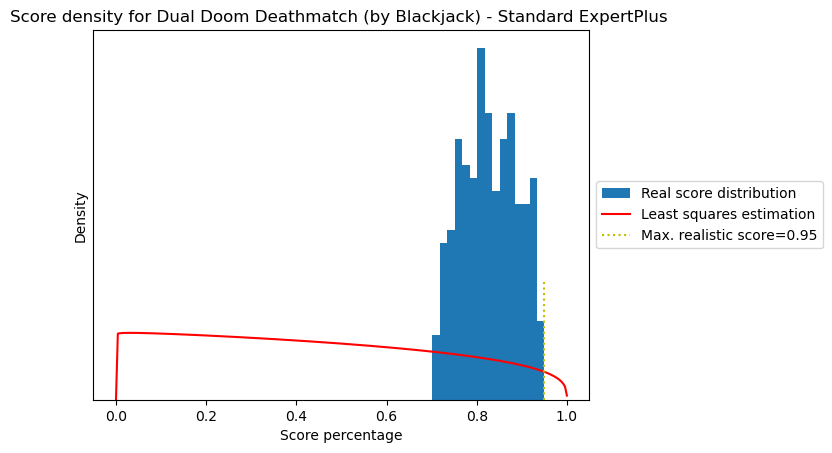

In [91]:
show_map_density_by_map_id("3e2c2xxxxx91",map_params_by_map_id = result_map_params)

In [ ]:
a = numpy.array(range(1,10))
aggregation_topscores(a)

In [93]:
print(max(result_player_skills.values()))

0.9682522595312806


In [ ]:
print(least_squares_beta_parameters_per_map["7e8f11"])

In [94]:
print(list(result_player_skills.keys())[:50])

['6934303390020875', '76561199226416935', '76561198417714735', '76561199047499804', '314013', '76561198080269479', '76561198140385955', '141548', '76561198102193472', '76561198798349760', '76561198174728961', '76561198867369254', '76561198294868440', '76561198332181104', '76561198831821325', '76561198025990465', '76561198128099365', '76561199022676628', '76561199097274802', '76561198442775192', '76561199082107939', '76561198136446297', '76561198086549329', '76561198016035408', '76561198080884464', '76561198172862915', '314405', '76561198127377699', '76561198171399133', '76561198218073841', '76561198288088601', '76561198028269543', '4007549595927577', '76561198058526328', '76561198147785402', '76561198253204590', '76561198121517821', '76561198324850911', '76561198094418690', '76561198162829099', '76561198321827585', '76561198995134821', '76561198048297928', '76561198095783740', '76561198000830591', '76561198327752843', '76561198073522601', '76561198416751060', '76561198314182828', '7656

In [95]:
print(result_player_skills["6934303390020875"])

0.21467589111371221


In [96]:
print(least_squares_beta_parameters_per_map["7e8f11"])
print(result_map_params["7e8f11"])

[27.45116505  1.19063228]
[6.2768585 1.01     ]


In [ ]:
filtered_scores[25340]

In [ ]:
list(scores_by_map_id["1e0b511"].values())[0]

In [ ]:
len(score_data_by_map_id["7b3031"])

In [ ]:
a1, b1, loc1, scale1 = beta.fit(score_data_by_map_id["1e0b511"], floc=0, fscale=1)

print(a1,b1,loc1,scale1)

In [ ]:
pp_curve_integral(0.995,(19.43,1.95,0,1))

In [ ]:
xx = numpy.linspace(min_score,1,50)
print(plot_pp_curve_integral(xx,(20.02,2.795)))

In [ ]:
least_squares_beta_parameters_per_map["3e2c2xxxxx91"]

In [ ]:
(a,b) = least_squares_beta_parameters_per_map["36bce91"]
gold_standard = maps_by_id["36bce91"]["gold_standard"]
#pass_threshold = 0
params = (a,b,gold_standard)
#params = (a,b,pass_threshold)
for x in [0.7,0.8,0.85,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,0.995,0.999,1]:
    print(f"{x} - {pp_curve_integral(x,params)}")

In [ ]:
(a,b) = least_squares_beta_parameters_per_map["2cf6391"]
gold_standard = maps_by_id["2cf6391"]["gold_standard"]
#pass_threshold = 0
params = (a,b,gold_standard)
#params = (a,b,pass_threshold)
for x in [0.7,0.8,0.85,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,0.995,0.999,1]:
    print(f"{x} - {pp_curve_integral(x,params)}")

In [ ]:
(a,b) = least_squares_beta_parameters_per_map["7e8f11"]
gold_standard = maps_by_id["7e8f11"]["gold_standard"]
#pass_threshold = 0
params = (a,b,gold_standard)
#params = (a,b,pass_threshold)
for x in [0.7,0.8,0.85,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,0.995,0.999,1]:
    print(f"{x} - {pp_curve_integral(x,params)}")

In [ ]:
(a,b) = least_squares_beta_parameters_per_map["2a57111"]
gold_standard = maps_by_id["2a57111"]["gold_standard"]
#pass_threshold = 0
params = (a,b,gold_standard)
#params = (a,b,pass_threshold)
for x in [0.7,0.8,0.85,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,0.995,0.999,1]:
    print(f"{x} - {pp_curve_integral(x,params)}")

In [ ]:
(a,b) = least_squares_beta_parameters_per_map["3898fx91"]
gold_standard = maps_by_id["3898fx91"]["gold_standard"]
#pass_threshold = 0
params = (a,b,gold_standard)
#params = (a,b,pass_threshold)
for x in [0.7,0.8,0.85,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,0.995,0.999,1]:
    print(f"{x} - {pp_curve_integral(x,params)}")

In [ ]:
show_map_density_by_map_id("36bce91")

In [ ]:
show_map_distribution_by_map_id("36bce91")

In [ ]:
show_map_pp_by_map_id("36bce91")

In [ ]:
residuals(beta_parameters_per_map["1695b31"],score_data_by_map_id["1695b31"])

In [ ]:
show_map_distribution_by_map_id("1695b31")

In [ ]:
random_map_summary()

In [ ]:
fit_scores_beta_least_squares(score_data_by_map_id["1695b31"],beta_parameters_per_map["1695b31"])

In [ ]:
r_squared_beta(least_squares_beta_parameters_per_map["1695b31"],score_data_by_map_id["1695b31"])

In [ ]:
quantiles_beta(least_squares_beta_parameters_per_map["1695b31"],score_data_by_map_id["1695b31"],10)

In [ ]:
print(best_r_squared_map_id)
print(best_r_squared)

In [ ]:
map_summary("e2ba51")

In [ ]:
a = [1,2,3,4,5]
print(list(zip(a[:-1],a[1:])))

In [ ]:
print(worst_r_squared_map_id)
print(worst_r_squared)

In [ ]:
map_summary("1a56811")

In [ ]:
map_summary("38419x91")

In [ ]:
def testy_test(map_id):
    (a,b) = beta_parameters_per_map[map_id]
    scores = score_data_by_map_id[map_id]
    #scores_with_skills = [(score,0.5) for score in scores]
    #scores_with_skills = [(score,score+random.random()/50) for score in scores]
    #scores_with_skills = [(score,1-2*(1-score)+random.random()/10) for score in scores]
    #scores_with_skills = [(score,0.5+0.5*beta.cdf(score,a,b)) for score in scores]
    scores_with_skills = [(score,0.1+0.6*beta.cdf(score,a,b)+0.3*random.random()) for score in scores]
    print((a,b))
    pass_threshold = 0
    testing_capability = 1
    initial_params = (a,b,pass_threshold,testing_capability)
    
    
    (a,b,pass_threshold,testing_capability) = fit_scores_beta_least_squares_affine_skills(scores_with_skills, initial_params)
    
    print((a,b,pass_threshold,testing_capability))
    show_map_distribution(maps_by_id[map_id], scores, a, b, pass_threshold, testing_capability)
    print(f"r2 = {r_squared_beta_affine_skills((a,b,pass_threshold,testing_capability),scores_with_skills)}")
    #print(residuals_affine_skills((a,b,pass_threshold,testing_capability),scores_with_skills))

map_id = worst_r_squared_map_id
testy_test(map_id)


#golden_standard_map_ids = ["c32d91","2ee3bxxxxxx91","7e8f11","36bce91","1f6b1xxxxxxxx91","23596xxx91","2cf6391","3e2c2xxxxx91","3bcf5xxxxxxxx91"]

#for map_id in golden_standard_map_ids:
#    testy_test(map_id)

In [ ]:
print(len(maps_by_id.keys()))

In [ ]:
for map_id, (a,b) in least_squares_beta_parameters_per_map.items():
    if a < 1 or b < 1:
        print(f"Map id {map_id} has ({a},{b})")